In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : True,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_1_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(738520, 828)
(738520, 8)
validation
(107232, 828)
(107232, 8)
test
(77368, 828)
(77368, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:35 - loss: 2.3963 - STD: 0.1505 - MAE: 0.2190

 4/74 [>.............................] - ETA: 1s - loss: 1.7818 - STD: 0.1279 - MAE: 0.1917  

 5/74 [=>............................] - ETA: 2s - loss: 1.7099 - STD: 0.1436 - MAE: 0.1824

 6/74 [=>............................] - ETA: 2s - loss: 1.6649 - STD: 0.1584 - MAE: 0.1744

 7/74 [=>............................] - ETA: 2s - loss: 1.6357 - STD: 0.1706 - MAE: 0.1681

 8/74 [==>...........................] - ETA: 2s - loss: 1.6141 - STD: 0.1803 - MAE: 0.1631

 9/74 [==>...........................] - ETA: 2s - loss: 1.5987 - STD: 0.1874 - MAE: 0.1595

10/74 [===>..........................] - ETA: 3s - loss: 1.5863 - STD: 0.1925 - MAE: 0.1568

11/74 [===>..........................] - ETA: 3s - loss: 1.5764 - STD: 0.1958 - MAE: 0.1550

12/74 [===>..........................] - ETA: 3s - loss: 1.5663 - STD: 0.1975 - MAE: 0.1539

13/74 [====>.........................] - ETA: 3s - loss: 1.5554 - STD: 0.1981 - MAE: 0.1531

14/74 [====>.........................] - ETA: 3s - loss: 1.5487 - STD: 0.1979 - MAE: 0.1529

15/74 [=====>........................] - ETA: 3s - loss: 1.5406 - STD: 0.1971 - MAE: 0.1529

16/74 [=====>........................] - ETA: 3s - loss: 1.5337 - STD: 0.1960 - MAE: 0.1530

17/74 [=====>........................] - ETA: 2s - loss: 1.5270 - STD: 0.1947 - MAE: 0.1532

18/74 [======>.......................] - ETA: 2s - loss: 1.5205 - STD: 0.1934 - MAE: 0.1535

19/74 [======>.......................] - ETA: 2s - loss: 1.5141 - STD: 0.1921 - MAE: 0.1537

20/74 [=======>......................] - ETA: 2s - loss: 1.5081 - STD: 0.1909 - MAE: 0.1539

21/74 [=======>......................] - ETA: 2s - loss: 1.5034 - STD: 0.1899 - MAE: 0.1541

22/74 [=======>......................] - ETA: 2s - loss: 1.4986 - STD: 0.1890 - MAE: 0.1542

23/74 [========>.....................] - ETA: 2s - loss: 1.4941 - STD: 0.1883 - MAE: 0.1543

24/74 [========>.....................] - ETA: 2s - loss: 1.4899 - STD: 0.1877 - MAE: 0.1543

25/74 [=========>....................] - ETA: 2s - loss: 1.4858 - STD: 0.1873 - MAE: 0.1543

26/74 [=========>....................] - ETA: 2s - loss: 1.4820 - STD: 0.1870 - MAE: 0.1543

27/74 [=========>....................] - ETA: 2s - loss: 1.4779 - STD: 0.1867 - MAE: 0.1542

28/74 [==========>...................] - ETA: 2s - loss: 1.4746 - STD: 0.1866 - MAE: 0.1541

29/74 [==========>...................] - ETA: 2s - loss: 1.4716 - STD: 0.1865 - MAE: 0.1541

30/74 [===========>..................] - ETA: 2s - loss: 1.4692 - STD: 0.1865 - MAE: 0.1540

31/74 [===========>..................] - ETA: 2s - loss: 1.4661 - STD: 0.1865 - MAE: 0.1539

32/74 [===========>..................] - ETA: 2s - loss: 1.4632 - STD: 0.1864 - MAE: 0.1538

33/74 [============>.................] - ETA: 2s - loss: 1.4611 - STD: 0.1864 - MAE: 0.1538

34/74 [============>.................] - ETA: 2s - loss: 1.4588 - STD: 0.1863 - MAE: 0.1537

35/74 [=============>................] - ETA: 2s - loss: 1.4570 - STD: 0.1861 - MAE: 0.1537

36/74 [=============>................] - ETA: 2s - loss: 1.4551 - STD: 0.1860 - MAE: 0.1537

37/74 [==============>...............] - ETA: 2s - loss: 1.4531 - STD: 0.1858 - MAE: 0.1537

38/74 [==============>...............] - ETA: 2s - loss: 1.4514 - STD: 0.1856 - MAE: 0.1537

39/74 [==============>...............] - ETA: 1s - loss: 1.4502 - STD: 0.1854 - MAE: 0.1537

40/74 [===============>..............] - ETA: 1s - loss: 1.4487 - STD: 0.1853 - MAE: 0.1537

41/74 [===============>..............] - ETA: 1s - loss: 1.4469 - STD: 0.1851 - MAE: 0.1537

42/74 [================>.............] - ETA: 1s - loss: 1.4452 - STD: 0.1850 - MAE: 0.1537

43/74 [================>.............] - ETA: 1s - loss: 1.4440 - STD: 0.1849 - MAE: 0.1536

44/74 [================>.............] - ETA: 1s - loss: 1.4427 - STD: 0.1849 - MAE: 0.1536

45/74 [=================>............] - ETA: 1s - loss: 1.4414 - STD: 0.1849 - MAE: 0.1536

46/74 [=================>............] - ETA: 1s - loss: 1.4403 - STD: 0.1850 - MAE: 0.1535

47/74 [==================>...........] - ETA: 1s - loss: 1.4386 - STD: 0.1850 - MAE: 0.1534

48/74 [==================>...........] - ETA: 1s - loss: 1.4377 - STD: 0.1850 - MAE: 0.1534

49/74 [==================>...........] - ETA: 1s - loss: 1.4367 - STD: 0.1851 - MAE: 0.1533

53/74 [====================>.........] - ETA: 1s - loss: 1.4319 - STD: 0.1850 - MAE: 0.1532

54/74 [====================>.........] - ETA: 1s - loss: 1.4311 - STD: 0.1849 - MAE: 0.1532

55/74 [=====================>........] - ETA: 1s - loss: 1.4297 - STD: 0.1849 - MAE: 0.1531

56/74 [=====================>........] - ETA: 1s - loss: 1.4288 - STD: 0.1848 - MAE: 0.1531

57/74 [======================>.......] - ETA: 1s - loss: 1.4277 - STD: 0.1847 - MAE: 0.1531

58/74 [======================>.......] - ETA: 1s - loss: 1.4274 - STD: 0.1847 - MAE: 0.1531

59/74 [======================>.......] - ETA: 0s - loss: 1.4269 - STD: 0.1846 - MAE: 0.1531

60/74 [=======================>......] - ETA: 0s - loss: 1.4264 - STD: 0.1846 - MAE: 0.1531

61/74 [=======================>......] - ETA: 0s - loss: 1.4259 - STD: 0.1845 - MAE: 0.1531

62/74 [========================>.....] - ETA: 0s - loss: 1.4250 - STD: 0.1844 - MAE: 0.1531

63/74 [========================>.....] - ETA: 0s - loss: 1.4242 - STD: 0.1844 - MAE: 0.1531

64/74 [========================>.....] - ETA: 0s - loss: 1.4234 - STD: 0.1843 - MAE: 0.1531

65/74 [=========================>....] - ETA: 0s - loss: 1.4226 - STD: 0.1842 - MAE: 0.1531

66/74 [=========================>....] - ETA: 0s - loss: 1.4218 - STD: 0.1842 - MAE: 0.1531

67/74 [==========================>...] - ETA: 0s - loss: 1.4213 - STD: 0.1842 - MAE: 0.1531

68/74 [==========================>...] - ETA: 0s - loss: 1.4205 - STD: 0.1842 - MAE: 0.1530

69/74 [==========================>...] - ETA: 0s - loss: 1.4200 - STD: 0.1842 - MAE: 0.1530

70/74 [===========================>..] - ETA: 0s - loss: 1.4194 - STD: 0.1842 - MAE: 0.1530

71/74 [===========================>..] - ETA: 0s - loss: 1.4191 - STD: 0.1842 - MAE: 0.1530

72/74 [============================>.] - ETA: 0s - loss: 1.4184 - STD: 0.1842 - MAE: 0.1530

73/74 [============================>.] - ETA: 0s - loss: 1.4177 - STD: 0.1842 - MAE: 0.1529

74/74 [==============================] - ETA: 0s - loss: 1.4173 - STD: 0.1842 - MAE: 0.1529

74/74 [==============================] - 7s 75ms/step - loss: 1.4173 - STD: 0.1842 - MAE: 0.1529 - val_loss: 1.3752 - val_STD: 0.1828 - val_MAE: 0.1519


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 1.3756 - STD: 0.1828 - MAE: 0.1517

 2/74 [..............................] - ETA: 4s - loss: 1.3825 - STD: 0.1825 - MAE: 0.1523

 3/74 [>.............................] - ETA: 4s - loss: 1.3919 - STD: 0.1822 - MAE: 0.1529

 5/74 [=>............................] - ETA: 3s - loss: 1.3891 - STD: 0.1813 - MAE: 0.1531

 6/74 [=>............................] - ETA: 3s - loss: 1.3850 - STD: 0.1809 - MAE: 0.1530

 7/74 [=>............................] - ETA: 3s - loss: 1.3842 - STD: 0.1807 - MAE: 0.1531

 8/74 [==>...........................] - ETA: 3s - loss: 1.3819 - STD: 0.1806 - MAE: 0.1530

 9/74 [==>...........................] - ETA: 3s - loss: 1.3821 - STD: 0.1807 - MAE: 0.1530

10/74 [===>..........................] - ETA: 3s - loss: 1.3840 - STD: 0.1808 - MAE: 0.1530

11/74 [===>..........................] - ETA: 3s - loss: 1.3831 - STD: 0.1810 - MAE: 0.1529

12/74 [===>..........................] - ETA: 3s - loss: 1.3822 - STD: 0.1812 - MAE: 0.1528

13/74 [====>.........................] - ETA: 3s - loss: 1.3824 - STD: 0.1814 - MAE: 0.1527

14/74 [====>.........................] - ETA: 3s - loss: 1.3826 - STD: 0.1815 - MAE: 0.1527

15/74 [=====>........................] - ETA: 3s - loss: 1.3838 - STD: 0.1817 - MAE: 0.1527

16/74 [=====>........................] - ETA: 3s - loss: 1.3830 - STD: 0.1817 - MAE: 0.1526

17/74 [=====>........................] - ETA: 3s - loss: 1.3819 - STD: 0.1818 - MAE: 0.1525

18/74 [======>.......................] - ETA: 3s - loss: 1.3822 - STD: 0.1818 - MAE: 0.1525

19/74 [======>.......................] - ETA: 3s - loss: 1.3830 - STD: 0.1819 - MAE: 0.1525

20/74 [=======>......................] - ETA: 3s - loss: 1.3832 - STD: 0.1819 - MAE: 0.1525

21/74 [=======>......................] - ETA: 2s - loss: 1.3837 - STD: 0.1819 - MAE: 0.1526

22/74 [=======>......................] - ETA: 2s - loss: 1.3846 - STD: 0.1819 - MAE: 0.1526

23/74 [========>.....................] - ETA: 2s - loss: 1.3840 - STD: 0.1818 - MAE: 0.1526

24/74 [========>.....................] - ETA: 2s - loss: 1.3835 - STD: 0.1817 - MAE: 0.1526

25/74 [=========>....................] - ETA: 2s - loss: 1.3836 - STD: 0.1816 - MAE: 0.1527

26/74 [=========>....................] - ETA: 2s - loss: 1.3836 - STD: 0.1816 - MAE: 0.1527

27/74 [=========>....................] - ETA: 2s - loss: 1.3834 - STD: 0.1815 - MAE: 0.1527

28/74 [==========>...................] - ETA: 2s - loss: 1.3833 - STD: 0.1815 - MAE: 0.1527

29/74 [==========>...................] - ETA: 2s - loss: 1.3834 - STD: 0.1814 - MAE: 0.1528

30/74 [===========>..................] - ETA: 2s - loss: 1.3839 - STD: 0.1814 - MAE: 0.1528

31/74 [===========>..................] - ETA: 2s - loss: 1.3846 - STD: 0.1814 - MAE: 0.1528

32/74 [===========>..................] - ETA: 2s - loss: 1.3840 - STD: 0.1814 - MAE: 0.1528

33/74 [============>.................] - ETA: 2s - loss: 1.3846 - STD: 0.1814 - MAE: 0.1528

34/74 [============>.................] - ETA: 2s - loss: 1.3844 - STD: 0.1814 - MAE: 0.1528

35/74 [=============>................] - ETA: 2s - loss: 1.3842 - STD: 0.1814 - MAE: 0.1528

36/74 [=============>................] - ETA: 2s - loss: 1.3836 - STD: 0.1814 - MAE: 0.1528

37/74 [==============>...............] - ETA: 2s - loss: 1.3834 - STD: 0.1814 - MAE: 0.1528

38/74 [==============>...............] - ETA: 2s - loss: 1.3836 - STD: 0.1815 - MAE: 0.1528

39/74 [==============>...............] - ETA: 1s - loss: 1.3835 - STD: 0.1815 - MAE: 0.1527

40/74 [===============>..............] - ETA: 1s - loss: 1.3833 - STD: 0.1815 - MAE: 0.1527

41/74 [===============>..............] - ETA: 1s - loss: 1.3830 - STD: 0.1816 - MAE: 0.1527

42/74 [================>.............] - ETA: 1s - loss: 1.3827 - STD: 0.1816 - MAE: 0.1527

43/74 [================>.............] - ETA: 1s - loss: 1.3826 - STD: 0.1816 - MAE: 0.1527

44/74 [================>.............] - ETA: 1s - loss: 1.3822 - STD: 0.1816 - MAE: 0.1526

45/74 [=================>............] - ETA: 1s - loss: 1.3821 - STD: 0.1817 - MAE: 0.1526

46/74 [=================>............] - ETA: 1s - loss: 1.3822 - STD: 0.1817 - MAE: 0.1526

47/74 [==================>...........] - ETA: 1s - loss: 1.3824 - STD: 0.1817 - MAE: 0.1526

48/74 [==================>...........] - ETA: 1s - loss: 1.3819 - STD: 0.1817 - MAE: 0.1526

49/74 [==================>...........] - ETA: 1s - loss: 1.3817 - STD: 0.1817 - MAE: 0.1526

50/74 [===================>..........] - ETA: 1s - loss: 1.3816 - STD: 0.1817 - MAE: 0.1525

51/74 [===================>..........] - ETA: 1s - loss: 1.3815 - STD: 0.1817 - MAE: 0.1525

52/74 [====================>.........] - ETA: 1s - loss: 1.3815 - STD: 0.1817 - MAE: 0.1525

53/74 [====================>.........] - ETA: 1s - loss: 1.3811 - STD: 0.1817 - MAE: 0.1525

54/74 [====================>.........] - ETA: 1s - loss: 1.3812 - STD: 0.1817 - MAE: 0.1525

55/74 [=====================>........] - ETA: 1s - loss: 1.3807 - STD: 0.1817 - MAE: 0.1525

56/74 [=====================>........] - ETA: 1s - loss: 1.3805 - STD: 0.1817 - MAE: 0.1525

57/74 [======================>.......] - ETA: 0s - loss: 1.3808 - STD: 0.1817 - MAE: 0.1525

58/74 [======================>.......] - ETA: 0s - loss: 1.3804 - STD: 0.1817 - MAE: 0.1525

59/74 [======================>.......] - ETA: 0s - loss: 1.3802 - STD: 0.1817 - MAE: 0.1525

60/74 [=======================>......] - ETA: 0s - loss: 1.3796 - STD: 0.1817 - MAE: 0.1524

61/74 [=======================>......] - ETA: 0s - loss: 1.3794 - STD: 0.1817 - MAE: 0.1524

62/74 [========================>.....] - ETA: 0s - loss: 1.3790 - STD: 0.1817 - MAE: 0.1524

63/74 [========================>.....] - ETA: 0s - loss: 1.3786 - STD: 0.1817 - MAE: 0.1523

64/74 [========================>.....] - ETA: 0s - loss: 1.3783 - STD: 0.1818 - MAE: 0.1523

65/74 [=========================>....] - ETA: 0s - loss: 1.3777 - STD: 0.1818 - MAE: 0.1523

66/74 [=========================>....] - ETA: 0s - loss: 1.3772 - STD: 0.1818 - MAE: 0.1522

67/74 [==========================>...] - ETA: 0s - loss: 1.3765 - STD: 0.1819 - MAE: 0.1522

68/74 [==========================>...] - ETA: 0s - loss: 1.3761 - STD: 0.1819 - MAE: 0.1521

69/74 [==========================>...] - ETA: 0s - loss: 1.3755 - STD: 0.1820 - MAE: 0.1521

70/74 [===========================>..] - ETA: 0s - loss: 1.3754 - STD: 0.1820 - MAE: 0.1521

71/74 [===========================>..] - ETA: 0s - loss: 1.3751 - STD: 0.1820 - MAE: 0.1520

72/74 [============================>.] - ETA: 0s - loss: 1.3747 - STD: 0.1820 - MAE: 0.1520

73/74 [============================>.] - ETA: 0s - loss: 1.3742 - STD: 0.1820 - MAE: 0.1520

74/74 [==============================] - ETA: 0s - loss: 1.3737 - STD: 0.1820 - MAE: 0.1519

74/74 [==============================] - 4s 60ms/step - loss: 1.3737 - STD: 0.1820 - MAE: 0.1519 - val_loss: 1.3304 - val_STD: 0.1813 - val_MAE: 0.1495


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 1.3556 - STD: 0.1834 - MAE: 0.1502

 2/74 [..............................] - ETA: 4s - loss: 1.3431 - STD: 0.1821 - MAE: 0.1499

 3/74 [>.............................] - ETA: 4s - loss: 1.3380 - STD: 0.1818 - MAE: 0.1497

 4/74 [>.............................] - ETA: 4s - loss: 1.3343 - STD: 0.1821 - MAE: 0.1494

 5/74 [=>............................] - ETA: 4s - loss: 1.3337 - STD: 0.1833 - MAE: 0.1489

 6/74 [=>............................] - ETA: 4s - loss: 1.3328 - STD: 0.1843 - MAE: 0.1485

 7/74 [=>............................] - ETA: 3s - loss: 1.3310 - STD: 0.1849 - MAE: 0.1483

 8/74 [==>...........................] - ETA: 3s - loss: 1.3288 - STD: 0.1849 - MAE: 0.1481

 9/74 [==>...........................] - ETA: 3s - loss: 1.3246 - STD: 0.1850 - MAE: 0.1479

10/74 [===>..........................] - ETA: 3s - loss: 1.3242 - STD: 0.1855 - MAE: 0.1477

11/74 [===>..........................] - ETA: 3s - loss: 1.3238 - STD: 0.1860 - MAE: 0.1475

12/74 [===>..........................] - ETA: 3s - loss: 1.3240 - STD: 0.1860 - MAE: 0.1475

13/74 [====>.........................] - ETA: 3s - loss: 1.3245 - STD: 0.1858 - MAE: 0.1476

14/74 [====>.........................] - ETA: 3s - loss: 1.3247 - STD: 0.1856 - MAE: 0.1478

15/74 [=====>........................] - ETA: 3s - loss: 1.3237 - STD: 0.1858 - MAE: 0.1476

16/74 [=====>........................] - ETA: 3s - loss: 1.3232 - STD: 0.1862 - MAE: 0.1475

17/74 [=====>........................] - ETA: 3s - loss: 1.3228 - STD: 0.1864 - MAE: 0.1474

18/74 [======>.......................] - ETA: 3s - loss: 1.3219 - STD: 0.1864 - MAE: 0.1473

19/74 [======>.......................] - ETA: 3s - loss: 1.3199 - STD: 0.1864 - MAE: 0.1472

20/74 [=======>......................] - ETA: 3s - loss: 1.3192 - STD: 0.1867 - MAE: 0.1471

21/74 [=======>......................] - ETA: 3s - loss: 1.3182 - STD: 0.1873 - MAE: 0.1468

22/74 [=======>......................] - ETA: 3s - loss: 1.3176 - STD: 0.1877 - MAE: 0.1466

23/74 [========>.....................] - ETA: 2s - loss: 1.3169 - STD: 0.1877 - MAE: 0.1466

24/74 [========>.....................] - ETA: 2s - loss: 1.3175 - STD: 0.1876 - MAE: 0.1467

25/74 [=========>....................] - ETA: 2s - loss: 1.3163 - STD: 0.1875 - MAE: 0.1466

26/74 [=========>....................] - ETA: 2s - loss: 1.3155 - STD: 0.1878 - MAE: 0.1465

27/74 [=========>....................] - ETA: 2s - loss: 1.3147 - STD: 0.1882 - MAE: 0.1463

28/74 [==========>...................] - ETA: 2s - loss: 1.3141 - STD: 0.1883 - MAE: 0.1462

29/74 [==========>...................] - ETA: 2s - loss: 1.3131 - STD: 0.1882 - MAE: 0.1462

30/74 [===========>..................] - ETA: 2s - loss: 1.3122 - STD: 0.1881 - MAE: 0.1462

31/74 [===========>..................] - ETA: 2s - loss: 1.3113 - STD: 0.1883 - MAE: 0.1461

32/74 [===========>..................] - ETA: 2s - loss: 1.3111 - STD: 0.1887 - MAE: 0.1460

33/74 [============>.................] - ETA: 2s - loss: 1.3102 - STD: 0.1888 - MAE: 0.1459

34/74 [============>.................] - ETA: 2s - loss: 1.3098 - STD: 0.1888 - MAE: 0.1459

35/74 [=============>................] - ETA: 2s - loss: 1.3096 - STD: 0.1887 - MAE: 0.1459

36/74 [=============>................] - ETA: 2s - loss: 1.3090 - STD: 0.1889 - MAE: 0.1458

37/74 [==============>...............] - ETA: 2s - loss: 1.3080 - STD: 0.1891 - MAE: 0.1457

38/74 [==============>...............] - ETA: 2s - loss: 1.3079 - STD: 0.1890 - MAE: 0.1457

39/74 [==============>...............] - ETA: 2s - loss: 1.3070 - STD: 0.1890 - MAE: 0.1457

40/74 [===============>..............] - ETA: 1s - loss: 1.3065 - STD: 0.1892 - MAE: 0.1456

41/74 [===============>..............] - ETA: 1s - loss: 1.3057 - STD: 0.1894 - MAE: 0.1455

42/74 [================>.............] - ETA: 1s - loss: 1.3050 - STD: 0.1894 - MAE: 0.1455

43/74 [================>.............] - ETA: 1s - loss: 1.3044 - STD: 0.1894 - MAE: 0.1454

44/74 [================>.............] - ETA: 1s - loss: 1.3036 - STD: 0.1896 - MAE: 0.1453

45/74 [=================>............] - ETA: 1s - loss: 1.3028 - STD: 0.1898 - MAE: 0.1452

46/74 [=================>............] - ETA: 1s - loss: 1.3025 - STD: 0.1897 - MAE: 0.1452

47/74 [==================>...........] - ETA: 1s - loss: 1.3018 - STD: 0.1896 - MAE: 0.1452

48/74 [==================>...........] - ETA: 1s - loss: 1.3014 - STD: 0.1899 - MAE: 0.1451

49/74 [==================>...........] - ETA: 1s - loss: 1.3002 - STD: 0.1900 - MAE: 0.1451

50/74 [===================>..........] - ETA: 1s - loss: 1.2991 - STD: 0.1900 - MAE: 0.1450

51/74 [===================>..........] - ETA: 1s - loss: 1.2982 - STD: 0.1902 - MAE: 0.1449

53/74 [====================>.........] - ETA: 1s - loss: 1.2963 - STD: 0.1903 - MAE: 0.1447

54/74 [====================>.........] - ETA: 1s - loss: 1.2954 - STD: 0.1904 - MAE: 0.1447

55/74 [=====================>........] - ETA: 1s - loss: 1.2948 - STD: 0.1905 - MAE: 0.1446

56/74 [=====================>........] - ETA: 1s - loss: 1.2940 - STD: 0.1906 - MAE: 0.1446

57/74 [======================>.......] - ETA: 0s - loss: 1.2932 - STD: 0.1906 - MAE: 0.1445

58/74 [======================>.......] - ETA: 0s - loss: 1.2928 - STD: 0.1906 - MAE: 0.1445

59/74 [======================>.......] - ETA: 0s - loss: 1.2920 - STD: 0.1907 - MAE: 0.1445

60/74 [=======================>......] - ETA: 0s - loss: 1.2912 - STD: 0.1908 - MAE: 0.1444

61/74 [=======================>......] - ETA: 0s - loss: 1.2900 - STD: 0.1909 - MAE: 0.1443

62/74 [========================>.....] - ETA: 0s - loss: 1.2891 - STD: 0.1911 - MAE: 0.1442

63/74 [========================>.....] - ETA: 0s - loss: 1.2884 - STD: 0.1910 - MAE: 0.1442

64/74 [========================>.....] - ETA: 0s - loss: 1.2877 - STD: 0.1910 - MAE: 0.1442

65/74 [=========================>....] - ETA: 0s - loss: 1.2868 - STD: 0.1912 - MAE: 0.1441

66/74 [=========================>....] - ETA: 0s - loss: 1.2859 - STD: 0.1912 - MAE: 0.1441

67/74 [==========================>...] - ETA: 0s - loss: 1.2853 - STD: 0.1913 - MAE: 0.1440

68/74 [==========================>...] - ETA: 0s - loss: 1.2842 - STD: 0.1914 - MAE: 0.1439

69/74 [==========================>...] - ETA: 0s - loss: 1.2835 - STD: 0.1916 - MAE: 0.1439

70/74 [===========================>..] - ETA: 0s - loss: 1.2826 - STD: 0.1915 - MAE: 0.1438

71/74 [===========================>..] - ETA: 0s - loss: 1.2818 - STD: 0.1916 - MAE: 0.1438

72/74 [============================>.] - ETA: 0s - loss: 1.2809 - STD: 0.1917 - MAE: 0.1437

73/74 [============================>.] - ETA: 0s - loss: 1.2799 - STD: 0.1918 - MAE: 0.1436

74/74 [==============================] - ETA: 0s - loss: 1.2790 - STD: 0.1919 - MAE: 0.1436

74/74 [==============================] - 5s 62ms/step - loss: 1.2790 - STD: 0.1919 - MAE: 0.1436 - val_loss: 1.2311 - val_STD: 0.1971 - val_MAE: 0.1393


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 1.2281 - STD: 0.2040 - MAE: 0.1374

 2/74 [..............................] - ETA: 4s - loss: 1.2147 - STD: 0.1959 - MAE: 0.1399

 3/74 [>.............................] - ETA: 4s - loss: 1.2161 - STD: 0.1960 - MAE: 0.1400

 4/74 [>.............................] - ETA: 4s - loss: 1.2144 - STD: 0.1984 - MAE: 0.1390

 5/74 [=>............................] - ETA: 4s - loss: 1.2096 - STD: 0.1973 - MAE: 0.1390

 6/74 [=>............................] - ETA: 4s - loss: 1.2066 - STD: 0.1984 - MAE: 0.1385

 7/74 [=>............................] - ETA: 3s - loss: 1.2067 - STD: 0.1994 - MAE: 0.1381

 8/74 [==>...........................] - ETA: 3s - loss: 1.2062 - STD: 0.1978 - MAE: 0.1387

 9/74 [==>...........................] - ETA: 3s - loss: 1.2060 - STD: 0.1973 - MAE: 0.1389

10/74 [===>..........................] - ETA: 3s - loss: 1.2049 - STD: 0.1981 - MAE: 0.1385

11/74 [===>..........................] - ETA: 3s - loss: 1.2025 - STD: 0.1987 - MAE: 0.1381

12/74 [===>..........................] - ETA: 3s - loss: 1.2015 - STD: 0.1981 - MAE: 0.1384

13/74 [====>.........................] - ETA: 3s - loss: 1.2003 - STD: 0.1980 - MAE: 0.1383

14/74 [====>.........................] - ETA: 3s - loss: 1.1996 - STD: 0.1988 - MAE: 0.1380

15/74 [=====>........................] - ETA: 3s - loss: 1.1999 - STD: 0.1986 - MAE: 0.1381

16/74 [=====>........................] - ETA: 3s - loss: 1.1991 - STD: 0.1978 - MAE: 0.1384

17/74 [=====>........................] - ETA: 3s - loss: 1.1981 - STD: 0.1983 - MAE: 0.1382

18/74 [======>.......................] - ETA: 3s - loss: 1.1965 - STD: 0.1989 - MAE: 0.1378

19/74 [======>.......................] - ETA: 3s - loss: 1.1956 - STD: 0.1987 - MAE: 0.1379

20/74 [=======>......................] - ETA: 3s - loss: 1.1950 - STD: 0.1983 - MAE: 0.1380

21/74 [=======>......................] - ETA: 3s - loss: 1.1943 - STD: 0.1987 - MAE: 0.1379

22/74 [=======>......................] - ETA: 3s - loss: 1.1939 - STD: 0.1990 - MAE: 0.1378

23/74 [========>.....................] - ETA: 2s - loss: 1.1939 - STD: 0.1986 - MAE: 0.1379

24/74 [========>.....................] - ETA: 2s - loss: 1.1929 - STD: 0.1984 - MAE: 0.1379

26/74 [=========>....................] - ETA: 2s - loss: 1.1922 - STD: 0.1991 - MAE: 0.1377

27/74 [=========>....................] - ETA: 2s - loss: 1.1916 - STD: 0.1987 - MAE: 0.1378

28/74 [==========>...................] - ETA: 2s - loss: 1.1901 - STD: 0.1987 - MAE: 0.1378

29/74 [==========>...................] - ETA: 2s - loss: 1.1896 - STD: 0.1991 - MAE: 0.1376

30/74 [===========>..................] - ETA: 2s - loss: 1.1887 - STD: 0.1993 - MAE: 0.1375

31/74 [===========>..................] - ETA: 2s - loss: 1.1876 - STD: 0.1990 - MAE: 0.1376

32/74 [===========>..................] - ETA: 2s - loss: 1.1866 - STD: 0.1991 - MAE: 0.1375

33/74 [============>.................] - ETA: 2s - loss: 1.1854 - STD: 0.1995 - MAE: 0.1373

34/74 [============>.................] - ETA: 2s - loss: 1.1844 - STD: 0.1996 - MAE: 0.1372

35/74 [=============>................] - ETA: 2s - loss: 1.1831 - STD: 0.1997 - MAE: 0.1371

36/74 [=============>................] - ETA: 2s - loss: 1.1821 - STD: 0.1998 - MAE: 0.1371

37/74 [==============>...............] - ETA: 2s - loss: 1.1818 - STD: 0.1999 - MAE: 0.1370

38/74 [==============>...............] - ETA: 2s - loss: 1.1809 - STD: 0.2000 - MAE: 0.1369

39/74 [==============>...............] - ETA: 2s - loss: 1.1798 - STD: 0.2002 - MAE: 0.1368

40/74 [===============>..............] - ETA: 1s - loss: 1.1782 - STD: 0.2002 - MAE: 0.1367

41/74 [===============>..............] - ETA: 1s - loss: 1.1773 - STD: 0.2004 - MAE: 0.1366

42/74 [================>.............] - ETA: 1s - loss: 1.1762 - STD: 0.2007 - MAE: 0.1365

43/74 [================>.............] - ETA: 1s - loss: 1.1758 - STD: 0.2007 - MAE: 0.1365

44/74 [================>.............] - ETA: 1s - loss: 1.1753 - STD: 0.2005 - MAE: 0.1365

45/74 [=================>............] - ETA: 1s - loss: 1.1745 - STD: 0.2007 - MAE: 0.1364

46/74 [=================>............] - ETA: 1s - loss: 1.1737 - STD: 0.2011 - MAE: 0.1363

47/74 [==================>...........] - ETA: 1s - loss: 1.1728 - STD: 0.2010 - MAE: 0.1362

48/74 [==================>...........] - ETA: 1s - loss: 1.1718 - STD: 0.2011 - MAE: 0.1362

49/74 [==================>...........] - ETA: 1s - loss: 1.1711 - STD: 0.2013 - MAE: 0.1361

50/74 [===================>..........] - ETA: 1s - loss: 1.1705 - STD: 0.2012 - MAE: 0.1361

51/74 [===================>..........] - ETA: 1s - loss: 1.1695 - STD: 0.2014 - MAE: 0.1360

52/74 [====================>.........] - ETA: 1s - loss: 1.1688 - STD: 0.2015 - MAE: 0.1359

53/74 [====================>.........] - ETA: 1s - loss: 1.1682 - STD: 0.2015 - MAE: 0.1359

54/74 [====================>.........] - ETA: 1s - loss: 1.1676 - STD: 0.2015 - MAE: 0.1359

55/74 [=====================>........] - ETA: 1s - loss: 1.1668 - STD: 0.2018 - MAE: 0.1357

56/74 [=====================>........] - ETA: 1s - loss: 1.1663 - STD: 0.2018 - MAE: 0.1357

57/74 [======================>.......] - ETA: 0s - loss: 1.1657 - STD: 0.2017 - MAE: 0.1357

58/74 [======================>.......] - ETA: 0s - loss: 1.1651 - STD: 0.2019 - MAE: 0.1357

59/74 [======================>.......] - ETA: 0s - loss: 1.1645 - STD: 0.2020 - MAE: 0.1356

60/74 [=======================>......] - ETA: 0s - loss: 1.1643 - STD: 0.2020 - MAE: 0.1356

61/74 [=======================>......] - ETA: 0s - loss: 1.1637 - STD: 0.2019 - MAE: 0.1356

62/74 [========================>.....] - ETA: 0s - loss: 1.1633 - STD: 0.2021 - MAE: 0.1355

63/74 [========================>.....] - ETA: 0s - loss: 1.1626 - STD: 0.2021 - MAE: 0.1355

64/74 [========================>.....] - ETA: 0s - loss: 1.1623 - STD: 0.2021 - MAE: 0.1355

65/74 [=========================>....] - ETA: 0s - loss: 1.1615 - STD: 0.2022 - MAE: 0.1354

66/74 [=========================>....] - ETA: 0s - loss: 1.1610 - STD: 0.2023 - MAE: 0.1354

67/74 [==========================>...] - ETA: 0s - loss: 1.1605 - STD: 0.2023 - MAE: 0.1353

68/74 [==========================>...] - ETA: 0s - loss: 1.1596 - STD: 0.2025 - MAE: 0.1353

69/74 [==========================>...] - ETA: 0s - loss: 1.1592 - STD: 0.2026 - MAE: 0.1352

70/74 [===========================>..] - ETA: 0s - loss: 1.1587 - STD: 0.2025 - MAE: 0.1352

71/74 [===========================>..] - ETA: 0s - loss: 1.1582 - STD: 0.2026 - MAE: 0.1352

72/74 [============================>.] - ETA: 0s - loss: 1.1578 - STD: 0.2027 - MAE: 0.1351

73/74 [============================>.] - ETA: 0s - loss: 1.1573 - STD: 0.2027 - MAE: 0.1351

74/74 [==============================] - ETA: 0s - loss: 1.1565 - STD: 0.2026 - MAE: 0.1351

74/74 [==============================] - 5s 61ms/step - loss: 1.1565 - STD: 0.2026 - MAE: 0.1351 - val_loss: 1.1378 - val_STD: 0.2143 - val_MAE: 0.1293


Epoch 5/10000


 1/74 [..............................] - ETA: 6s - loss: 1.1115 - STD: 0.2180 - MAE: 0.1273

 2/74 [..............................] - ETA: 4s - loss: 1.1109 - STD: 0.2153 - MAE: 0.1283

 3/74 [>.............................] - ETA: 4s - loss: 1.1140 - STD: 0.2091 - MAE: 0.1310

 4/74 [>.............................] - ETA: 4s - loss: 1.1179 - STD: 0.2071 - MAE: 0.1320

 5/74 [=>............................] - ETA: 4s - loss: 1.1167 - STD: 0.2089 - MAE: 0.1312

 6/74 [=>............................] - ETA: 4s - loss: 1.1163 - STD: 0.2092 - MAE: 0.1310

 7/74 [=>............................] - ETA: 3s - loss: 1.1154 - STD: 0.2085 - MAE: 0.1312

 8/74 [==>...........................] - ETA: 3s - loss: 1.1126 - STD: 0.2087 - MAE: 0.1310

 9/74 [==>...........................] - ETA: 3s - loss: 1.1124 - STD: 0.2089 - MAE: 0.1309

10/74 [===>..........................] - ETA: 3s - loss: 1.1120 - STD: 0.2087 - MAE: 0.1309

11/74 [===>..........................] - ETA: 3s - loss: 1.1124 - STD: 0.2085 - MAE: 0.1311

12/74 [===>..........................] - ETA: 3s - loss: 1.1110 - STD: 0.2082 - MAE: 0.1311

13/74 [====>.........................] - ETA: 3s - loss: 1.1103 - STD: 0.2082 - MAE: 0.1311

14/74 [====>.........................] - ETA: 3s - loss: 1.1096 - STD: 0.2086 - MAE: 0.1309

15/74 [=====>........................] - ETA: 3s - loss: 1.1104 - STD: 0.2083 - MAE: 0.1311

16/74 [=====>........................] - ETA: 3s - loss: 1.1111 - STD: 0.2081 - MAE: 0.1312

17/74 [=====>........................] - ETA: 3s - loss: 1.1107 - STD: 0.2082 - MAE: 0.1312

18/74 [======>.......................] - ETA: 3s - loss: 1.1093 - STD: 0.2082 - MAE: 0.1311

19/74 [======>.......................] - ETA: 3s - loss: 1.1096 - STD: 0.2084 - MAE: 0.1311

20/74 [=======>......................] - ETA: 3s - loss: 1.1090 - STD: 0.2080 - MAE: 0.1312

21/74 [=======>......................] - ETA: 3s - loss: 1.1082 - STD: 0.2081 - MAE: 0.1312

22/74 [=======>......................] - ETA: 3s - loss: 1.1076 - STD: 0.2085 - MAE: 0.1310

23/74 [========>.....................] - ETA: 2s - loss: 1.1059 - STD: 0.2083 - MAE: 0.1310

24/74 [========>.....................] - ETA: 2s - loss: 1.1068 - STD: 0.2086 - MAE: 0.1309

25/74 [=========>....................] - ETA: 2s - loss: 1.1063 - STD: 0.2083 - MAE: 0.1310

26/74 [=========>....................] - ETA: 2s - loss: 1.1055 - STD: 0.2084 - MAE: 0.1309

27/74 [=========>....................] - ETA: 2s - loss: 1.1058 - STD: 0.2089 - MAE: 0.1307

28/74 [==========>...................] - ETA: 2s - loss: 1.1053 - STD: 0.2084 - MAE: 0.1309

29/74 [==========>...................] - ETA: 2s - loss: 1.1045 - STD: 0.2081 - MAE: 0.1310

30/74 [===========>..................] - ETA: 2s - loss: 1.1047 - STD: 0.2087 - MAE: 0.1308

31/74 [===========>..................] - ETA: 2s - loss: 1.1041 - STD: 0.2086 - MAE: 0.1308

32/74 [===========>..................] - ETA: 2s - loss: 1.1043 - STD: 0.2081 - MAE: 0.1310

33/74 [============>.................] - ETA: 2s - loss: 1.1036 - STD: 0.2083 - MAE: 0.1309

34/74 [============>.................] - ETA: 2s - loss: 1.1033 - STD: 0.2086 - MAE: 0.1307

35/74 [=============>................] - ETA: 2s - loss: 1.1030 - STD: 0.2084 - MAE: 0.1308

36/74 [=============>................] - ETA: 2s - loss: 1.1024 - STD: 0.2082 - MAE: 0.1309

37/74 [==============>...............] - ETA: 2s - loss: 1.1024 - STD: 0.2084 - MAE: 0.1308

38/74 [==============>...............] - ETA: 2s - loss: 1.1024 - STD: 0.2083 - MAE: 0.1309

39/74 [==============>...............] - ETA: 2s - loss: 1.1022 - STD: 0.2083 - MAE: 0.1309

40/74 [===============>..............] - ETA: 1s - loss: 1.1014 - STD: 0.2083 - MAE: 0.1308

41/74 [===============>..............] - ETA: 1s - loss: 1.1006 - STD: 0.2083 - MAE: 0.1308

42/74 [================>.............] - ETA: 1s - loss: 1.1002 - STD: 0.2086 - MAE: 0.1307

43/74 [================>.............] - ETA: 1s - loss: 1.0994 - STD: 0.2086 - MAE: 0.1306

44/74 [================>.............] - ETA: 1s - loss: 1.0984 - STD: 0.2084 - MAE: 0.1307

45/74 [=================>............] - ETA: 1s - loss: 1.0977 - STD: 0.2086 - MAE: 0.1306

46/74 [=================>............] - ETA: 1s - loss: 1.0966 - STD: 0.2088 - MAE: 0.1304

47/74 [==================>...........] - ETA: 1s - loss: 1.0960 - STD: 0.2087 - MAE: 0.1305

48/74 [==================>...........] - ETA: 1s - loss: 1.0952 - STD: 0.2086 - MAE: 0.1304

49/74 [==================>...........] - ETA: 1s - loss: 1.0945 - STD: 0.2088 - MAE: 0.1303

50/74 [===================>..........] - ETA: 1s - loss: 1.0936 - STD: 0.2089 - MAE: 0.1303

51/74 [===================>..........] - ETA: 1s - loss: 1.0928 - STD: 0.2089 - MAE: 0.1303

52/74 [====================>.........] - ETA: 1s - loss: 1.0920 - STD: 0.2088 - MAE: 0.1302

53/74 [====================>.........] - ETA: 1s - loss: 1.0911 - STD: 0.2090 - MAE: 0.1302

54/74 [====================>.........] - ETA: 1s - loss: 1.0901 - STD: 0.2091 - MAE: 0.1301

55/74 [=====================>........] - ETA: 1s - loss: 1.0894 - STD: 0.2091 - MAE: 0.1301

56/74 [=====================>........] - ETA: 1s - loss: 1.0884 - STD: 0.2090 - MAE: 0.1300

57/74 [======================>.......] - ETA: 0s - loss: 1.0876 - STD: 0.2092 - MAE: 0.1299

58/74 [======================>.......] - ETA: 0s - loss: 1.0867 - STD: 0.2093 - MAE: 0.1299

59/74 [======================>.......] - ETA: 0s - loss: 1.0861 - STD: 0.2092 - MAE: 0.1299

60/74 [=======================>......] - ETA: 0s - loss: 1.0853 - STD: 0.2093 - MAE: 0.1298

61/74 [=======================>......] - ETA: 0s - loss: 1.0845 - STD: 0.2094 - MAE: 0.1297

63/74 [========================>.....] - ETA: 0s - loss: 1.0828 - STD: 0.2095 - MAE: 0.1296

64/74 [========================>.....] - ETA: 0s - loss: 1.0821 - STD: 0.2096 - MAE: 0.1296

65/74 [=========================>....] - ETA: 0s - loss: 1.0811 - STD: 0.2095 - MAE: 0.1295

66/74 [=========================>....] - ETA: 0s - loss: 1.0805 - STD: 0.2097 - MAE: 0.1294

67/74 [==========================>...] - ETA: 0s - loss: 1.0793 - STD: 0.2097 - MAE: 0.1294

68/74 [==========================>...] - ETA: 0s - loss: 1.0788 - STD: 0.2096 - MAE: 0.1294

69/74 [==========================>...] - ETA: 0s - loss: 1.0781 - STD: 0.2099 - MAE: 0.1293

70/74 [===========================>..] - ETA: 0s - loss: 1.0772 - STD: 0.2099 - MAE: 0.1292

71/74 [===========================>..] - ETA: 0s - loss: 1.0766 - STD: 0.2099 - MAE: 0.1292

72/74 [============================>.] - ETA: 0s - loss: 1.0757 - STD: 0.2099 - MAE: 0.1292

73/74 [============================>.] - ETA: 0s - loss: 1.0750 - STD: 0.2100 - MAE: 0.1291

74/74 [==============================] - ETA: 0s - loss: 1.0745 - STD: 0.2100 - MAE: 0.1291

74/74 [==============================] - 5s 61ms/step - loss: 1.0745 - STD: 0.2100 - MAE: 0.1291 - val_loss: 1.0404 - val_STD: 0.2094 - val_MAE: 0.1275


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 1.0102 - STD: 0.2129 - MAE: 0.1254

 2/74 [..............................] - ETA: 4s - loss: 1.0098 - STD: 0.2166 - MAE: 0.1237

 3/74 [>.............................] - ETA: 4s - loss: 1.0085 - STD: 0.2150 - MAE: 0.1244

 4/74 [>.............................] - ETA: 4s - loss: 1.0072 - STD: 0.2151 - MAE: 0.1244

 5/74 [=>............................] - ETA: 4s - loss: 1.0074 - STD: 0.2158 - MAE: 0.1241

 6/74 [=>............................] - ETA: 4s - loss: 1.0076 - STD: 0.2147 - MAE: 0.1246

 7/74 [=>............................] - ETA: 4s - loss: 1.0084 - STD: 0.2145 - MAE: 0.1247

 8/74 [==>...........................] - ETA: 3s - loss: 1.0069 - STD: 0.2155 - MAE: 0.1242

 9/74 [==>...........................] - ETA: 3s - loss: 1.0064 - STD: 0.2155 - MAE: 0.1242

10/74 [===>..........................] - ETA: 3s - loss: 1.0060 - STD: 0.2152 - MAE: 0.1243

11/74 [===>..........................] - ETA: 3s - loss: 1.0046 - STD: 0.2154 - MAE: 0.1241

12/74 [===>..........................] - ETA: 3s - loss: 1.0030 - STD: 0.2161 - MAE: 0.1238

13/74 [====>.........................] - ETA: 3s - loss: 1.0028 - STD: 0.2159 - MAE: 0.1239

14/74 [====>.........................] - ETA: 3s - loss: 1.0022 - STD: 0.2156 - MAE: 0.1240

15/74 [=====>........................] - ETA: 3s - loss: 1.0034 - STD: 0.2157 - MAE: 0.1240

16/74 [=====>........................] - ETA: 3s - loss: 1.0034 - STD: 0.2158 - MAE: 0.1240

17/74 [=====>........................] - ETA: 3s - loss: 1.0030 - STD: 0.2156 - MAE: 0.1241

18/74 [======>.......................] - ETA: 3s - loss: 1.0031 - STD: 0.2158 - MAE: 0.1240

19/74 [======>.......................] - ETA: 3s - loss: 1.0037 - STD: 0.2158 - MAE: 0.1240

20/74 [=======>......................] - ETA: 3s - loss: 1.0034 - STD: 0.2156 - MAE: 0.1241

21/74 [=======>......................] - ETA: 3s - loss: 1.0035 - STD: 0.2161 - MAE: 0.1239

22/74 [=======>......................] - ETA: 3s - loss: 1.0032 - STD: 0.2160 - MAE: 0.1239

23/74 [========>.....................] - ETA: 3s - loss: 1.0033 - STD: 0.2159 - MAE: 0.1240

24/74 [========>.....................] - ETA: 2s - loss: 1.0034 - STD: 0.2161 - MAE: 0.1239

25/74 [=========>....................] - ETA: 2s - loss: 1.0036 - STD: 0.2161 - MAE: 0.1240

26/74 [=========>....................] - ETA: 2s - loss: 1.0031 - STD: 0.2160 - MAE: 0.1240

27/74 [=========>....................] - ETA: 2s - loss: 1.0029 - STD: 0.2162 - MAE: 0.1239

28/74 [==========>...................] - ETA: 2s - loss: 1.0024 - STD: 0.2161 - MAE: 0.1239

29/74 [==========>...................] - ETA: 2s - loss: 1.0018 - STD: 0.2161 - MAE: 0.1239

30/74 [===========>..................] - ETA: 2s - loss: 1.0020 - STD: 0.2164 - MAE: 0.1238

31/74 [===========>..................] - ETA: 2s - loss: 1.0014 - STD: 0.2162 - MAE: 0.1238

32/74 [===========>..................] - ETA: 2s - loss: 1.0004 - STD: 0.2162 - MAE: 0.1238

33/74 [============>.................] - ETA: 2s - loss: 0.9999 - STD: 0.2165 - MAE: 0.1236

34/74 [============>.................] - ETA: 2s - loss: 0.9995 - STD: 0.2164 - MAE: 0.1237

35/74 [=============>................] - ETA: 2s - loss: 0.9994 - STD: 0.2163 - MAE: 0.1237

36/74 [=============>................] - ETA: 2s - loss: 0.9997 - STD: 0.2164 - MAE: 0.1237

37/74 [==============>...............] - ETA: 2s - loss: 0.9989 - STD: 0.2164 - MAE: 0.1236

38/74 [==============>...............] - ETA: 2s - loss: 0.9984 - STD: 0.2165 - MAE: 0.1236

39/74 [==============>...............] - ETA: 2s - loss: 0.9975 - STD: 0.2167 - MAE: 0.1235

40/74 [===============>..............] - ETA: 1s - loss: 0.9972 - STD: 0.2168 - MAE: 0.1234

41/74 [===============>..............] - ETA: 1s - loss: 0.9964 - STD: 0.2167 - MAE: 0.1234

42/74 [================>.............] - ETA: 1s - loss: 0.9959 - STD: 0.2168 - MAE: 0.1233

43/74 [================>.............] - ETA: 1s - loss: 0.9955 - STD: 0.2169 - MAE: 0.1233

44/74 [================>.............] - ETA: 1s - loss: 0.9953 - STD: 0.2169 - MAE: 0.1233

45/74 [=================>............] - ETA: 1s - loss: 0.9947 - STD: 0.2170 - MAE: 0.1232

46/74 [=================>............] - ETA: 1s - loss: 0.9939 - STD: 0.2172 - MAE: 0.1231

47/74 [==================>...........] - ETA: 1s - loss: 0.9937 - STD: 0.2172 - MAE: 0.1231

48/74 [==================>...........] - ETA: 1s - loss: 0.9935 - STD: 0.2171 - MAE: 0.1231

49/74 [==================>...........] - ETA: 1s - loss: 0.9932 - STD: 0.2172 - MAE: 0.1231

50/74 [===================>..........] - ETA: 1s - loss: 0.9930 - STD: 0.2173 - MAE: 0.1230

51/74 [===================>..........] - ETA: 1s - loss: 0.9928 - STD: 0.2172 - MAE: 0.1230

52/74 [====================>.........] - ETA: 1s - loss: 0.9924 - STD: 0.2173 - MAE: 0.1230

53/74 [====================>.........] - ETA: 1s - loss: 0.9923 - STD: 0.2173 - MAE: 0.1230

54/74 [====================>.........] - ETA: 1s - loss: 0.9918 - STD: 0.2173 - MAE: 0.1230

55/74 [=====================>........] - ETA: 1s - loss: 0.9914 - STD: 0.2174 - MAE: 0.1229

56/74 [=====================>........] - ETA: 1s - loss: 0.9908 - STD: 0.2175 - MAE: 0.1228

57/74 [======================>.......] - ETA: 0s - loss: 0.9902 - STD: 0.2174 - MAE: 0.1228

58/74 [======================>.......] - ETA: 0s - loss: 0.9896 - STD: 0.2175 - MAE: 0.1228

60/74 [=======================>......] - ETA: 0s - loss: 0.9890 - STD: 0.2175 - MAE: 0.1227

61/74 [=======================>......] - ETA: 0s - loss: 0.9887 - STD: 0.2176 - MAE: 0.1227

62/74 [========================>.....] - ETA: 0s - loss: 0.9886 - STD: 0.2178 - MAE: 0.1226

63/74 [========================>.....] - ETA: 0s - loss: 0.9884 - STD: 0.2177 - MAE: 0.1227

64/74 [========================>.....] - ETA: 0s - loss: 0.9880 - STD: 0.2177 - MAE: 0.1227

65/74 [=========================>....] - ETA: 0s - loss: 0.9878 - STD: 0.2179 - MAE: 0.1226

66/74 [=========================>....] - ETA: 0s - loss: 0.9872 - STD: 0.2179 - MAE: 0.1225

67/74 [==========================>...] - ETA: 0s - loss: 0.9869 - STD: 0.2178 - MAE: 0.1225

68/74 [==========================>...] - ETA: 0s - loss: 0.9865 - STD: 0.2179 - MAE: 0.1225

69/74 [==========================>...] - ETA: 0s - loss: 0.9864 - STD: 0.2180 - MAE: 0.1225

70/74 [===========================>..] - ETA: 0s - loss: 0.9862 - STD: 0.2179 - MAE: 0.1225

71/74 [===========================>..] - ETA: 0s - loss: 0.9858 - STD: 0.2179 - MAE: 0.1225

72/74 [============================>.] - ETA: 0s - loss: 0.9856 - STD: 0.2180 - MAE: 0.1224

73/74 [============================>.] - ETA: 0s - loss: 0.9852 - STD: 0.2180 - MAE: 0.1224

74/74 [==============================] - ETA: 0s - loss: 0.9849 - STD: 0.2180 - MAE: 0.1224

74/74 [==============================] - 5s 62ms/step - loss: 0.9849 - STD: 0.2180 - MAE: 0.1224 - val_loss: 1.0119 - val_STD: 0.2227 - val_MAE: 0.1207


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.9568 - STD: 0.2240 - MAE: 0.1186

 2/74 [..............................] - ETA: 4s - loss: 0.9714 - STD: 0.2237 - MAE: 0.1195

 3/74 [>.............................] - ETA: 4s - loss: 0.9726 - STD: 0.2208 - MAE: 0.1206

 4/74 [>.............................] - ETA: 4s - loss: 0.9701 - STD: 0.2199 - MAE: 0.1209

 5/74 [=>............................] - ETA: 4s - loss: 0.9735 - STD: 0.2219 - MAE: 0.1203

 6/74 [=>............................] - ETA: 3s - loss: 0.9706 - STD: 0.2204 - MAE: 0.1208

 7/74 [=>............................] - ETA: 3s - loss: 0.9703 - STD: 0.2202 - MAE: 0.1209

 8/74 [==>...........................] - ETA: 3s - loss: 0.9703 - STD: 0.2212 - MAE: 0.1205

 9/74 [==>...........................] - ETA: 3s - loss: 0.9697 - STD: 0.2205 - MAE: 0.1207

10/74 [===>..........................] - ETA: 3s - loss: 0.9704 - STD: 0.2205 - MAE: 0.1208

11/74 [===>..........................] - ETA: 3s - loss: 0.9684 - STD: 0.2206 - MAE: 0.1207

12/74 [===>..........................] - ETA: 3s - loss: 0.9684 - STD: 0.2207 - MAE: 0.1206

13/74 [====>.........................] - ETA: 3s - loss: 0.9679 - STD: 0.2206 - MAE: 0.1207

14/74 [====>.........................] - ETA: 3s - loss: 0.9683 - STD: 0.2204 - MAE: 0.1208

15/74 [=====>........................] - ETA: 3s - loss: 0.9679 - STD: 0.2207 - MAE: 0.1207

16/74 [=====>........................] - ETA: 3s - loss: 0.9673 - STD: 0.2205 - MAE: 0.1207

17/74 [=====>........................] - ETA: 3s - loss: 0.9665 - STD: 0.2207 - MAE: 0.1206

18/74 [======>.......................] - ETA: 3s - loss: 0.9656 - STD: 0.2208 - MAE: 0.1205

19/74 [======>.......................] - ETA: 3s - loss: 0.9658 - STD: 0.2205 - MAE: 0.1206

20/74 [=======>......................] - ETA: 3s - loss: 0.9656 - STD: 0.2205 - MAE: 0.1206

21/74 [=======>......................] - ETA: 3s - loss: 0.9642 - STD: 0.2209 - MAE: 0.1203

22/74 [=======>......................] - ETA: 3s - loss: 0.9640 - STD: 0.2208 - MAE: 0.1203

23/74 [========>.....................] - ETA: 2s - loss: 0.9637 - STD: 0.2207 - MAE: 0.1204

24/74 [========>.....................] - ETA: 2s - loss: 0.9637 - STD: 0.2209 - MAE: 0.1203

25/74 [=========>....................] - ETA: 2s - loss: 0.9638 - STD: 0.2210 - MAE: 0.1202

26/74 [=========>....................] - ETA: 2s - loss: 0.9638 - STD: 0.2208 - MAE: 0.1203

27/74 [=========>....................] - ETA: 2s - loss: 0.9638 - STD: 0.2207 - MAE: 0.1204

28/74 [==========>...................] - ETA: 2s - loss: 0.9634 - STD: 0.2210 - MAE: 0.1203

29/74 [==========>...................] - ETA: 2s - loss: 0.9632 - STD: 0.2208 - MAE: 0.1204

30/74 [===========>..................] - ETA: 2s - loss: 0.9634 - STD: 0.2206 - MAE: 0.1205

31/74 [===========>..................] - ETA: 2s - loss: 0.9631 - STD: 0.2206 - MAE: 0.1204

32/74 [===========>..................] - ETA: 2s - loss: 0.9627 - STD: 0.2208 - MAE: 0.1204

33/74 [============>.................] - ETA: 2s - loss: 0.9624 - STD: 0.2206 - MAE: 0.1204

34/74 [============>.................] - ETA: 2s - loss: 0.9623 - STD: 0.2206 - MAE: 0.1204

35/74 [=============>................] - ETA: 2s - loss: 0.9620 - STD: 0.2208 - MAE: 0.1203

36/74 [=============>................] - ETA: 2s - loss: 0.9622 - STD: 0.2208 - MAE: 0.1203

37/74 [==============>...............] - ETA: 2s - loss: 0.9621 - STD: 0.2206 - MAE: 0.1204

38/74 [==============>...............] - ETA: 2s - loss: 0.9617 - STD: 0.2208 - MAE: 0.1203

39/74 [==============>...............] - ETA: 2s - loss: 0.9608 - STD: 0.2209 - MAE: 0.1202

40/74 [===============>..............] - ETA: 1s - loss: 0.9604 - STD: 0.2208 - MAE: 0.1203

41/74 [===============>..............] - ETA: 1s - loss: 0.9600 - STD: 0.2208 - MAE: 0.1202

42/74 [================>.............] - ETA: 1s - loss: 0.9592 - STD: 0.2210 - MAE: 0.1201

43/74 [================>.............] - ETA: 1s - loss: 0.9590 - STD: 0.2210 - MAE: 0.1201

44/74 [================>.............] - ETA: 1s - loss: 0.9586 - STD: 0.2209 - MAE: 0.1201

45/74 [=================>............] - ETA: 1s - loss: 0.9587 - STD: 0.2211 - MAE: 0.1200

46/74 [=================>............] - ETA: 1s - loss: 0.9584 - STD: 0.2211 - MAE: 0.1200

47/74 [==================>...........] - ETA: 1s - loss: 0.9582 - STD: 0.2211 - MAE: 0.1201

48/74 [==================>...........] - ETA: 1s - loss: 0.9575 - STD: 0.2212 - MAE: 0.1200

49/74 [==================>...........] - ETA: 1s - loss: 0.9573 - STD: 0.2213 - MAE: 0.1199

50/74 [===================>..........] - ETA: 1s - loss: 0.9570 - STD: 0.2212 - MAE: 0.1200

51/74 [===================>..........] - ETA: 1s - loss: 0.9564 - STD: 0.2212 - MAE: 0.1199

52/74 [====================>.........] - ETA: 1s - loss: 0.9564 - STD: 0.2214 - MAE: 0.1198

53/74 [====================>.........] - ETA: 1s - loss: 0.9564 - STD: 0.2212 - MAE: 0.1199

54/74 [====================>.........] - ETA: 1s - loss: 0.9561 - STD: 0.2211 - MAE: 0.1200

55/74 [=====================>........] - ETA: 1s - loss: 0.9561 - STD: 0.2213 - MAE: 0.1199

56/74 [=====================>........] - ETA: 1s - loss: 0.9560 - STD: 0.2213 - MAE: 0.1199

57/74 [======================>.......] - ETA: 0s - loss: 0.9558 - STD: 0.2212 - MAE: 0.1199

59/74 [======================>.......] - ETA: 0s - loss: 0.9554 - STD: 0.2214 - MAE: 0.1198

60/74 [=======================>......] - ETA: 0s - loss: 0.9552 - STD: 0.2213 - MAE: 0.1199

61/74 [=======================>......] - ETA: 0s - loss: 0.9551 - STD: 0.2213 - MAE: 0.1198

62/74 [========================>.....] - ETA: 0s - loss: 0.9550 - STD: 0.2214 - MAE: 0.1198

63/74 [========================>.....] - ETA: 0s - loss: 0.9548 - STD: 0.2214 - MAE: 0.1198

64/74 [========================>.....] - ETA: 0s - loss: 0.9548 - STD: 0.2214 - MAE: 0.1198

65/74 [=========================>....] - ETA: 0s - loss: 0.9546 - STD: 0.2215 - MAE: 0.1198

66/74 [=========================>....] - ETA: 0s - loss: 0.9544 - STD: 0.2215 - MAE: 0.1197

67/74 [==========================>...] - ETA: 0s - loss: 0.9542 - STD: 0.2215 - MAE: 0.1197

68/74 [==========================>...] - ETA: 0s - loss: 0.9540 - STD: 0.2215 - MAE: 0.1197

69/74 [==========================>...] - ETA: 0s - loss: 0.9536 - STD: 0.2216 - MAE: 0.1197

70/74 [===========================>..] - ETA: 0s - loss: 0.9535 - STD: 0.2215 - MAE: 0.1197

71/74 [===========================>..] - ETA: 0s - loss: 0.9533 - STD: 0.2216 - MAE: 0.1197

72/74 [============================>.] - ETA: 0s - loss: 0.9529 - STD: 0.2216 - MAE: 0.1196

73/74 [============================>.] - ETA: 0s - loss: 0.9527 - STD: 0.2216 - MAE: 0.1196

74/74 [==============================] - ETA: 0s - loss: 0.9527 - STD: 0.2216 - MAE: 0.1196

74/74 [==============================] - 5s 61ms/step - loss: 0.9527 - STD: 0.2216 - MAE: 0.1196 - val_loss: 0.9864 - val_STD: 0.2199 - val_MAE: 0.1210


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.9307 - STD: 0.2222 - MAE: 0.1185

 2/74 [..............................] - ETA: 4s - loss: 0.9262 - STD: 0.2265 - MAE: 0.1163

 3/74 [>.............................] - ETA: 4s - loss: 0.9309 - STD: 0.2241 - MAE: 0.1175

 4/74 [>.............................] - ETA: 4s - loss: 0.9313 - STD: 0.2233 - MAE: 0.1178

 5/74 [=>............................] - ETA: 4s - loss: 0.9327 - STD: 0.2246 - MAE: 0.1173

 6/74 [=>............................] - ETA: 3s - loss: 0.9340 - STD: 0.2245 - MAE: 0.1175

 7/74 [=>............................] - ETA: 3s - loss: 0.9335 - STD: 0.2236 - MAE: 0.1179

 8/74 [==>...........................] - ETA: 3s - loss: 0.9331 - STD: 0.2242 - MAE: 0.1175

 9/74 [==>...........................] - ETA: 3s - loss: 0.9317 - STD: 0.2246 - MAE: 0.1173

10/74 [===>..........................] - ETA: 3s - loss: 0.9327 - STD: 0.2237 - MAE: 0.1178

11/74 [===>..........................] - ETA: 3s - loss: 0.9332 - STD: 0.2242 - MAE: 0.1176

12/74 [===>..........................] - ETA: 3s - loss: 0.9340 - STD: 0.2239 - MAE: 0.1178

13/74 [====>.........................] - ETA: 3s - loss: 0.9350 - STD: 0.2235 - MAE: 0.1180

14/74 [====>.........................] - ETA: 3s - loss: 0.9347 - STD: 0.2237 - MAE: 0.1179

15/74 [=====>........................] - ETA: 3s - loss: 0.9349 - STD: 0.2236 - MAE: 0.1180

16/74 [=====>........................] - ETA: 3s - loss: 0.9347 - STD: 0.2232 - MAE: 0.1181

17/74 [=====>........................] - ETA: 3s - loss: 0.9354 - STD: 0.2236 - MAE: 0.1180

18/74 [======>.......................] - ETA: 3s - loss: 0.9352 - STD: 0.2232 - MAE: 0.1182

19/74 [======>.......................] - ETA: 3s - loss: 0.9350 - STD: 0.2232 - MAE: 0.1182

20/74 [=======>......................] - ETA: 3s - loss: 0.9340 - STD: 0.2238 - MAE: 0.1179

21/74 [=======>......................] - ETA: 3s - loss: 0.9338 - STD: 0.2235 - MAE: 0.1180

22/74 [=======>......................] - ETA: 3s - loss: 0.9344 - STD: 0.2233 - MAE: 0.1181

23/74 [========>.....................] - ETA: 3s - loss: 0.9348 - STD: 0.2234 - MAE: 0.1181

24/74 [========>.....................] - ETA: 2s - loss: 0.9342 - STD: 0.2234 - MAE: 0.1181

25/74 [=========>....................] - ETA: 2s - loss: 0.9342 - STD: 0.2234 - MAE: 0.1181

26/74 [=========>....................] - ETA: 2s - loss: 0.9345 - STD: 0.2234 - MAE: 0.1181

27/74 [=========>....................] - ETA: 2s - loss: 0.9344 - STD: 0.2232 - MAE: 0.1182

28/74 [==========>...................] - ETA: 2s - loss: 0.9344 - STD: 0.2235 - MAE: 0.1181

29/74 [==========>...................] - ETA: 2s - loss: 0.9344 - STD: 0.2232 - MAE: 0.1182

30/74 [===========>..................] - ETA: 2s - loss: 0.9343 - STD: 0.2233 - MAE: 0.1182

31/74 [===========>..................] - ETA: 2s - loss: 0.9345 - STD: 0.2235 - MAE: 0.1181

33/74 [============>.................] - ETA: 2s - loss: 0.9351 - STD: 0.2236 - MAE: 0.1181

34/74 [============>.................] - ETA: 2s - loss: 0.9345 - STD: 0.2236 - MAE: 0.1180

35/74 [=============>................] - ETA: 2s - loss: 0.9351 - STD: 0.2234 - MAE: 0.1181

36/74 [=============>................] - ETA: 2s - loss: 0.9352 - STD: 0.2235 - MAE: 0.1181

37/74 [==============>...............] - ETA: 2s - loss: 0.9355 - STD: 0.2236 - MAE: 0.1181

38/74 [==============>...............] - ETA: 2s - loss: 0.9357 - STD: 0.2232 - MAE: 0.1183

39/74 [==============>...............] - ETA: 2s - loss: 0.9357 - STD: 0.2234 - MAE: 0.1182

40/74 [===============>..............] - ETA: 1s - loss: 0.9353 - STD: 0.2235 - MAE: 0.1181

41/74 [===============>..............] - ETA: 1s - loss: 0.9348 - STD: 0.2233 - MAE: 0.1182

42/74 [================>.............] - ETA: 1s - loss: 0.9351 - STD: 0.2234 - MAE: 0.1182

43/74 [================>.............] - ETA: 1s - loss: 0.9349 - STD: 0.2234 - MAE: 0.1181

44/74 [================>.............] - ETA: 1s - loss: 0.9344 - STD: 0.2234 - MAE: 0.1181

45/74 [=================>............] - ETA: 1s - loss: 0.9343 - STD: 0.2234 - MAE: 0.1181

46/74 [=================>............] - ETA: 1s - loss: 0.9341 - STD: 0.2235 - MAE: 0.1181

47/74 [==================>...........] - ETA: 1s - loss: 0.9333 - STD: 0.2234 - MAE: 0.1181

48/74 [==================>...........] - ETA: 1s - loss: 0.9335 - STD: 0.2235 - MAE: 0.1181

49/74 [==================>...........] - ETA: 1s - loss: 0.9333 - STD: 0.2234 - MAE: 0.1181

50/74 [===================>..........] - ETA: 1s - loss: 0.9329 - STD: 0.2234 - MAE: 0.1181

51/74 [===================>..........] - ETA: 1s - loss: 0.9325 - STD: 0.2236 - MAE: 0.1179

52/74 [====================>.........] - ETA: 1s - loss: 0.9326 - STD: 0.2235 - MAE: 0.1180

53/74 [====================>.........] - ETA: 1s - loss: 0.9323 - STD: 0.2236 - MAE: 0.1180

54/74 [====================>.........] - ETA: 1s - loss: 0.9323 - STD: 0.2237 - MAE: 0.1179

55/74 [=====================>........] - ETA: 1s - loss: 0.9322 - STD: 0.2236 - MAE: 0.1179

56/74 [=====================>........] - ETA: 1s - loss: 0.9318 - STD: 0.2237 - MAE: 0.1179

57/74 [======================>.......] - ETA: 1s - loss: 0.9318 - STD: 0.2238 - MAE: 0.1178

58/74 [======================>.......] - ETA: 0s - loss: 0.9321 - STD: 0.2236 - MAE: 0.1179

59/74 [======================>.......] - ETA: 0s - loss: 0.9319 - STD: 0.2236 - MAE: 0.1179

60/74 [=======================>......] - ETA: 0s - loss: 0.9315 - STD: 0.2238 - MAE: 0.1178

61/74 [=======================>......] - ETA: 0s - loss: 0.9313 - STD: 0.2237 - MAE: 0.1179

62/74 [========================>.....] - ETA: 0s - loss: 0.9309 - STD: 0.2237 - MAE: 0.1178

63/74 [========================>.....] - ETA: 0s - loss: 0.9308 - STD: 0.2239 - MAE: 0.1177

64/74 [========================>.....] - ETA: 0s - loss: 0.9308 - STD: 0.2238 - MAE: 0.1178

65/74 [=========================>....] - ETA: 0s - loss: 0.9308 - STD: 0.2238 - MAE: 0.1178

66/74 [=========================>....] - ETA: 0s - loss: 0.9307 - STD: 0.2239 - MAE: 0.1177

67/74 [==========================>...] - ETA: 0s - loss: 0.9303 - STD: 0.2238 - MAE: 0.1177

68/74 [==========================>...] - ETA: 0s - loss: 0.9300 - STD: 0.2239 - MAE: 0.1177

69/74 [==========================>...] - ETA: 0s - loss: 0.9300 - STD: 0.2240 - MAE: 0.1177

70/74 [===========================>..] - ETA: 0s - loss: 0.9298 - STD: 0.2239 - MAE: 0.1177

71/74 [===========================>..] - ETA: 0s - loss: 0.9293 - STD: 0.2239 - MAE: 0.1177

72/74 [============================>.] - ETA: 0s - loss: 0.9293 - STD: 0.2241 - MAE: 0.1176

73/74 [============================>.] - ETA: 0s - loss: 0.9292 - STD: 0.2240 - MAE: 0.1176

74/74 [==============================] - ETA: 0s - loss: 0.9288 - STD: 0.2239 - MAE: 0.1176

74/74 [==============================] - 5s 61ms/step - loss: 0.9288 - STD: 0.2239 - MAE: 0.1176 - val_loss: 0.9960 - val_STD: 0.2308 - val_MAE: 0.1162


Epoch 9/10000


 1/74 [..............................] - ETA: 6s - loss: 0.9235 - STD: 0.2320 - MAE: 0.1139

 2/74 [..............................] - ETA: 4s - loss: 0.9175 - STD: 0.2281 - MAE: 0.1151

 3/74 [>.............................] - ETA: 4s - loss: 0.9176 - STD: 0.2264 - MAE: 0.1159

 4/74 [>.............................] - ETA: 4s - loss: 0.9176 - STD: 0.2272 - MAE: 0.1155

 5/74 [=>............................] - ETA: 3s - loss: 0.9181 - STD: 0.2272 - MAE: 0.1157

 6/74 [=>............................] - ETA: 3s - loss: 0.9185 - STD: 0.2256 - MAE: 0.1165

 7/74 [=>............................] - ETA: 3s - loss: 0.9167 - STD: 0.2261 - MAE: 0.1161

 8/74 [==>...........................] - ETA: 3s - loss: 0.9168 - STD: 0.2265 - MAE: 0.1160

 9/74 [==>...........................] - ETA: 3s - loss: 0.9167 - STD: 0.2256 - MAE: 0.1164

10/74 [===>..........................] - ETA: 3s - loss: 0.9170 - STD: 0.2255 - MAE: 0.1164

11/74 [===>..........................] - ETA: 3s - loss: 0.9171 - STD: 0.2262 - MAE: 0.1161

12/74 [===>..........................] - ETA: 3s - loss: 0.9172 - STD: 0.2255 - MAE: 0.1164

13/74 [====>.........................] - ETA: 3s - loss: 0.9170 - STD: 0.2252 - MAE: 0.1166

14/74 [====>.........................] - ETA: 3s - loss: 0.9171 - STD: 0.2260 - MAE: 0.1162

15/74 [=====>........................] - ETA: 3s - loss: 0.9168 - STD: 0.2258 - MAE: 0.1163

16/74 [=====>........................] - ETA: 3s - loss: 0.9172 - STD: 0.2252 - MAE: 0.1165

17/74 [=====>........................] - ETA: 3s - loss: 0.9172 - STD: 0.2254 - MAE: 0.1164

18/74 [======>.......................] - ETA: 3s - loss: 0.9162 - STD: 0.2259 - MAE: 0.1162

19/74 [======>.......................] - ETA: 3s - loss: 0.9163 - STD: 0.2256 - MAE: 0.1163

20/74 [=======>......................] - ETA: 3s - loss: 0.9177 - STD: 0.2253 - MAE: 0.1165

21/74 [=======>......................] - ETA: 2s - loss: 0.9185 - STD: 0.2254 - MAE: 0.1165

22/74 [=======>......................] - ETA: 2s - loss: 0.9180 - STD: 0.2255 - MAE: 0.1164

23/74 [========>.....................] - ETA: 2s - loss: 0.9182 - STD: 0.2256 - MAE: 0.1164

24/74 [========>.....................] - ETA: 2s - loss: 0.9181 - STD: 0.2254 - MAE: 0.1165

25/74 [=========>....................] - ETA: 2s - loss: 0.9176 - STD: 0.2254 - MAE: 0.1165

26/74 [=========>....................] - ETA: 2s - loss: 0.9174 - STD: 0.2257 - MAE: 0.1163

27/74 [=========>....................] - ETA: 2s - loss: 0.9174 - STD: 0.2255 - MAE: 0.1164

28/74 [==========>...................] - ETA: 2s - loss: 0.9167 - STD: 0.2254 - MAE: 0.1165

29/74 [==========>...................] - ETA: 2s - loss: 0.9163 - STD: 0.2256 - MAE: 0.1163

30/74 [===========>..................] - ETA: 2s - loss: 0.9156 - STD: 0.2255 - MAE: 0.1163

31/74 [===========>..................] - ETA: 2s - loss: 0.9154 - STD: 0.2257 - MAE: 0.1163

32/74 [===========>..................] - ETA: 2s - loss: 0.9158 - STD: 0.2256 - MAE: 0.1164

33/74 [============>.................] - ETA: 2s - loss: 0.9158 - STD: 0.2254 - MAE: 0.1164

34/74 [============>.................] - ETA: 2s - loss: 0.9160 - STD: 0.2257 - MAE: 0.1163

35/74 [=============>................] - ETA: 2s - loss: 0.9153 - STD: 0.2256 - MAE: 0.1163

36/74 [=============>................] - ETA: 2s - loss: 0.9155 - STD: 0.2254 - MAE: 0.1164

37/74 [==============>...............] - ETA: 2s - loss: 0.9154 - STD: 0.2255 - MAE: 0.1164

38/74 [==============>...............] - ETA: 1s - loss: 0.9152 - STD: 0.2256 - MAE: 0.1163

39/74 [==============>...............] - ETA: 1s - loss: 0.9151 - STD: 0.2255 - MAE: 0.1163

40/74 [===============>..............] - ETA: 1s - loss: 0.9151 - STD: 0.2255 - MAE: 0.1163

41/74 [===============>..............] - ETA: 1s - loss: 0.9150 - STD: 0.2255 - MAE: 0.1163

42/74 [================>.............] - ETA: 1s - loss: 0.9146 - STD: 0.2256 - MAE: 0.1163

43/74 [================>.............] - ETA: 1s - loss: 0.9144 - STD: 0.2257 - MAE: 0.1162

44/74 [================>.............] - ETA: 1s - loss: 0.9147 - STD: 0.2257 - MAE: 0.1162

45/74 [=================>............] - ETA: 1s - loss: 0.9146 - STD: 0.2257 - MAE: 0.1162

46/74 [=================>............] - ETA: 1s - loss: 0.9145 - STD: 0.2257 - MAE: 0.1162

47/74 [==================>...........] - ETA: 1s - loss: 0.9141 - STD: 0.2257 - MAE: 0.1162

48/74 [==================>...........] - ETA: 1s - loss: 0.9138 - STD: 0.2259 - MAE: 0.1161

49/74 [==================>...........] - ETA: 1s - loss: 0.9135 - STD: 0.2257 - MAE: 0.1162

50/74 [===================>..........] - ETA: 1s - loss: 0.9134 - STD: 0.2257 - MAE: 0.1162

51/74 [===================>..........] - ETA: 1s - loss: 0.9133 - STD: 0.2260 - MAE: 0.1161

52/74 [====================>.........] - ETA: 1s - loss: 0.9129 - STD: 0.2258 - MAE: 0.1161

53/74 [====================>.........] - ETA: 1s - loss: 0.9127 - STD: 0.2258 - MAE: 0.1161

54/74 [====================>.........] - ETA: 1s - loss: 0.9126 - STD: 0.2260 - MAE: 0.1160

55/74 [=====================>........] - ETA: 1s - loss: 0.9125 - STD: 0.2259 - MAE: 0.1161

56/74 [=====================>........] - ETA: 1s - loss: 0.9122 - STD: 0.2258 - MAE: 0.1161

57/74 [======================>.......] - ETA: 0s - loss: 0.9120 - STD: 0.2259 - MAE: 0.1160

58/74 [======================>.......] - ETA: 0s - loss: 0.9115 - STD: 0.2259 - MAE: 0.1160

59/74 [======================>.......] - ETA: 0s - loss: 0.9113 - STD: 0.2259 - MAE: 0.1160

61/74 [=======================>......] - ETA: 0s - loss: 0.9105 - STD: 0.2260 - MAE: 0.1159

62/74 [========================>.....] - ETA: 0s - loss: 0.9102 - STD: 0.2260 - MAE: 0.1159

63/74 [========================>.....] - ETA: 0s - loss: 0.9099 - STD: 0.2260 - MAE: 0.1159

64/74 [========================>.....] - ETA: 0s - loss: 0.9099 - STD: 0.2260 - MAE: 0.1159

65/74 [=========================>....] - ETA: 0s - loss: 0.9099 - STD: 0.2260 - MAE: 0.1159

66/74 [=========================>....] - ETA: 0s - loss: 0.9094 - STD: 0.2260 - MAE: 0.1159

67/74 [==========================>...] - ETA: 0s - loss: 0.9093 - STD: 0.2261 - MAE: 0.1158

68/74 [==========================>...] - ETA: 0s - loss: 0.9095 - STD: 0.2261 - MAE: 0.1159

69/74 [==========================>...] - ETA: 0s - loss: 0.9093 - STD: 0.2259 - MAE: 0.1159

70/74 [===========================>..] - ETA: 0s - loss: 0.9091 - STD: 0.2260 - MAE: 0.1159

71/74 [===========================>..] - ETA: 0s - loss: 0.9089 - STD: 0.2260 - MAE: 0.1159

72/74 [============================>.] - ETA: 0s - loss: 0.9085 - STD: 0.2260 - MAE: 0.1159

73/74 [============================>.] - ETA: 0s - loss: 0.9086 - STD: 0.2261 - MAE: 0.1158

74/74 [==============================] - ETA: 0s - loss: 0.9090 - STD: 0.2259 - MAE: 0.1159

74/74 [==============================] - 4s 60ms/step - loss: 0.9090 - STD: 0.2259 - MAE: 0.1159 - val_loss: 0.9729 - val_STD: 0.2307 - val_MAE: 0.1152


Epoch 10/10000


 1/74 [..............................] - ETA: 6s - loss: 0.9165 - STD: 0.2309 - MAE: 0.1141

 2/74 [..............................] - ETA: 4s - loss: 0.9178 - STD: 0.2312 - MAE: 0.1143

 3/74 [>.............................] - ETA: 4s - loss: 0.9110 - STD: 0.2263 - MAE: 0.1161

 4/74 [>.............................] - ETA: 3s - loss: 0.9107 - STD: 0.2288 - MAE: 0.1150

 5/74 [=>............................] - ETA: 3s - loss: 0.9070 - STD: 0.2288 - MAE: 0.1147

 6/74 [=>............................] - ETA: 3s - loss: 0.9068 - STD: 0.2273 - MAE: 0.1154

 7/74 [=>............................] - ETA: 3s - loss: 0.9050 - STD: 0.2283 - MAE: 0.1148

 8/74 [==>...........................] - ETA: 3s - loss: 0.9064 - STD: 0.2279 - MAE: 0.1150

 9/74 [==>...........................] - ETA: 3s - loss: 0.9047 - STD: 0.2272 - MAE: 0.1153

10/74 [===>..........................] - ETA: 3s - loss: 0.9053 - STD: 0.2280 - MAE: 0.1149

11/74 [===>..........................] - ETA: 3s - loss: 0.9026 - STD: 0.2276 - MAE: 0.1149

12/74 [===>..........................] - ETA: 3s - loss: 0.9013 - STD: 0.2272 - MAE: 0.1151

13/74 [====>.........................] - ETA: 3s - loss: 0.9001 - STD: 0.2279 - MAE: 0.1147

14/74 [====>.........................] - ETA: 3s - loss: 0.8992 - STD: 0.2277 - MAE: 0.1147

15/74 [=====>........................] - ETA: 3s - loss: 0.8992 - STD: 0.2271 - MAE: 0.1150

16/74 [=====>........................] - ETA: 3s - loss: 0.8993 - STD: 0.2278 - MAE: 0.1147

17/74 [=====>........................] - ETA: 3s - loss: 0.8994 - STD: 0.2277 - MAE: 0.1147

18/74 [======>.......................] - ETA: 3s - loss: 0.8995 - STD: 0.2272 - MAE: 0.1149

19/74 [======>.......................] - ETA: 3s - loss: 0.8999 - STD: 0.2274 - MAE: 0.1149

20/74 [=======>......................] - ETA: 3s - loss: 0.8994 - STD: 0.2276 - MAE: 0.1148

22/74 [=======>......................] - ETA: 2s - loss: 0.8983 - STD: 0.2275 - MAE: 0.1148

23/74 [========>.....................] - ETA: 2s - loss: 0.8985 - STD: 0.2275 - MAE: 0.1147

24/74 [========>.....................] - ETA: 2s - loss: 0.8984 - STD: 0.2275 - MAE: 0.1148

25/74 [=========>....................] - ETA: 2s - loss: 0.8980 - STD: 0.2274 - MAE: 0.1148

26/74 [=========>....................] - ETA: 2s - loss: 0.8973 - STD: 0.2274 - MAE: 0.1147

27/74 [=========>....................] - ETA: 2s - loss: 0.8968 - STD: 0.2277 - MAE: 0.1146

28/74 [==========>...................] - ETA: 2s - loss: 0.8967 - STD: 0.2275 - MAE: 0.1147

29/74 [==========>...................] - ETA: 2s - loss: 0.8968 - STD: 0.2276 - MAE: 0.1147

30/74 [===========>..................] - ETA: 2s - loss: 0.8964 - STD: 0.2277 - MAE: 0.1146

31/74 [===========>..................] - ETA: 2s - loss: 0.8964 - STD: 0.2274 - MAE: 0.1147

32/74 [===========>..................] - ETA: 2s - loss: 0.8968 - STD: 0.2275 - MAE: 0.1147

33/74 [============>.................] - ETA: 2s - loss: 0.8968 - STD: 0.2275 - MAE: 0.1147

34/74 [============>.................] - ETA: 2s - loss: 0.8965 - STD: 0.2274 - MAE: 0.1148

35/74 [=============>................] - ETA: 2s - loss: 0.8966 - STD: 0.2275 - MAE: 0.1147

36/74 [=============>................] - ETA: 2s - loss: 0.8960 - STD: 0.2276 - MAE: 0.1146

37/74 [==============>...............] - ETA: 2s - loss: 0.8961 - STD: 0.2274 - MAE: 0.1147

38/74 [==============>...............] - ETA: 2s - loss: 0.8956 - STD: 0.2274 - MAE: 0.1147

39/74 [==============>...............] - ETA: 1s - loss: 0.8956 - STD: 0.2276 - MAE: 0.1146

40/74 [===============>..............] - ETA: 1s - loss: 0.8954 - STD: 0.2274 - MAE: 0.1147

41/74 [===============>..............] - ETA: 1s - loss: 0.8952 - STD: 0.2275 - MAE: 0.1146

42/74 [================>.............] - ETA: 1s - loss: 0.8948 - STD: 0.2276 - MAE: 0.1146

43/74 [================>.............] - ETA: 1s - loss: 0.8947 - STD: 0.2275 - MAE: 0.1146

44/74 [================>.............] - ETA: 1s - loss: 0.8947 - STD: 0.2276 - MAE: 0.1146

45/74 [=================>............] - ETA: 1s - loss: 0.8947 - STD: 0.2275 - MAE: 0.1146

46/74 [=================>............] - ETA: 1s - loss: 0.8946 - STD: 0.2275 - MAE: 0.1146

47/74 [==================>...........] - ETA: 1s - loss: 0.8944 - STD: 0.2276 - MAE: 0.1146

48/74 [==================>...........] - ETA: 1s - loss: 0.8942 - STD: 0.2275 - MAE: 0.1146

49/74 [==================>...........] - ETA: 1s - loss: 0.8943 - STD: 0.2276 - MAE: 0.1146

50/74 [===================>..........] - ETA: 1s - loss: 0.8941 - STD: 0.2275 - MAE: 0.1146

51/74 [===================>..........] - ETA: 1s - loss: 0.8939 - STD: 0.2276 - MAE: 0.1146

52/74 [====================>.........] - ETA: 1s - loss: 0.8936 - STD: 0.2275 - MAE: 0.1146

53/74 [====================>.........] - ETA: 1s - loss: 0.8931 - STD: 0.2277 - MAE: 0.1145

54/74 [====================>.........] - ETA: 1s - loss: 0.8933 - STD: 0.2277 - MAE: 0.1145

55/74 [=====================>........] - ETA: 1s - loss: 0.8937 - STD: 0.2275 - MAE: 0.1146

56/74 [=====================>........] - ETA: 1s - loss: 0.8936 - STD: 0.2276 - MAE: 0.1146

57/74 [======================>.......] - ETA: 0s - loss: 0.8933 - STD: 0.2276 - MAE: 0.1145

58/74 [======================>.......] - ETA: 0s - loss: 0.8930 - STD: 0.2276 - MAE: 0.1145

59/74 [======================>.......] - ETA: 0s - loss: 0.8929 - STD: 0.2277 - MAE: 0.1145

60/74 [=======================>......] - ETA: 0s - loss: 0.8927 - STD: 0.2277 - MAE: 0.1145

61/74 [=======================>......] - ETA: 0s - loss: 0.8928 - STD: 0.2277 - MAE: 0.1145

62/74 [========================>.....] - ETA: 0s - loss: 0.8926 - STD: 0.2277 - MAE: 0.1145

63/74 [========================>.....] - ETA: 0s - loss: 0.8927 - STD: 0.2276 - MAE: 0.1145

64/74 [========================>.....] - ETA: 0s - loss: 0.8924 - STD: 0.2277 - MAE: 0.1144

65/74 [=========================>....] - ETA: 0s - loss: 0.8925 - STD: 0.2277 - MAE: 0.1144

66/74 [=========================>....] - ETA: 0s - loss: 0.8927 - STD: 0.2276 - MAE: 0.1145

67/74 [==========================>...] - ETA: 0s - loss: 0.8930 - STD: 0.2277 - MAE: 0.1145

68/74 [==========================>...] - ETA: 0s - loss: 0.8928 - STD: 0.2277 - MAE: 0.1145

69/74 [==========================>...] - ETA: 0s - loss: 0.8928 - STD: 0.2277 - MAE: 0.1145

70/74 [===========================>..] - ETA: 0s - loss: 0.8926 - STD: 0.2277 - MAE: 0.1145

71/74 [===========================>..] - ETA: 0s - loss: 0.8923 - STD: 0.2277 - MAE: 0.1145

72/74 [============================>.] - ETA: 0s - loss: 0.8924 - STD: 0.2278 - MAE: 0.1144

73/74 [============================>.] - ETA: 0s - loss: 0.8923 - STD: 0.2277 - MAE: 0.1145

74/74 [==============================] - ETA: 0s - loss: 0.8920 - STD: 0.2277 - MAE: 0.1145

74/74 [==============================] - 5s 61ms/step - loss: 0.8920 - STD: 0.2277 - MAE: 0.1145 - val_loss: 0.9513 - val_STD: 0.2340 - val_MAE: 0.1131


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8743 - STD: 0.2349 - MAE: 0.1110

 2/74 [..............................] - ETA: 3s - loss: 0.8799 - STD: 0.2305 - MAE: 0.1129

 3/74 [>.............................] - ETA: 3s - loss: 0.8790 - STD: 0.2298 - MAE: 0.1130

 4/74 [>.............................] - ETA: 4s - loss: 0.8748 - STD: 0.2298 - MAE: 0.1127

 5/74 [=>............................] - ETA: 3s - loss: 0.8748 - STD: 0.2298 - MAE: 0.1127

 6/74 [=>............................] - ETA: 3s - loss: 0.8737 - STD: 0.2294 - MAE: 0.1128

 7/74 [=>............................] - ETA: 3s - loss: 0.8734 - STD: 0.2298 - MAE: 0.1126

 8/74 [==>...........................] - ETA: 3s - loss: 0.8770 - STD: 0.2291 - MAE: 0.1131

 9/74 [==>...........................] - ETA: 3s - loss: 0.8776 - STD: 0.2290 - MAE: 0.1132

10/74 [===>..........................] - ETA: 3s - loss: 0.8761 - STD: 0.2292 - MAE: 0.1131

11/74 [===>..........................] - ETA: 3s - loss: 0.8760 - STD: 0.2290 - MAE: 0.1131

12/74 [===>..........................] - ETA: 3s - loss: 0.8778 - STD: 0.2294 - MAE: 0.1130

13/74 [====>.........................] - ETA: 3s - loss: 0.8793 - STD: 0.2285 - MAE: 0.1135

14/74 [====>.........................] - ETA: 3s - loss: 0.8803 - STD: 0.2290 - MAE: 0.1134

15/74 [=====>........................] - ETA: 3s - loss: 0.8790 - STD: 0.2292 - MAE: 0.1132

16/74 [=====>........................] - ETA: 3s - loss: 0.8792 - STD: 0.2286 - MAE: 0.1135

17/74 [=====>........................] - ETA: 3s - loss: 0.8793 - STD: 0.2290 - MAE: 0.1134

18/74 [======>.......................] - ETA: 3s - loss: 0.8797 - STD: 0.2290 - MAE: 0.1134

19/74 [======>.......................] - ETA: 3s - loss: 0.8803 - STD: 0.2287 - MAE: 0.1135

20/74 [=======>......................] - ETA: 3s - loss: 0.8803 - STD: 0.2287 - MAE: 0.1135

21/74 [=======>......................] - ETA: 3s - loss: 0.8806 - STD: 0.2288 - MAE: 0.1135

22/74 [=======>......................] - ETA: 3s - loss: 0.8802 - STD: 0.2286 - MAE: 0.1135

23/74 [========>.....................] - ETA: 2s - loss: 0.8806 - STD: 0.2286 - MAE: 0.1135

24/74 [========>.....................] - ETA: 2s - loss: 0.8803 - STD: 0.2289 - MAE: 0.1134

25/74 [=========>....................] - ETA: 2s - loss: 0.8799 - STD: 0.2285 - MAE: 0.1135

26/74 [=========>....................] - ETA: 2s - loss: 0.8796 - STD: 0.2288 - MAE: 0.1134

27/74 [=========>....................] - ETA: 2s - loss: 0.8788 - STD: 0.2290 - MAE: 0.1133

28/74 [==========>...................] - ETA: 2s - loss: 0.8791 - STD: 0.2287 - MAE: 0.1134

29/74 [==========>...................] - ETA: 2s - loss: 0.8790 - STD: 0.2289 - MAE: 0.1133

30/74 [===========>..................] - ETA: 2s - loss: 0.8787 - STD: 0.2289 - MAE: 0.1133

31/74 [===========>..................] - ETA: 2s - loss: 0.8786 - STD: 0.2289 - MAE: 0.1133

32/74 [===========>..................] - ETA: 2s - loss: 0.8786 - STD: 0.2290 - MAE: 0.1133

33/74 [============>.................] - ETA: 2s - loss: 0.8788 - STD: 0.2288 - MAE: 0.1133

34/74 [============>.................] - ETA: 2s - loss: 0.8788 - STD: 0.2291 - MAE: 0.1132

35/74 [=============>................] - ETA: 2s - loss: 0.8792 - STD: 0.2290 - MAE: 0.1133

36/74 [=============>................] - ETA: 2s - loss: 0.8789 - STD: 0.2289 - MAE: 0.1133

37/74 [==============>...............] - ETA: 2s - loss: 0.8787 - STD: 0.2291 - MAE: 0.1132

39/74 [==============>...............] - ETA: 2s - loss: 0.8789 - STD: 0.2291 - MAE: 0.1132

40/74 [===============>..............] - ETA: 1s - loss: 0.8787 - STD: 0.2289 - MAE: 0.1133

41/74 [===============>..............] - ETA: 1s - loss: 0.8783 - STD: 0.2289 - MAE: 0.1133

42/74 [================>.............] - ETA: 1s - loss: 0.8787 - STD: 0.2292 - MAE: 0.1132

43/74 [================>.............] - ETA: 1s - loss: 0.8791 - STD: 0.2289 - MAE: 0.1133

44/74 [================>.............] - ETA: 1s - loss: 0.8793 - STD: 0.2289 - MAE: 0.1133

45/74 [=================>............] - ETA: 1s - loss: 0.8790 - STD: 0.2291 - MAE: 0.1132

46/74 [=================>............] - ETA: 1s - loss: 0.8791 - STD: 0.2290 - MAE: 0.1133

47/74 [==================>...........] - ETA: 1s - loss: 0.8791 - STD: 0.2291 - MAE: 0.1133

48/74 [==================>...........] - ETA: 1s - loss: 0.8790 - STD: 0.2291 - MAE: 0.1133

49/74 [==================>...........] - ETA: 1s - loss: 0.8788 - STD: 0.2290 - MAE: 0.1133

50/74 [===================>..........] - ETA: 1s - loss: 0.8787 - STD: 0.2292 - MAE: 0.1132

51/74 [===================>..........] - ETA: 1s - loss: 0.8785 - STD: 0.2291 - MAE: 0.1132

52/74 [====================>.........] - ETA: 1s - loss: 0.8782 - STD: 0.2290 - MAE: 0.1133

53/74 [====================>.........] - ETA: 1s - loss: 0.8785 - STD: 0.2292 - MAE: 0.1132

54/74 [====================>.........] - ETA: 1s - loss: 0.8787 - STD: 0.2291 - MAE: 0.1133

55/74 [=====================>........] - ETA: 1s - loss: 0.8787 - STD: 0.2290 - MAE: 0.1133

56/74 [=====================>........] - ETA: 1s - loss: 0.8785 - STD: 0.2291 - MAE: 0.1132

57/74 [======================>.......] - ETA: 0s - loss: 0.8784 - STD: 0.2291 - MAE: 0.1132

58/74 [======================>.......] - ETA: 0s - loss: 0.8784 - STD: 0.2290 - MAE: 0.1133

59/74 [======================>.......] - ETA: 0s - loss: 0.8782 - STD: 0.2291 - MAE: 0.1132

60/74 [=======================>......] - ETA: 0s - loss: 0.8777 - STD: 0.2292 - MAE: 0.1132

61/74 [=======================>......] - ETA: 0s - loss: 0.8775 - STD: 0.2292 - MAE: 0.1132

62/74 [========================>.....] - ETA: 0s - loss: 0.8775 - STD: 0.2291 - MAE: 0.1132

63/74 [========================>.....] - ETA: 0s - loss: 0.8776 - STD: 0.2291 - MAE: 0.1132

64/74 [========================>.....] - ETA: 0s - loss: 0.8776 - STD: 0.2291 - MAE: 0.1132

65/74 [=========================>....] - ETA: 0s - loss: 0.8772 - STD: 0.2292 - MAE: 0.1132

66/74 [=========================>....] - ETA: 0s - loss: 0.8771 - STD: 0.2292 - MAE: 0.1131

67/74 [==========================>...] - ETA: 0s - loss: 0.8772 - STD: 0.2292 - MAE: 0.1132

68/74 [==========================>...] - ETA: 0s - loss: 0.8771 - STD: 0.2292 - MAE: 0.1131

69/74 [==========================>...] - ETA: 0s - loss: 0.8770 - STD: 0.2292 - MAE: 0.1131

70/74 [===========================>..] - ETA: 0s - loss: 0.8768 - STD: 0.2291 - MAE: 0.1132

71/74 [===========================>..] - ETA: 0s - loss: 0.8769 - STD: 0.2291 - MAE: 0.1132

72/74 [============================>.] - ETA: 0s - loss: 0.8769 - STD: 0.2292 - MAE: 0.1131

73/74 [============================>.] - ETA: 0s - loss: 0.8770 - STD: 0.2291 - MAE: 0.1132

74/74 [==============================] - ETA: 0s - loss: 0.8772 - STD: 0.2291 - MAE: 0.1132

74/74 [==============================] - 5s 61ms/step - loss: 0.8772 - STD: 0.2291 - MAE: 0.1132 - val_loss: 0.9456 - val_STD: 0.2337 - val_MAE: 0.1129


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8714 - STD: 0.2355 - MAE: 0.1101

 2/74 [..............................] - ETA: 5s - loss: 0.8706 - STD: 0.2313 - MAE: 0.1119

 3/74 [>.............................] - ETA: 4s - loss: 0.8703 - STD: 0.2294 - MAE: 0.1128

 4/74 [>.............................] - ETA: 4s - loss: 0.8656 - STD: 0.2301 - MAE: 0.1121

 5/74 [=>............................] - ETA: 4s - loss: 0.8687 - STD: 0.2316 - MAE: 0.1116

 6/74 [=>............................] - ETA: 4s - loss: 0.8721 - STD: 0.2291 - MAE: 0.1129

 7/74 [=>............................] - ETA: 4s - loss: 0.8737 - STD: 0.2299 - MAE: 0.1127

 8/74 [==>...........................] - ETA: 4s - loss: 0.8747 - STD: 0.2306 - MAE: 0.1124

 9/74 [==>...........................] - ETA: 3s - loss: 0.8741 - STD: 0.2297 - MAE: 0.1128

10/74 [===>..........................] - ETA: 3s - loss: 0.8784 - STD: 0.2304 - MAE: 0.1127

11/74 [===>..........................] - ETA: 3s - loss: 0.8779 - STD: 0.2298 - MAE: 0.1129

12/74 [===>..........................] - ETA: 3s - loss: 0.8781 - STD: 0.2304 - MAE: 0.1127

13/74 [====>.........................] - ETA: 3s - loss: 0.8773 - STD: 0.2304 - MAE: 0.1126

14/74 [====>.........................] - ETA: 3s - loss: 0.8779 - STD: 0.2294 - MAE: 0.1131

15/74 [=====>........................] - ETA: 3s - loss: 0.8777 - STD: 0.2300 - MAE: 0.1128

16/74 [=====>........................] - ETA: 3s - loss: 0.8771 - STD: 0.2300 - MAE: 0.1128

17/74 [=====>........................] - ETA: 3s - loss: 0.8774 - STD: 0.2296 - MAE: 0.1130

18/74 [======>.......................] - ETA: 3s - loss: 0.8782 - STD: 0.2295 - MAE: 0.1131

19/74 [======>.......................] - ETA: 3s - loss: 0.8774 - STD: 0.2297 - MAE: 0.1129

20/74 [=======>......................] - ETA: 3s - loss: 0.8766 - STD: 0.2299 - MAE: 0.1128

21/74 [=======>......................] - ETA: 3s - loss: 0.8760 - STD: 0.2298 - MAE: 0.1128

22/74 [=======>......................] - ETA: 3s - loss: 0.8761 - STD: 0.2297 - MAE: 0.1128

23/74 [========>.....................] - ETA: 3s - loss: 0.8763 - STD: 0.2300 - MAE: 0.1127

24/74 [========>.....................] - ETA: 2s - loss: 0.8762 - STD: 0.2299 - MAE: 0.1127

25/74 [=========>....................] - ETA: 2s - loss: 0.8757 - STD: 0.2298 - MAE: 0.1128

26/74 [=========>....................] - ETA: 2s - loss: 0.8750 - STD: 0.2299 - MAE: 0.1127

27/74 [=========>....................] - ETA: 2s - loss: 0.8753 - STD: 0.2301 - MAE: 0.1127

28/74 [==========>...................] - ETA: 2s - loss: 0.8751 - STD: 0.2298 - MAE: 0.1127

29/74 [==========>...................] - ETA: 2s - loss: 0.8750 - STD: 0.2297 - MAE: 0.1128

30/74 [===========>..................] - ETA: 2s - loss: 0.8740 - STD: 0.2299 - MAE: 0.1126

31/74 [===========>..................] - ETA: 2s - loss: 0.8734 - STD: 0.2300 - MAE: 0.1126

32/74 [===========>..................] - ETA: 2s - loss: 0.8735 - STD: 0.2297 - MAE: 0.1127

33/74 [============>.................] - ETA: 2s - loss: 0.8729 - STD: 0.2297 - MAE: 0.1127

34/74 [============>.................] - ETA: 2s - loss: 0.8727 - STD: 0.2301 - MAE: 0.1125

35/74 [=============>................] - ETA: 2s - loss: 0.8732 - STD: 0.2299 - MAE: 0.1126

36/74 [=============>................] - ETA: 2s - loss: 0.8736 - STD: 0.2297 - MAE: 0.1127

37/74 [==============>...............] - ETA: 2s - loss: 0.8735 - STD: 0.2299 - MAE: 0.1127

38/74 [==============>...............] - ETA: 2s - loss: 0.8735 - STD: 0.2300 - MAE: 0.1126

39/74 [==============>...............] - ETA: 2s - loss: 0.8737 - STD: 0.2299 - MAE: 0.1127

40/74 [===============>..............] - ETA: 2s - loss: 0.8739 - STD: 0.2298 - MAE: 0.1128

41/74 [===============>..............] - ETA: 1s - loss: 0.8739 - STD: 0.2298 - MAE: 0.1128

42/74 [================>.............] - ETA: 1s - loss: 0.8738 - STD: 0.2300 - MAE: 0.1126

43/74 [================>.............] - ETA: 1s - loss: 0.8741 - STD: 0.2299 - MAE: 0.1127

44/74 [================>.............] - ETA: 1s - loss: 0.8742 - STD: 0.2297 - MAE: 0.1128

45/74 [=================>............] - ETA: 1s - loss: 0.8741 - STD: 0.2300 - MAE: 0.1127

46/74 [=================>............] - ETA: 1s - loss: 0.8741 - STD: 0.2299 - MAE: 0.1127

47/74 [==================>...........] - ETA: 1s - loss: 0.8739 - STD: 0.2298 - MAE: 0.1127

48/74 [==================>...........] - ETA: 1s - loss: 0.8732 - STD: 0.2299 - MAE: 0.1127

49/74 [==================>...........] - ETA: 1s - loss: 0.8732 - STD: 0.2300 - MAE: 0.1126

50/74 [===================>..........] - ETA: 1s - loss: 0.8729 - STD: 0.2299 - MAE: 0.1126

51/74 [===================>..........] - ETA: 1s - loss: 0.8727 - STD: 0.2299 - MAE: 0.1126

52/74 [====================>.........] - ETA: 1s - loss: 0.8725 - STD: 0.2299 - MAE: 0.1126

53/74 [====================>.........] - ETA: 1s - loss: 0.8725 - STD: 0.2299 - MAE: 0.1126

54/74 [====================>.........] - ETA: 1s - loss: 0.8723 - STD: 0.2299 - MAE: 0.1126

55/74 [=====================>........] - ETA: 1s - loss: 0.8720 - STD: 0.2299 - MAE: 0.1126

56/74 [=====================>........] - ETA: 1s - loss: 0.8717 - STD: 0.2299 - MAE: 0.1126

57/74 [======================>.......] - ETA: 1s - loss: 0.8714 - STD: 0.2299 - MAE: 0.1126

58/74 [======================>.......] - ETA: 0s - loss: 0.8711 - STD: 0.2300 - MAE: 0.1125

59/74 [======================>.......] - ETA: 0s - loss: 0.8710 - STD: 0.2300 - MAE: 0.1125

60/74 [=======================>......] - ETA: 0s - loss: 0.8708 - STD: 0.2300 - MAE: 0.1125

61/74 [=======================>......] - ETA: 0s - loss: 0.8705 - STD: 0.2300 - MAE: 0.1125

62/74 [========================>.....] - ETA: 0s - loss: 0.8701 - STD: 0.2300 - MAE: 0.1124

63/74 [========================>.....] - ETA: 0s - loss: 0.8701 - STD: 0.2301 - MAE: 0.1124

64/74 [========================>.....] - ETA: 0s - loss: 0.8699 - STD: 0.2301 - MAE: 0.1124

65/74 [=========================>....] - ETA: 0s - loss: 0.8698 - STD: 0.2301 - MAE: 0.1124

66/74 [=========================>....] - ETA: 0s - loss: 0.8696 - STD: 0.2300 - MAE: 0.1124

67/74 [==========================>...] - ETA: 0s - loss: 0.8694 - STD: 0.2302 - MAE: 0.1123

69/74 [==========================>...] - ETA: 0s - loss: 0.8691 - STD: 0.2301 - MAE: 0.1124

70/74 [===========================>..] - ETA: 0s - loss: 0.8690 - STD: 0.2302 - MAE: 0.1123

71/74 [===========================>..] - ETA: 0s - loss: 0.8691 - STD: 0.2301 - MAE: 0.1124

72/74 [============================>.] - ETA: 0s - loss: 0.8687 - STD: 0.2302 - MAE: 0.1123

73/74 [============================>.] - ETA: 0s - loss: 0.8688 - STD: 0.2303 - MAE: 0.1123

74/74 [==============================] - ETA: 0s - loss: 0.8685 - STD: 0.2302 - MAE: 0.1123

74/74 [==============================] - 5s 62ms/step - loss: 0.8685 - STD: 0.2302 - MAE: 0.1123 - val_loss: 0.9355 - val_STD: 0.2342 - val_MAE: 0.1122


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8562 - STD: 0.2370 - MAE: 0.1084

 2/74 [..............................] - ETA: 4s - loss: 0.8558 - STD: 0.2337 - MAE: 0.1100

 3/74 [>.............................] - ETA: 4s - loss: 0.8566 - STD: 0.2306 - MAE: 0.1114

 4/74 [>.............................] - ETA: 4s - loss: 0.8546 - STD: 0.2320 - MAE: 0.1107

 5/74 [=>............................] - ETA: 4s - loss: 0.8552 - STD: 0.2319 - MAE: 0.1107

 6/74 [=>............................] - ETA: 4s - loss: 0.8566 - STD: 0.2314 - MAE: 0.1111

 7/74 [=>............................] - ETA: 3s - loss: 0.8545 - STD: 0.2318 - MAE: 0.1108

 8/74 [==>...........................] - ETA: 3s - loss: 0.8564 - STD: 0.2316 - MAE: 0.1110

 9/74 [==>...........................] - ETA: 3s - loss: 0.8573 - STD: 0.2314 - MAE: 0.1111

10/74 [===>..........................] - ETA: 3s - loss: 0.8567 - STD: 0.2311 - MAE: 0.1112

11/74 [===>..........................] - ETA: 3s - loss: 0.8563 - STD: 0.2314 - MAE: 0.1110

12/74 [===>..........................] - ETA: 3s - loss: 0.8570 - STD: 0.2312 - MAE: 0.1112

13/74 [====>.........................] - ETA: 3s - loss: 0.8574 - STD: 0.2313 - MAE: 0.1112

14/74 [====>.........................] - ETA: 3s - loss: 0.8575 - STD: 0.2312 - MAE: 0.1113

15/74 [=====>........................] - ETA: 3s - loss: 0.8576 - STD: 0.2310 - MAE: 0.1113

16/74 [=====>........................] - ETA: 3s - loss: 0.8572 - STD: 0.2313 - MAE: 0.1112

17/74 [=====>........................] - ETA: 3s - loss: 0.8579 - STD: 0.2311 - MAE: 0.1113

18/74 [======>.......................] - ETA: 3s - loss: 0.8579 - STD: 0.2312 - MAE: 0.1113

19/74 [======>.......................] - ETA: 3s - loss: 0.8580 - STD: 0.2309 - MAE: 0.1114

20/74 [=======>......................] - ETA: 3s - loss: 0.8587 - STD: 0.2311 - MAE: 0.1114

21/74 [=======>......................] - ETA: 3s - loss: 0.8589 - STD: 0.2311 - MAE: 0.1114

22/74 [=======>......................] - ETA: 3s - loss: 0.8584 - STD: 0.2307 - MAE: 0.1116

23/74 [========>.....................] - ETA: 3s - loss: 0.8591 - STD: 0.2313 - MAE: 0.1114

24/74 [========>.....................] - ETA: 2s - loss: 0.8593 - STD: 0.2309 - MAE: 0.1115

25/74 [=========>....................] - ETA: 2s - loss: 0.8591 - STD: 0.2309 - MAE: 0.1115

26/74 [=========>....................] - ETA: 2s - loss: 0.8588 - STD: 0.2312 - MAE: 0.1114

27/74 [=========>....................] - ETA: 2s - loss: 0.8581 - STD: 0.2312 - MAE: 0.1114

28/74 [==========>...................] - ETA: 2s - loss: 0.8578 - STD: 0.2310 - MAE: 0.1114

29/74 [==========>...................] - ETA: 2s - loss: 0.8579 - STD: 0.2313 - MAE: 0.1113

30/74 [===========>..................] - ETA: 2s - loss: 0.8579 - STD: 0.2312 - MAE: 0.1114

31/74 [===========>..................] - ETA: 2s - loss: 0.8576 - STD: 0.2311 - MAE: 0.1114

32/74 [===========>..................] - ETA: 2s - loss: 0.8581 - STD: 0.2311 - MAE: 0.1114

33/74 [============>.................] - ETA: 2s - loss: 0.8583 - STD: 0.2312 - MAE: 0.1114

34/74 [============>.................] - ETA: 2s - loss: 0.8579 - STD: 0.2310 - MAE: 0.1115

35/74 [=============>................] - ETA: 2s - loss: 0.8578 - STD: 0.2312 - MAE: 0.1114

36/74 [=============>................] - ETA: 2s - loss: 0.8580 - STD: 0.2311 - MAE: 0.1114

37/74 [==============>...............] - ETA: 2s - loss: 0.8575 - STD: 0.2312 - MAE: 0.1114

39/74 [==============>...............] - ETA: 2s - loss: 0.8574 - STD: 0.2313 - MAE: 0.1113

40/74 [===============>..............] - ETA: 2s - loss: 0.8583 - STD: 0.2313 - MAE: 0.1113

41/74 [===============>..............] - ETA: 1s - loss: 0.8583 - STD: 0.2312 - MAE: 0.1114

42/74 [================>.............] - ETA: 1s - loss: 0.8580 - STD: 0.2313 - MAE: 0.1113

43/74 [================>.............] - ETA: 1s - loss: 0.8583 - STD: 0.2313 - MAE: 0.1113

44/74 [================>.............] - ETA: 1s - loss: 0.8585 - STD: 0.2311 - MAE: 0.1114

45/74 [=================>............] - ETA: 1s - loss: 0.8586 - STD: 0.2312 - MAE: 0.1114

46/74 [=================>............] - ETA: 1s - loss: 0.8583 - STD: 0.2312 - MAE: 0.1114

47/74 [==================>...........] - ETA: 1s - loss: 0.8582 - STD: 0.2312 - MAE: 0.1114

48/74 [==================>...........] - ETA: 1s - loss: 0.8581 - STD: 0.2312 - MAE: 0.1114

49/74 [==================>...........] - ETA: 1s - loss: 0.8582 - STD: 0.2311 - MAE: 0.1114

50/74 [===================>..........] - ETA: 1s - loss: 0.8581 - STD: 0.2311 - MAE: 0.1114

51/74 [===================>..........] - ETA: 1s - loss: 0.8583 - STD: 0.2312 - MAE: 0.1114

52/74 [====================>.........] - ETA: 1s - loss: 0.8584 - STD: 0.2310 - MAE: 0.1115

53/74 [====================>.........] - ETA: 1s - loss: 0.8581 - STD: 0.2312 - MAE: 0.1114

54/74 [====================>.........] - ETA: 1s - loss: 0.8577 - STD: 0.2312 - MAE: 0.1114

55/74 [=====================>........] - ETA: 1s - loss: 0.8577 - STD: 0.2311 - MAE: 0.1114

56/74 [=====================>........] - ETA: 1s - loss: 0.8574 - STD: 0.2312 - MAE: 0.1114

57/74 [======================>.......] - ETA: 1s - loss: 0.8575 - STD: 0.2313 - MAE: 0.1113

58/74 [======================>.......] - ETA: 0s - loss: 0.8572 - STD: 0.2312 - MAE: 0.1113

59/74 [======================>.......] - ETA: 0s - loss: 0.8571 - STD: 0.2312 - MAE: 0.1114

60/74 [=======================>......] - ETA: 0s - loss: 0.8568 - STD: 0.2313 - MAE: 0.1113

61/74 [=======================>......] - ETA: 0s - loss: 0.8565 - STD: 0.2314 - MAE: 0.1113

62/74 [========================>.....] - ETA: 0s - loss: 0.8565 - STD: 0.2312 - MAE: 0.1113

63/74 [========================>.....] - ETA: 0s - loss: 0.8569 - STD: 0.2313 - MAE: 0.1113

64/74 [========================>.....] - ETA: 0s - loss: 0.8568 - STD: 0.2313 - MAE: 0.1113

65/74 [=========================>....] - ETA: 0s - loss: 0.8568 - STD: 0.2312 - MAE: 0.1113

66/74 [=========================>....] - ETA: 0s - loss: 0.8569 - STD: 0.2313 - MAE: 0.1113

67/74 [==========================>...] - ETA: 0s - loss: 0.8569 - STD: 0.2313 - MAE: 0.1113

68/74 [==========================>...] - ETA: 0s - loss: 0.8567 - STD: 0.2313 - MAE: 0.1113

69/74 [==========================>...] - ETA: 0s - loss: 0.8565 - STD: 0.2314 - MAE: 0.1112

70/74 [===========================>..] - ETA: 0s - loss: 0.8563 - STD: 0.2314 - MAE: 0.1112

71/74 [===========================>..] - ETA: 0s - loss: 0.8565 - STD: 0.2314 - MAE: 0.1112

72/74 [============================>.] - ETA: 0s - loss: 0.8563 - STD: 0.2313 - MAE: 0.1112

73/74 [============================>.] - ETA: 0s - loss: 0.8563 - STD: 0.2314 - MAE: 0.1112

74/74 [==============================] - ETA: 0s - loss: 0.8562 - STD: 0.2314 - MAE: 0.1112

74/74 [==============================] - 5s 62ms/step - loss: 0.8562 - STD: 0.2314 - MAE: 0.1112 - val_loss: 0.9455 - val_STD: 0.2333 - val_MAE: 0.1129


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8643 - STD: 0.2353 - MAE: 0.1098

 2/74 [..............................] - ETA: 4s - loss: 0.8611 - STD: 0.2330 - MAE: 0.1106

 3/74 [>.............................] - ETA: 4s - loss: 0.8682 - STD: 0.2327 - MAE: 0.1111

 4/74 [>.............................] - ETA: 4s - loss: 0.8621 - STD: 0.2321 - MAE: 0.1111

 5/74 [=>............................] - ETA: 4s - loss: 0.8603 - STD: 0.2314 - MAE: 0.1113

 6/74 [=>............................] - ETA: 4s - loss: 0.8633 - STD: 0.2320 - MAE: 0.1112

 7/74 [=>............................] - ETA: 3s - loss: 0.8641 - STD: 0.2313 - MAE: 0.1116

 8/74 [==>...........................] - ETA: 3s - loss: 0.8651 - STD: 0.2315 - MAE: 0.1115

 9/74 [==>...........................] - ETA: 3s - loss: 0.8634 - STD: 0.2316 - MAE: 0.1114

10/74 [===>..........................] - ETA: 3s - loss: 0.8630 - STD: 0.2315 - MAE: 0.1114

11/74 [===>..........................] - ETA: 3s - loss: 0.8623 - STD: 0.2317 - MAE: 0.1113

12/74 [===>..........................] - ETA: 3s - loss: 0.8611 - STD: 0.2316 - MAE: 0.1113

13/74 [====>.........................] - ETA: 3s - loss: 0.8611 - STD: 0.2312 - MAE: 0.1115

14/74 [====>.........................] - ETA: 3s - loss: 0.8620 - STD: 0.2321 - MAE: 0.1111

15/74 [=====>........................] - ETA: 3s - loss: 0.8624 - STD: 0.2311 - MAE: 0.1116

16/74 [=====>........................] - ETA: 3s - loss: 0.8617 - STD: 0.2313 - MAE: 0.1115

17/74 [=====>........................] - ETA: 3s - loss: 0.8629 - STD: 0.2321 - MAE: 0.1112

18/74 [======>.......................] - ETA: 3s - loss: 0.8640 - STD: 0.2312 - MAE: 0.1116

19/74 [======>.......................] - ETA: 3s - loss: 0.8648 - STD: 0.2314 - MAE: 0.1116

20/74 [=======>......................] - ETA: 3s - loss: 0.8646 - STD: 0.2317 - MAE: 0.1115

21/74 [=======>......................] - ETA: 3s - loss: 0.8648 - STD: 0.2315 - MAE: 0.1115

22/74 [=======>......................] - ETA: 3s - loss: 0.8656 - STD: 0.2314 - MAE: 0.1116

23/74 [========>.....................] - ETA: 3s - loss: 0.8644 - STD: 0.2313 - MAE: 0.1116

24/74 [========>.....................] - ETA: 2s - loss: 0.8642 - STD: 0.2314 - MAE: 0.1116

25/74 [=========>....................] - ETA: 2s - loss: 0.8635 - STD: 0.2318 - MAE: 0.1114

26/74 [=========>....................] - ETA: 2s - loss: 0.8624 - STD: 0.2315 - MAE: 0.1114

27/74 [=========>....................] - ETA: 2s - loss: 0.8608 - STD: 0.2314 - MAE: 0.1114

28/74 [==========>...................] - ETA: 2s - loss: 0.8605 - STD: 0.2318 - MAE: 0.1112

29/74 [==========>...................] - ETA: 2s - loss: 0.8600 - STD: 0.2318 - MAE: 0.1112

30/74 [===========>..................] - ETA: 2s - loss: 0.8598 - STD: 0.2315 - MAE: 0.1113

31/74 [===========>..................] - ETA: 2s - loss: 0.8591 - STD: 0.2317 - MAE: 0.1112

32/74 [===========>..................] - ETA: 2s - loss: 0.8588 - STD: 0.2319 - MAE: 0.1111

33/74 [============>.................] - ETA: 2s - loss: 0.8586 - STD: 0.2319 - MAE: 0.1111

34/74 [============>.................] - ETA: 2s - loss: 0.8585 - STD: 0.2318 - MAE: 0.1112

35/74 [=============>................] - ETA: 2s - loss: 0.8585 - STD: 0.2317 - MAE: 0.1112

36/74 [=============>................] - ETA: 2s - loss: 0.8585 - STD: 0.2319 - MAE: 0.1111

37/74 [==============>...............] - ETA: 2s - loss: 0.8579 - STD: 0.2319 - MAE: 0.1111

38/74 [==============>...............] - ETA: 2s - loss: 0.8576 - STD: 0.2318 - MAE: 0.1111

39/74 [==============>...............] - ETA: 2s - loss: 0.8571 - STD: 0.2318 - MAE: 0.1111

40/74 [===============>..............] - ETA: 2s - loss: 0.8568 - STD: 0.2320 - MAE: 0.1110

41/74 [===============>..............] - ETA: 1s - loss: 0.8565 - STD: 0.2319 - MAE: 0.1110

42/74 [================>.............] - ETA: 1s - loss: 0.8564 - STD: 0.2318 - MAE: 0.1110

43/74 [================>.............] - ETA: 1s - loss: 0.8563 - STD: 0.2320 - MAE: 0.1110

44/74 [================>.............] - ETA: 1s - loss: 0.8560 - STD: 0.2319 - MAE: 0.1110

45/74 [=================>............] - ETA: 1s - loss: 0.8560 - STD: 0.2318 - MAE: 0.1110

46/74 [=================>............] - ETA: 1s - loss: 0.8561 - STD: 0.2319 - MAE: 0.1110

47/74 [==================>...........] - ETA: 1s - loss: 0.8558 - STD: 0.2319 - MAE: 0.1110

48/74 [==================>...........] - ETA: 1s - loss: 0.8557 - STD: 0.2319 - MAE: 0.1110

49/74 [==================>...........] - ETA: 1s - loss: 0.8555 - STD: 0.2320 - MAE: 0.1109

50/74 [===================>..........] - ETA: 1s - loss: 0.8551 - STD: 0.2319 - MAE: 0.1109

51/74 [===================>..........] - ETA: 1s - loss: 0.8554 - STD: 0.2319 - MAE: 0.1109

52/74 [====================>.........] - ETA: 1s - loss: 0.8554 - STD: 0.2319 - MAE: 0.1109

53/74 [====================>.........] - ETA: 1s - loss: 0.8550 - STD: 0.2319 - MAE: 0.1109

54/74 [====================>.........] - ETA: 1s - loss: 0.8548 - STD: 0.2318 - MAE: 0.1109

55/74 [=====================>........] - ETA: 1s - loss: 0.8547 - STD: 0.2318 - MAE: 0.1110

56/74 [=====================>........] - ETA: 1s - loss: 0.8543 - STD: 0.2320 - MAE: 0.1109

57/74 [======================>.......] - ETA: 1s - loss: 0.8541 - STD: 0.2319 - MAE: 0.1109

58/74 [======================>.......] - ETA: 0s - loss: 0.8537 - STD: 0.2318 - MAE: 0.1109

59/74 [======================>.......] - ETA: 0s - loss: 0.8539 - STD: 0.2319 - MAE: 0.1109

60/74 [=======================>......] - ETA: 0s - loss: 0.8536 - STD: 0.2319 - MAE: 0.1108

61/74 [=======================>......] - ETA: 0s - loss: 0.8532 - STD: 0.2319 - MAE: 0.1108

62/74 [========================>.....] - ETA: 0s - loss: 0.8530 - STD: 0.2320 - MAE: 0.1108

63/74 [========================>.....] - ETA: 0s - loss: 0.8528 - STD: 0.2320 - MAE: 0.1108

64/74 [========================>.....] - ETA: 0s - loss: 0.8527 - STD: 0.2320 - MAE: 0.1108

65/74 [=========================>....] - ETA: 0s - loss: 0.8525 - STD: 0.2320 - MAE: 0.1107

66/74 [=========================>....] - ETA: 0s - loss: 0.8522 - STD: 0.2320 - MAE: 0.1107

67/74 [==========================>...] - ETA: 0s - loss: 0.8521 - STD: 0.2321 - MAE: 0.1107

68/74 [==========================>...] - ETA: 0s - loss: 0.8518 - STD: 0.2320 - MAE: 0.1107

69/74 [==========================>...] - ETA: 0s - loss: 0.8515 - STD: 0.2320 - MAE: 0.1107

70/74 [===========================>..] - ETA: 0s - loss: 0.8516 - STD: 0.2321 - MAE: 0.1106

71/74 [===========================>..] - ETA: 0s - loss: 0.8513 - STD: 0.2321 - MAE: 0.1106

72/74 [============================>.] - ETA: 0s - loss: 0.8511 - STD: 0.2320 - MAE: 0.1106

73/74 [============================>.] - ETA: 0s - loss: 0.8511 - STD: 0.2322 - MAE: 0.1106

74/74 [==============================] - ETA: 0s - loss: 0.8509 - STD: 0.2321 - MAE: 0.1106

74/74 [==============================] - 5s 62ms/step - loss: 0.8509 - STD: 0.2321 - MAE: 0.1106 - val_loss: 0.9481 - val_STD: 0.2242 - val_MAE: 0.1170


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8405 - STD: 0.2272 - MAE: 0.1124

 2/74 [..............................] - ETA: 4s - loss: 0.8376 - STD: 0.2353 - MAE: 0.1087

 3/74 [>.............................] - ETA: 4s - loss: 0.8391 - STD: 0.2340 - MAE: 0.1091

 4/74 [>.............................] - ETA: 4s - loss: 0.8338 - STD: 0.2335 - MAE: 0.1091

 5/74 [=>............................] - ETA: 4s - loss: 0.8314 - STD: 0.2337 - MAE: 0.1089

 6/74 [=>............................] - ETA: 4s - loss: 0.8353 - STD: 0.2339 - MAE: 0.1090

 7/74 [=>............................] - ETA: 3s - loss: 0.8351 - STD: 0.2333 - MAE: 0.1093

 8/74 [==>...........................] - ETA: 3s - loss: 0.8365 - STD: 0.2338 - MAE: 0.1092

 9/74 [==>...........................] - ETA: 3s - loss: 0.8367 - STD: 0.2332 - MAE: 0.1094

10/74 [===>..........................] - ETA: 3s - loss: 0.8369 - STD: 0.2332 - MAE: 0.1094

11/74 [===>..........................] - ETA: 3s - loss: 0.8375 - STD: 0.2337 - MAE: 0.1093

12/74 [===>..........................] - ETA: 3s - loss: 0.8378 - STD: 0.2333 - MAE: 0.1095

13/74 [====>.........................] - ETA: 3s - loss: 0.8382 - STD: 0.2330 - MAE: 0.1096

14/74 [====>.........................] - ETA: 3s - loss: 0.8398 - STD: 0.2337 - MAE: 0.1094

15/74 [=====>........................] - ETA: 3s - loss: 0.8400 - STD: 0.2334 - MAE: 0.1095

16/74 [=====>........................] - ETA: 3s - loss: 0.8402 - STD: 0.2329 - MAE: 0.1098

17/74 [=====>........................] - ETA: 3s - loss: 0.8422 - STD: 0.2336 - MAE: 0.1096

18/74 [======>.......................] - ETA: 3s - loss: 0.8425 - STD: 0.2332 - MAE: 0.1098

19/74 [======>.......................] - ETA: 3s - loss: 0.8424 - STD: 0.2327 - MAE: 0.1100

20/74 [=======>......................] - ETA: 3s - loss: 0.8421 - STD: 0.2333 - MAE: 0.1097

21/74 [=======>......................] - ETA: 3s - loss: 0.8426 - STD: 0.2334 - MAE: 0.1098

22/74 [=======>......................] - ETA: 3s - loss: 0.8443 - STD: 0.2330 - MAE: 0.1101

23/74 [========>.....................] - ETA: 3s - loss: 0.8448 - STD: 0.2329 - MAE: 0.1101

24/74 [========>.....................] - ETA: 2s - loss: 0.8452 - STD: 0.2333 - MAE: 0.1100

25/74 [=========>....................] - ETA: 2s - loss: 0.8449 - STD: 0.2330 - MAE: 0.1101

26/74 [=========>....................] - ETA: 2s - loss: 0.8447 - STD: 0.2328 - MAE: 0.1102

27/74 [=========>....................] - ETA: 2s - loss: 0.8452 - STD: 0.2330 - MAE: 0.1101

28/74 [==========>...................] - ETA: 2s - loss: 0.8450 - STD: 0.2330 - MAE: 0.1101

29/74 [==========>...................] - ETA: 2s - loss: 0.8449 - STD: 0.2327 - MAE: 0.1102

30/74 [===========>..................] - ETA: 2s - loss: 0.8456 - STD: 0.2329 - MAE: 0.1102

31/74 [===========>..................] - ETA: 2s - loss: 0.8454 - STD: 0.2330 - MAE: 0.1101

32/74 [===========>..................] - ETA: 2s - loss: 0.8458 - STD: 0.2327 - MAE: 0.1102

33/74 [============>.................] - ETA: 2s - loss: 0.8464 - STD: 0.2329 - MAE: 0.1102

34/74 [============>.................] - ETA: 2s - loss: 0.8465 - STD: 0.2329 - MAE: 0.1102

35/74 [=============>................] - ETA: 2s - loss: 0.8464 - STD: 0.2329 - MAE: 0.1102

36/74 [=============>................] - ETA: 2s - loss: 0.8463 - STD: 0.2330 - MAE: 0.1101

37/74 [==============>...............] - ETA: 2s - loss: 0.8479 - STD: 0.2328 - MAE: 0.1103

38/74 [==============>...............] - ETA: 2s - loss: 0.8485 - STD: 0.2329 - MAE: 0.1103

39/74 [==============>...............] - ETA: 2s - loss: 0.8486 - STD: 0.2328 - MAE: 0.1103

40/74 [===============>..............] - ETA: 2s - loss: 0.8491 - STD: 0.2328 - MAE: 0.1103

41/74 [===============>..............] - ETA: 1s - loss: 0.8490 - STD: 0.2328 - MAE: 0.1103

42/74 [================>.............] - ETA: 1s - loss: 0.8496 - STD: 0.2327 - MAE: 0.1104

43/74 [================>.............] - ETA: 1s - loss: 0.8491 - STD: 0.2328 - MAE: 0.1103

44/74 [================>.............] - ETA: 1s - loss: 0.8489 - STD: 0.2328 - MAE: 0.1103

45/74 [=================>............] - ETA: 1s - loss: 0.8488 - STD: 0.2328 - MAE: 0.1103

46/74 [=================>............] - ETA: 1s - loss: 0.8484 - STD: 0.2327 - MAE: 0.1103

47/74 [==================>...........] - ETA: 1s - loss: 0.8485 - STD: 0.2330 - MAE: 0.1102

48/74 [==================>...........] - ETA: 1s - loss: 0.8483 - STD: 0.2328 - MAE: 0.1102

49/74 [==================>...........] - ETA: 1s - loss: 0.8481 - STD: 0.2327 - MAE: 0.1103

50/74 [===================>..........] - ETA: 1s - loss: 0.8486 - STD: 0.2329 - MAE: 0.1102

51/74 [===================>..........] - ETA: 1s - loss: 0.8487 - STD: 0.2329 - MAE: 0.1103

52/74 [====================>.........] - ETA: 1s - loss: 0.8486 - STD: 0.2328 - MAE: 0.1103

53/74 [====================>.........] - ETA: 1s - loss: 0.8482 - STD: 0.2328 - MAE: 0.1103

54/74 [====================>.........] - ETA: 1s - loss: 0.8482 - STD: 0.2329 - MAE: 0.1102

55/74 [=====================>........] - ETA: 1s - loss: 0.8481 - STD: 0.2329 - MAE: 0.1102

56/74 [=====================>........] - ETA: 1s - loss: 0.8480 - STD: 0.2328 - MAE: 0.1103

57/74 [======================>.......] - ETA: 1s - loss: 0.8474 - STD: 0.2328 - MAE: 0.1102

58/74 [======================>.......] - ETA: 0s - loss: 0.8471 - STD: 0.2329 - MAE: 0.1101

59/74 [======================>.......] - ETA: 0s - loss: 0.8473 - STD: 0.2329 - MAE: 0.1102

60/74 [=======================>......] - ETA: 0s - loss: 0.8471 - STD: 0.2328 - MAE: 0.1102

61/74 [=======================>......] - ETA: 0s - loss: 0.8471 - STD: 0.2328 - MAE: 0.1102

62/74 [========================>.....] - ETA: 0s - loss: 0.8468 - STD: 0.2329 - MAE: 0.1101

63/74 [========================>.....] - ETA: 0s - loss: 0.8466 - STD: 0.2328 - MAE: 0.1102

64/74 [========================>.....] - ETA: 0s - loss: 0.8463 - STD: 0.2329 - MAE: 0.1101

65/74 [=========================>....] - ETA: 0s - loss: 0.8461 - STD: 0.2329 - MAE: 0.1101

66/74 [=========================>....] - ETA: 0s - loss: 0.8459 - STD: 0.2329 - MAE: 0.1101

68/74 [==========================>...] - ETA: 0s - loss: 0.8459 - STD: 0.2329 - MAE: 0.1101

69/74 [==========================>...] - ETA: 0s - loss: 0.8458 - STD: 0.2329 - MAE: 0.1101

70/74 [===========================>..] - ETA: 0s - loss: 0.8455 - STD: 0.2329 - MAE: 0.1100

71/74 [===========================>..] - ETA: 0s - loss: 0.8454 - STD: 0.2330 - MAE: 0.1100

72/74 [============================>.] - ETA: 0s - loss: 0.8453 - STD: 0.2330 - MAE: 0.1100

73/74 [============================>.] - ETA: 0s - loss: 0.8450 - STD: 0.2329 - MAE: 0.1100

74/74 [==============================] - ETA: 0s - loss: 0.8447 - STD: 0.2329 - MAE: 0.1100

74/74 [==============================] - 5s 62ms/step - loss: 0.8447 - STD: 0.2329 - MAE: 0.1100 - val_loss: 0.9399 - val_STD: 0.2386 - val_MAE: 0.1102


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8273 - STD: 0.2414 - MAE: 0.1050

 2/74 [..............................] - ETA: 4s - loss: 0.8344 - STD: 0.2350 - MAE: 0.1084

 3/74 [>.............................] - ETA: 4s - loss: 0.8392 - STD: 0.2323 - MAE: 0.1098

 4/74 [>.............................] - ETA: 4s - loss: 0.8409 - STD: 0.2350 - MAE: 0.1088

 5/74 [=>............................] - ETA: 4s - loss: 0.8379 - STD: 0.2344 - MAE: 0.1089

 6/74 [=>............................] - ETA: 4s - loss: 0.8395 - STD: 0.2328 - MAE: 0.1097

 7/74 [=>............................] - ETA: 3s - loss: 0.8384 - STD: 0.2340 - MAE: 0.1092

 8/74 [==>...........................] - ETA: 3s - loss: 0.8409 - STD: 0.2340 - MAE: 0.1093

 9/74 [==>...........................] - ETA: 3s - loss: 0.8416 - STD: 0.2336 - MAE: 0.1095

10/74 [===>..........................] - ETA: 3s - loss: 0.8413 - STD: 0.2331 - MAE: 0.1097

11/74 [===>..........................] - ETA: 3s - loss: 0.8401 - STD: 0.2335 - MAE: 0.1095

12/74 [===>..........................] - ETA: 3s - loss: 0.8388 - STD: 0.2338 - MAE: 0.1093

13/74 [====>.........................] - ETA: 3s - loss: 0.8387 - STD: 0.2335 - MAE: 0.1095

14/74 [====>.........................] - ETA: 3s - loss: 0.8375 - STD: 0.2331 - MAE: 0.1095

15/74 [=====>........................] - ETA: 3s - loss: 0.8376 - STD: 0.2337 - MAE: 0.1093

16/74 [=====>........................] - ETA: 3s - loss: 0.8371 - STD: 0.2334 - MAE: 0.1094

17/74 [=====>........................] - ETA: 3s - loss: 0.8369 - STD: 0.2331 - MAE: 0.1095

18/74 [======>.......................] - ETA: 3s - loss: 0.8368 - STD: 0.2334 - MAE: 0.1093

19/74 [======>.......................] - ETA: 3s - loss: 0.8363 - STD: 0.2334 - MAE: 0.1093

20/74 [=======>......................] - ETA: 3s - loss: 0.8372 - STD: 0.2336 - MAE: 0.1093

21/74 [=======>......................] - ETA: 3s - loss: 0.8371 - STD: 0.2333 - MAE: 0.1094

22/74 [=======>......................] - ETA: 3s - loss: 0.8371 - STD: 0.2333 - MAE: 0.1095

23/74 [========>.....................] - ETA: 2s - loss: 0.8366 - STD: 0.2336 - MAE: 0.1093

24/74 [========>.....................] - ETA: 2s - loss: 0.8356 - STD: 0.2335 - MAE: 0.1092

25/74 [=========>....................] - ETA: 2s - loss: 0.8353 - STD: 0.2334 - MAE: 0.1093

26/74 [=========>....................] - ETA: 2s - loss: 0.8352 - STD: 0.2336 - MAE: 0.1092

28/74 [==========>...................] - ETA: 2s - loss: 0.8341 - STD: 0.2335 - MAE: 0.1092

29/74 [==========>...................] - ETA: 2s - loss: 0.8338 - STD: 0.2337 - MAE: 0.1091

30/74 [===========>..................] - ETA: 2s - loss: 0.8336 - STD: 0.2336 - MAE: 0.1091

31/74 [===========>..................] - ETA: 2s - loss: 0.8333 - STD: 0.2336 - MAE: 0.1091

32/74 [===========>..................] - ETA: 2s - loss: 0.8332 - STD: 0.2337 - MAE: 0.1091

33/74 [============>.................] - ETA: 2s - loss: 0.8334 - STD: 0.2337 - MAE: 0.1091

34/74 [============>.................] - ETA: 2s - loss: 0.8335 - STD: 0.2335 - MAE: 0.1092

35/74 [=============>................] - ETA: 2s - loss: 0.8330 - STD: 0.2336 - MAE: 0.1091

36/74 [=============>................] - ETA: 2s - loss: 0.8330 - STD: 0.2338 - MAE: 0.1090

37/74 [==============>...............] - ETA: 2s - loss: 0.8328 - STD: 0.2337 - MAE: 0.1091

38/74 [==============>...............] - ETA: 2s - loss: 0.8322 - STD: 0.2336 - MAE: 0.1091

39/74 [==============>...............] - ETA: 2s - loss: 0.8329 - STD: 0.2339 - MAE: 0.1090

40/74 [===============>..............] - ETA: 1s - loss: 0.8330 - STD: 0.2337 - MAE: 0.1091

41/74 [===============>..............] - ETA: 1s - loss: 0.8337 - STD: 0.2337 - MAE: 0.1091

42/74 [================>.............] - ETA: 1s - loss: 0.8339 - STD: 0.2337 - MAE: 0.1091

43/74 [================>.............] - ETA: 1s - loss: 0.8338 - STD: 0.2339 - MAE: 0.1091

44/74 [================>.............] - ETA: 1s - loss: 0.8338 - STD: 0.2337 - MAE: 0.1091

45/74 [=================>............] - ETA: 1s - loss: 0.8336 - STD: 0.2336 - MAE: 0.1091

46/74 [=================>............] - ETA: 1s - loss: 0.8339 - STD: 0.2339 - MAE: 0.1091

47/74 [==================>...........] - ETA: 1s - loss: 0.8341 - STD: 0.2337 - MAE: 0.1091

48/74 [==================>...........] - ETA: 1s - loss: 0.8338 - STD: 0.2336 - MAE: 0.1092

49/74 [==================>...........] - ETA: 1s - loss: 0.8340 - STD: 0.2338 - MAE: 0.1091

50/74 [===================>..........] - ETA: 1s - loss: 0.8340 - STD: 0.2338 - MAE: 0.1091

51/74 [===================>..........] - ETA: 1s - loss: 0.8340 - STD: 0.2337 - MAE: 0.1091

52/74 [====================>.........] - ETA: 1s - loss: 0.8341 - STD: 0.2337 - MAE: 0.1092

53/74 [====================>.........] - ETA: 1s - loss: 0.8337 - STD: 0.2338 - MAE: 0.1091

54/74 [====================>.........] - ETA: 1s - loss: 0.8341 - STD: 0.2339 - MAE: 0.1091

55/74 [=====================>........] - ETA: 1s - loss: 0.8344 - STD: 0.2336 - MAE: 0.1092

56/74 [=====================>........] - ETA: 1s - loss: 0.8343 - STD: 0.2338 - MAE: 0.1091

57/74 [======================>.......] - ETA: 0s - loss: 0.8339 - STD: 0.2339 - MAE: 0.1090

58/74 [======================>.......] - ETA: 0s - loss: 0.8340 - STD: 0.2337 - MAE: 0.1091

59/74 [======================>.......] - ETA: 0s - loss: 0.8346 - STD: 0.2339 - MAE: 0.1091

60/74 [=======================>......] - ETA: 0s - loss: 0.8348 - STD: 0.2338 - MAE: 0.1091

61/74 [=======================>......] - ETA: 0s - loss: 0.8346 - STD: 0.2338 - MAE: 0.1091

62/74 [========================>.....] - ETA: 0s - loss: 0.8350 - STD: 0.2339 - MAE: 0.1091

63/74 [========================>.....] - ETA: 0s - loss: 0.8351 - STD: 0.2339 - MAE: 0.1091

64/74 [========================>.....] - ETA: 0s - loss: 0.8353 - STD: 0.2338 - MAE: 0.1092

65/74 [=========================>....] - ETA: 0s - loss: 0.8356 - STD: 0.2339 - MAE: 0.1091

66/74 [=========================>....] - ETA: 0s - loss: 0.8357 - STD: 0.2339 - MAE: 0.1091

67/74 [==========================>...] - ETA: 0s - loss: 0.8356 - STD: 0.2338 - MAE: 0.1092

68/74 [==========================>...] - ETA: 0s - loss: 0.8355 - STD: 0.2338 - MAE: 0.1091

69/74 [==========================>...] - ETA: 0s - loss: 0.8354 - STD: 0.2339 - MAE: 0.1091

70/74 [===========================>..] - ETA: 0s - loss: 0.8353 - STD: 0.2339 - MAE: 0.1091

71/74 [===========================>..] - ETA: 0s - loss: 0.8353 - STD: 0.2338 - MAE: 0.1091

72/74 [============================>.] - ETA: 0s - loss: 0.8352 - STD: 0.2338 - MAE: 0.1091

73/74 [============================>.] - ETA: 0s - loss: 0.8349 - STD: 0.2339 - MAE: 0.1091

74/74 [==============================] - ETA: 0s - loss: 0.8348 - STD: 0.2339 - MAE: 0.1091

74/74 [==============================] - 5s 62ms/step - loss: 0.8348 - STD: 0.2339 - MAE: 0.1091 - val_loss: 0.9251 - val_STD: 0.2264 - val_MAE: 0.1152


Epoch 17/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8281 - STD: 0.2314 - MAE: 0.1097

 2/74 [..............................] - ETA: 3s - loss: 0.8296 - STD: 0.2321 - MAE: 0.1096

 3/74 [>.............................] - ETA: 3s - loss: 0.8326 - STD: 0.2342 - MAE: 0.1089

 4/74 [>.............................] - ETA: 3s - loss: 0.8340 - STD: 0.2329 - MAE: 0.1096

 5/74 [=>............................] - ETA: 3s - loss: 0.8315 - STD: 0.2322 - MAE: 0.1098

 6/74 [=>............................] - ETA: 3s - loss: 0.8326 - STD: 0.2327 - MAE: 0.1096

 7/74 [=>............................] - ETA: 3s - loss: 0.8301 - STD: 0.2328 - MAE: 0.1094

 8/74 [==>...........................] - ETA: 3s - loss: 0.8272 - STD: 0.2330 - MAE: 0.1091

 9/74 [==>...........................] - ETA: 3s - loss: 0.8272 - STD: 0.2336 - MAE: 0.1088

10/74 [===>..........................] - ETA: 3s - loss: 0.8256 - STD: 0.2335 - MAE: 0.1088

11/74 [===>..........................] - ETA: 3s - loss: 0.8262 - STD: 0.2335 - MAE: 0.1088

12/74 [===>..........................] - ETA: 3s - loss: 0.8260 - STD: 0.2338 - MAE: 0.1086

13/74 [====>.........................] - ETA: 3s - loss: 0.8262 - STD: 0.2343 - MAE: 0.1084

14/74 [====>.........................] - ETA: 3s - loss: 0.8265 - STD: 0.2339 - MAE: 0.1086

15/74 [=====>........................] - ETA: 3s - loss: 0.8259 - STD: 0.2338 - MAE: 0.1086

16/74 [=====>........................] - ETA: 3s - loss: 0.8264 - STD: 0.2344 - MAE: 0.1084

17/74 [=====>........................] - ETA: 3s - loss: 0.8255 - STD: 0.2342 - MAE: 0.1084

18/74 [======>.......................] - ETA: 3s - loss: 0.8252 - STD: 0.2339 - MAE: 0.1085

19/74 [======>.......................] - ETA: 3s - loss: 0.8251 - STD: 0.2343 - MAE: 0.1083

20/74 [=======>......................] - ETA: 3s - loss: 0.8250 - STD: 0.2343 - MAE: 0.1084

21/74 [=======>......................] - ETA: 3s - loss: 0.8238 - STD: 0.2341 - MAE: 0.1084

22/74 [=======>......................] - ETA: 3s - loss: 0.8227 - STD: 0.2343 - MAE: 0.1082

23/74 [========>.....................] - ETA: 2s - loss: 0.8226 - STD: 0.2343 - MAE: 0.1082

24/74 [========>.....................] - ETA: 2s - loss: 0.8225 - STD: 0.2343 - MAE: 0.1082

25/74 [=========>....................] - ETA: 2s - loss: 0.8226 - STD: 0.2344 - MAE: 0.1082

26/74 [=========>....................] - ETA: 2s - loss: 0.8227 - STD: 0.2344 - MAE: 0.1082

27/74 [=========>....................] - ETA: 2s - loss: 0.8235 - STD: 0.2346 - MAE: 0.1081

28/74 [==========>...................] - ETA: 2s - loss: 0.8240 - STD: 0.2343 - MAE: 0.1083

29/74 [==========>...................] - ETA: 2s - loss: 0.8241 - STD: 0.2344 - MAE: 0.1083

30/74 [===========>..................] - ETA: 2s - loss: 0.8243 - STD: 0.2346 - MAE: 0.1082

31/74 [===========>..................] - ETA: 2s - loss: 0.8248 - STD: 0.2343 - MAE: 0.1084

32/74 [===========>..................] - ETA: 2s - loss: 0.8253 - STD: 0.2346 - MAE: 0.1083

33/74 [============>.................] - ETA: 2s - loss: 0.8255 - STD: 0.2345 - MAE: 0.1083

34/74 [============>.................] - ETA: 2s - loss: 0.8264 - STD: 0.2344 - MAE: 0.1084

35/74 [=============>................] - ETA: 2s - loss: 0.8267 - STD: 0.2346 - MAE: 0.1083

36/74 [=============>................] - ETA: 2s - loss: 0.8268 - STD: 0.2346 - MAE: 0.1083

37/74 [==============>...............] - ETA: 2s - loss: 0.8270 - STD: 0.2345 - MAE: 0.1084

38/74 [==============>...............] - ETA: 2s - loss: 0.8272 - STD: 0.2347 - MAE: 0.1083

40/74 [===============>..............] - ETA: 1s - loss: 0.8273 - STD: 0.2346 - MAE: 0.1084

41/74 [===============>..............] - ETA: 1s - loss: 0.8276 - STD: 0.2347 - MAE: 0.1083

42/74 [================>.............] - ETA: 1s - loss: 0.8277 - STD: 0.2347 - MAE: 0.1083

43/74 [================>.............] - ETA: 1s - loss: 0.8277 - STD: 0.2346 - MAE: 0.1084

44/74 [================>.............] - ETA: 1s - loss: 0.8273 - STD: 0.2346 - MAE: 0.1084

45/74 [=================>............] - ETA: 1s - loss: 0.8273 - STD: 0.2347 - MAE: 0.1083

46/74 [=================>............] - ETA: 1s - loss: 0.8274 - STD: 0.2347 - MAE: 0.1083

47/74 [==================>...........] - ETA: 1s - loss: 0.8273 - STD: 0.2345 - MAE: 0.1084

48/74 [==================>...........] - ETA: 1s - loss: 0.8272 - STD: 0.2345 - MAE: 0.1084

49/74 [==================>...........] - ETA: 1s - loss: 0.8275 - STD: 0.2348 - MAE: 0.1083

50/74 [===================>..........] - ETA: 1s - loss: 0.8275 - STD: 0.2347 - MAE: 0.1083

51/74 [===================>..........] - ETA: 1s - loss: 0.8274 - STD: 0.2345 - MAE: 0.1084

52/74 [====================>.........] - ETA: 1s - loss: 0.8273 - STD: 0.2347 - MAE: 0.1083

53/74 [====================>.........] - ETA: 1s - loss: 0.8274 - STD: 0.2348 - MAE: 0.1083

54/74 [====================>.........] - ETA: 1s - loss: 0.8277 - STD: 0.2346 - MAE: 0.1084

55/74 [=====================>........] - ETA: 1s - loss: 0.8277 - STD: 0.2345 - MAE: 0.1085

56/74 [=====================>........] - ETA: 1s - loss: 0.8279 - STD: 0.2347 - MAE: 0.1084

57/74 [======================>.......] - ETA: 0s - loss: 0.8282 - STD: 0.2347 - MAE: 0.1084

58/74 [======================>.......] - ETA: 0s - loss: 0.8281 - STD: 0.2345 - MAE: 0.1085

59/74 [======================>.......] - ETA: 0s - loss: 0.8281 - STD: 0.2345 - MAE: 0.1085

60/74 [=======================>......] - ETA: 0s - loss: 0.8282 - STD: 0.2346 - MAE: 0.1085

61/74 [=======================>......] - ETA: 0s - loss: 0.8281 - STD: 0.2347 - MAE: 0.1084

62/74 [========================>.....] - ETA: 0s - loss: 0.8281 - STD: 0.2346 - MAE: 0.1084

63/74 [========================>.....] - ETA: 0s - loss: 0.8280 - STD: 0.2345 - MAE: 0.1085

64/74 [========================>.....] - ETA: 0s - loss: 0.8281 - STD: 0.2346 - MAE: 0.1084

65/74 [=========================>....] - ETA: 0s - loss: 0.8282 - STD: 0.2346 - MAE: 0.1084

66/74 [=========================>....] - ETA: 0s - loss: 0.8284 - STD: 0.2345 - MAE: 0.1085

67/74 [==========================>...] - ETA: 0s - loss: 0.8287 - STD: 0.2344 - MAE: 0.1086

68/74 [==========================>...] - ETA: 0s - loss: 0.8286 - STD: 0.2344 - MAE: 0.1086

69/74 [==========================>...] - ETA: 0s - loss: 0.8285 - STD: 0.2345 - MAE: 0.1085

70/74 [===========================>..] - ETA: 0s - loss: 0.8285 - STD: 0.2344 - MAE: 0.1086

71/74 [===========================>..] - ETA: 0s - loss: 0.8285 - STD: 0.2344 - MAE: 0.1086

72/74 [============================>.] - ETA: 0s - loss: 0.8287 - STD: 0.2345 - MAE: 0.1085

73/74 [============================>.] - ETA: 0s - loss: 0.8288 - STD: 0.2344 - MAE: 0.1086

74/74 [==============================] - ETA: 0s - loss: 0.8286 - STD: 0.2344 - MAE: 0.1086

74/74 [==============================] - 5s 62ms/step - loss: 0.8286 - STD: 0.2344 - MAE: 0.1086 - val_loss: 0.9343 - val_STD: 0.2348 - val_MAE: 0.1117


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.8445 - STD: 0.2370 - MAE: 0.1088

 2/74 [..............................] - ETA: 4s - loss: 0.8401 - STD: 0.2339 - MAE: 0.1096

 4/74 [>.............................] - ETA: 3s - loss: 0.8316 - STD: 0.2350 - MAE: 0.1085

 5/74 [=>............................] - ETA: 3s - loss: 0.8268 - STD: 0.2338 - MAE: 0.1088

 6/74 [=>............................] - ETA: 3s - loss: 0.8253 - STD: 0.2354 - MAE: 0.1080

 7/74 [=>............................] - ETA: 3s - loss: 0.8252 - STD: 0.2357 - MAE: 0.1078

 8/74 [==>...........................] - ETA: 3s - loss: 0.8251 - STD: 0.2344 - MAE: 0.1084

 9/74 [==>...........................] - ETA: 3s - loss: 0.8258 - STD: 0.2346 - MAE: 0.1084

10/74 [===>..........................] - ETA: 3s - loss: 0.8254 - STD: 0.2353 - MAE: 0.1080

11/74 [===>..........................] - ETA: 3s - loss: 0.8236 - STD: 0.2351 - MAE: 0.1080

12/74 [===>..........................] - ETA: 3s - loss: 0.8237 - STD: 0.2350 - MAE: 0.1081

13/74 [====>.........................] - ETA: 3s - loss: 0.8237 - STD: 0.2351 - MAE: 0.1080

14/74 [====>.........................] - ETA: 3s - loss: 0.8233 - STD: 0.2351 - MAE: 0.1079

15/74 [=====>........................] - ETA: 3s - loss: 0.8228 - STD: 0.2350 - MAE: 0.1080

16/74 [=====>........................] - ETA: 3s - loss: 0.8222 - STD: 0.2350 - MAE: 0.1080

17/74 [=====>........................] - ETA: 3s - loss: 0.8214 - STD: 0.2350 - MAE: 0.1079

18/74 [======>.......................] - ETA: 3s - loss: 0.8208 - STD: 0.2354 - MAE: 0.1077

19/74 [======>.......................] - ETA: 3s - loss: 0.8204 - STD: 0.2352 - MAE: 0.1078

20/74 [=======>......................] - ETA: 3s - loss: 0.8210 - STD: 0.2349 - MAE: 0.1079

21/74 [=======>......................] - ETA: 3s - loss: 0.8220 - STD: 0.2352 - MAE: 0.1079

22/74 [=======>......................] - ETA: 2s - loss: 0.8216 - STD: 0.2351 - MAE: 0.1079

23/74 [========>.....................] - ETA: 2s - loss: 0.8209 - STD: 0.2350 - MAE: 0.1079

24/74 [========>.....................] - ETA: 2s - loss: 0.8215 - STD: 0.2352 - MAE: 0.1078

25/74 [=========>....................] - ETA: 2s - loss: 0.8218 - STD: 0.2351 - MAE: 0.1079

26/74 [=========>....................] - ETA: 2s - loss: 0.8218 - STD: 0.2350 - MAE: 0.1080

27/74 [=========>....................] - ETA: 2s - loss: 0.8213 - STD: 0.2352 - MAE: 0.1078

28/74 [==========>...................] - ETA: 2s - loss: 0.8218 - STD: 0.2351 - MAE: 0.1079

29/74 [==========>...................] - ETA: 2s - loss: 0.8223 - STD: 0.2349 - MAE: 0.1080

30/74 [===========>..................] - ETA: 2s - loss: 0.8225 - STD: 0.2352 - MAE: 0.1079

31/74 [===========>..................] - ETA: 2s - loss: 0.8222 - STD: 0.2351 - MAE: 0.1079

32/74 [===========>..................] - ETA: 2s - loss: 0.8223 - STD: 0.2349 - MAE: 0.1080

33/74 [============>.................] - ETA: 2s - loss: 0.8221 - STD: 0.2350 - MAE: 0.1080

34/74 [============>.................] - ETA: 2s - loss: 0.8217 - STD: 0.2351 - MAE: 0.1079

35/74 [=============>................] - ETA: 2s - loss: 0.8216 - STD: 0.2350 - MAE: 0.1079

36/74 [=============>................] - ETA: 2s - loss: 0.8217 - STD: 0.2350 - MAE: 0.1080

37/74 [==============>...............] - ETA: 2s - loss: 0.8221 - STD: 0.2350 - MAE: 0.1080

38/74 [==============>...............] - ETA: 2s - loss: 0.8221 - STD: 0.2350 - MAE: 0.1080

39/74 [==============>...............] - ETA: 2s - loss: 0.8220 - STD: 0.2350 - MAE: 0.1080

40/74 [===============>..............] - ETA: 1s - loss: 0.8221 - STD: 0.2350 - MAE: 0.1080

41/74 [===============>..............] - ETA: 1s - loss: 0.8223 - STD: 0.2350 - MAE: 0.1080

42/74 [================>.............] - ETA: 1s - loss: 0.8225 - STD: 0.2350 - MAE: 0.1080

43/74 [================>.............] - ETA: 1s - loss: 0.8224 - STD: 0.2351 - MAE: 0.1079

44/74 [================>.............] - ETA: 1s - loss: 0.8220 - STD: 0.2351 - MAE: 0.1079

45/74 [=================>............] - ETA: 1s - loss: 0.8220 - STD: 0.2351 - MAE: 0.1079

46/74 [=================>............] - ETA: 1s - loss: 0.8215 - STD: 0.2352 - MAE: 0.1079

47/74 [==================>...........] - ETA: 1s - loss: 0.8211 - STD: 0.2352 - MAE: 0.1078

48/74 [==================>...........] - ETA: 1s - loss: 0.8210 - STD: 0.2351 - MAE: 0.1079

49/74 [==================>...........] - ETA: 1s - loss: 0.8209 - STD: 0.2351 - MAE: 0.1079

50/74 [===================>..........] - ETA: 1s - loss: 0.8208 - STD: 0.2351 - MAE: 0.1078

51/74 [===================>..........] - ETA: 1s - loss: 0.8208 - STD: 0.2351 - MAE: 0.1079

52/74 [====================>.........] - ETA: 1s - loss: 0.8204 - STD: 0.2351 - MAE: 0.1078

53/74 [====================>.........] - ETA: 1s - loss: 0.8202 - STD: 0.2351 - MAE: 0.1078

54/74 [====================>.........] - ETA: 1s - loss: 0.8204 - STD: 0.2351 - MAE: 0.1078

55/74 [=====================>........] - ETA: 1s - loss: 0.8203 - STD: 0.2351 - MAE: 0.1079

56/74 [=====================>........] - ETA: 1s - loss: 0.8202 - STD: 0.2351 - MAE: 0.1078

57/74 [======================>.......] - ETA: 0s - loss: 0.8200 - STD: 0.2353 - MAE: 0.1077

58/74 [======================>.......] - ETA: 0s - loss: 0.8198 - STD: 0.2352 - MAE: 0.1078

59/74 [======================>.......] - ETA: 0s - loss: 0.8197 - STD: 0.2352 - MAE: 0.1078

60/74 [=======================>......] - ETA: 0s - loss: 0.8199 - STD: 0.2353 - MAE: 0.1077

61/74 [=======================>......] - ETA: 0s - loss: 0.8199 - STD: 0.2352 - MAE: 0.1078

62/74 [========================>.....] - ETA: 0s - loss: 0.8203 - STD: 0.2352 - MAE: 0.1078

63/74 [========================>.....] - ETA: 0s - loss: 0.8202 - STD: 0.2352 - MAE: 0.1078

64/74 [========================>.....] - ETA: 0s - loss: 0.8203 - STD: 0.2352 - MAE: 0.1078

65/74 [=========================>....] - ETA: 0s - loss: 0.8203 - STD: 0.2352 - MAE: 0.1078

66/74 [=========================>....] - ETA: 0s - loss: 0.8201 - STD: 0.2352 - MAE: 0.1078

67/74 [==========================>...] - ETA: 0s - loss: 0.8202 - STD: 0.2352 - MAE: 0.1078

68/74 [==========================>...] - ETA: 0s - loss: 0.8201 - STD: 0.2353 - MAE: 0.1077

69/74 [==========================>...] - ETA: 0s - loss: 0.8200 - STD: 0.2352 - MAE: 0.1078

70/74 [===========================>..] - ETA: 0s - loss: 0.8200 - STD: 0.2352 - MAE: 0.1078

71/74 [===========================>..] - ETA: 0s - loss: 0.8200 - STD: 0.2353 - MAE: 0.1077

72/74 [============================>.] - ETA: 0s - loss: 0.8198 - STD: 0.2352 - MAE: 0.1078

73/74 [============================>.] - ETA: 0s - loss: 0.8198 - STD: 0.2353 - MAE: 0.1077

74/74 [==============================] - ETA: 0s - loss: 0.8196 - STD: 0.2353 - MAE: 0.1077

74/74 [==============================] - 5s 61ms/step - loss: 0.8196 - STD: 0.2353 - MAE: 0.1077 - val_loss: 0.9350 - val_STD: 0.2284 - val_MAE: 0.1147


Epoch 19/10000


 1/74 [..............................] - ETA: 7s - loss: 0.8167 - STD: 0.2324 - MAE: 0.1088

 2/74 [..............................] - ETA: 4s - loss: 0.8196 - STD: 0.2352 - MAE: 0.1077

 3/74 [>.............................] - ETA: 4s - loss: 0.8171 - STD: 0.2355 - MAE: 0.1074

 4/74 [>.............................] - ETA: 4s - loss: 0.8152 - STD: 0.2358 - MAE: 0.1072

 5/74 [=>............................] - ETA: 4s - loss: 0.8117 - STD: 0.2362 - MAE: 0.1068

 6/74 [=>............................] - ETA: 4s - loss: 0.8125 - STD: 0.2363 - MAE: 0.1069

 7/74 [=>............................] - ETA: 4s - loss: 0.8110 - STD: 0.2362 - MAE: 0.1068

 8/74 [==>...........................] - ETA: 3s - loss: 0.8103 - STD: 0.2365 - MAE: 0.1066

 9/74 [==>...........................] - ETA: 3s - loss: 0.8097 - STD: 0.2360 - MAE: 0.1068

10/74 [===>..........................] - ETA: 3s - loss: 0.8088 - STD: 0.2360 - MAE: 0.1068

11/74 [===>..........................] - ETA: 3s - loss: 0.8081 - STD: 0.2362 - MAE: 0.1066

12/74 [===>..........................] - ETA: 3s - loss: 0.8084 - STD: 0.2361 - MAE: 0.1067

13/74 [====>.........................] - ETA: 3s - loss: 0.8085 - STD: 0.2357 - MAE: 0.1069

14/74 [====>.........................] - ETA: 3s - loss: 0.8086 - STD: 0.2359 - MAE: 0.1068

15/74 [=====>........................] - ETA: 3s - loss: 0.8078 - STD: 0.2361 - MAE: 0.1067

16/74 [=====>........................] - ETA: 3s - loss: 0.8085 - STD: 0.2362 - MAE: 0.1067

17/74 [=====>........................] - ETA: 3s - loss: 0.8083 - STD: 0.2362 - MAE: 0.1067

18/74 [======>.......................] - ETA: 3s - loss: 0.8089 - STD: 0.2360 - MAE: 0.1069

19/74 [======>.......................] - ETA: 3s - loss: 0.8096 - STD: 0.2362 - MAE: 0.1068

20/74 [=======>......................] - ETA: 3s - loss: 0.8093 - STD: 0.2360 - MAE: 0.1068

21/74 [=======>......................] - ETA: 3s - loss: 0.8099 - STD: 0.2359 - MAE: 0.1069

22/74 [=======>......................] - ETA: 3s - loss: 0.8105 - STD: 0.2359 - MAE: 0.1070

23/74 [========>.....................] - ETA: 3s - loss: 0.8110 - STD: 0.2358 - MAE: 0.1070

24/74 [========>.....................] - ETA: 2s - loss: 0.8109 - STD: 0.2357 - MAE: 0.1071

25/74 [=========>....................] - ETA: 2s - loss: 0.8107 - STD: 0.2359 - MAE: 0.1070

26/74 [=========>....................] - ETA: 2s - loss: 0.8106 - STD: 0.2360 - MAE: 0.1069

27/74 [=========>....................] - ETA: 2s - loss: 0.8111 - STD: 0.2358 - MAE: 0.1071

28/74 [==========>...................] - ETA: 2s - loss: 0.8107 - STD: 0.2360 - MAE: 0.1070

29/74 [==========>...................] - ETA: 2s - loss: 0.8106 - STD: 0.2362 - MAE: 0.1068

30/74 [===========>..................] - ETA: 2s - loss: 0.8114 - STD: 0.2360 - MAE: 0.1070

31/74 [===========>..................] - ETA: 2s - loss: 0.8121 - STD: 0.2360 - MAE: 0.1070

32/74 [===========>..................] - ETA: 2s - loss: 0.8130 - STD: 0.2360 - MAE: 0.1071

33/74 [============>.................] - ETA: 2s - loss: 0.8133 - STD: 0.2361 - MAE: 0.1071

34/74 [============>.................] - ETA: 2s - loss: 0.8135 - STD: 0.2360 - MAE: 0.1071

35/74 [=============>................] - ETA: 2s - loss: 0.8137 - STD: 0.2359 - MAE: 0.1072

36/74 [=============>................] - ETA: 2s - loss: 0.8140 - STD: 0.2360 - MAE: 0.1071

37/74 [==============>...............] - ETA: 2s - loss: 0.8142 - STD: 0.2359 - MAE: 0.1072

38/74 [==============>...............] - ETA: 2s - loss: 0.8143 - STD: 0.2357 - MAE: 0.1073

39/74 [==============>...............] - ETA: 2s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1072

40/74 [===============>..............] - ETA: 1s - loss: 0.8140 - STD: 0.2359 - MAE: 0.1072

41/74 [===============>..............] - ETA: 1s - loss: 0.8139 - STD: 0.2359 - MAE: 0.1071

42/74 [================>.............] - ETA: 1s - loss: 0.8140 - STD: 0.2359 - MAE: 0.1072

44/74 [================>.............] - ETA: 1s - loss: 0.8137 - STD: 0.2361 - MAE: 0.1071

45/74 [=================>............] - ETA: 1s - loss: 0.8138 - STD: 0.2360 - MAE: 0.1071

46/74 [=================>............] - ETA: 1s - loss: 0.8138 - STD: 0.2359 - MAE: 0.1072

47/74 [==================>...........] - ETA: 1s - loss: 0.8140 - STD: 0.2361 - MAE: 0.1071

48/74 [==================>...........] - ETA: 1s - loss: 0.8140 - STD: 0.2360 - MAE: 0.1071

49/74 [==================>...........] - ETA: 1s - loss: 0.8136 - STD: 0.2359 - MAE: 0.1072

50/74 [===================>..........] - ETA: 1s - loss: 0.8138 - STD: 0.2361 - MAE: 0.1071

51/74 [===================>..........] - ETA: 1s - loss: 0.8144 - STD: 0.2359 - MAE: 0.1072

52/74 [====================>.........] - ETA: 1s - loss: 0.8141 - STD: 0.2359 - MAE: 0.1072

53/74 [====================>.........] - ETA: 1s - loss: 0.8142 - STD: 0.2360 - MAE: 0.1071

54/74 [====================>.........] - ETA: 1s - loss: 0.8146 - STD: 0.2359 - MAE: 0.1072

55/74 [=====================>........] - ETA: 1s - loss: 0.8147 - STD: 0.2359 - MAE: 0.1072

56/74 [=====================>........] - ETA: 1s - loss: 0.8149 - STD: 0.2359 - MAE: 0.1072

57/74 [======================>.......] - ETA: 0s - loss: 0.8151 - STD: 0.2359 - MAE: 0.1072

58/74 [======================>.......] - ETA: 0s - loss: 0.8154 - STD: 0.2359 - MAE: 0.1072

59/74 [======================>.......] - ETA: 0s - loss: 0.8152 - STD: 0.2360 - MAE: 0.1071

60/74 [=======================>......] - ETA: 0s - loss: 0.8156 - STD: 0.2360 - MAE: 0.1072

61/74 [=======================>......] - ETA: 0s - loss: 0.8158 - STD: 0.2360 - MAE: 0.1072

62/74 [========================>.....] - ETA: 0s - loss: 0.8154 - STD: 0.2360 - MAE: 0.1071

63/74 [========================>.....] - ETA: 0s - loss: 0.8159 - STD: 0.2361 - MAE: 0.1071

64/74 [========================>.....] - ETA: 0s - loss: 0.8161 - STD: 0.2360 - MAE: 0.1072

65/74 [=========================>....] - ETA: 0s - loss: 0.8161 - STD: 0.2360 - MAE: 0.1072

66/74 [=========================>....] - ETA: 0s - loss: 0.8161 - STD: 0.2361 - MAE: 0.1071

67/74 [==========================>...] - ETA: 0s - loss: 0.8159 - STD: 0.2362 - MAE: 0.1071

68/74 [==========================>...] - ETA: 0s - loss: 0.8160 - STD: 0.2360 - MAE: 0.1072

69/74 [==========================>...] - ETA: 0s - loss: 0.8158 - STD: 0.2361 - MAE: 0.1071

70/74 [===========================>..] - ETA: 0s - loss: 0.8158 - STD: 0.2362 - MAE: 0.1071

71/74 [===========================>..] - ETA: 0s - loss: 0.8159 - STD: 0.2360 - MAE: 0.1072

72/74 [============================>.] - ETA: 0s - loss: 0.8158 - STD: 0.2361 - MAE: 0.1072

73/74 [============================>.] - ETA: 0s - loss: 0.8158 - STD: 0.2361 - MAE: 0.1071

74/74 [==============================] - ETA: 0s - loss: 0.8159 - STD: 0.2360 - MAE: 0.1072

74/74 [==============================] - 5s 62ms/step - loss: 0.8159 - STD: 0.2360 - MAE: 0.1072 - val_loss: 0.9238 - val_STD: 0.2347 - val_MAE: 0.1113


Epoch 20/10000


 1/74 [..............................] - ETA: 5s - loss: 0.8046 - STD: 0.2378 - MAE: 0.1057

 2/74 [..............................] - ETA: 4s - loss: 0.8017 - STD: 0.2386 - MAE: 0.1053

 3/74 [>.............................] - ETA: 4s - loss: 0.8044 - STD: 0.2360 - MAE: 0.1066

 4/74 [>.............................] - ETA: 4s - loss: 0.8083 - STD: 0.2362 - MAE: 0.1068

 5/74 [=>............................] - ETA: 4s - loss: 0.8068 - STD: 0.2370 - MAE: 0.1063

 6/74 [=>............................] - ETA: 4s - loss: 0.8081 - STD: 0.2361 - MAE: 0.1068

 7/74 [=>............................] - ETA: 3s - loss: 0.8083 - STD: 0.2363 - MAE: 0.1067

 8/74 [==>...........................] - ETA: 3s - loss: 0.8076 - STD: 0.2357 - MAE: 0.1069

 9/74 [==>...........................] - ETA: 3s - loss: 0.8092 - STD: 0.2356 - MAE: 0.1071

10/74 [===>..........................] - ETA: 3s - loss: 0.8095 - STD: 0.2364 - MAE: 0.1067

11/74 [===>..........................] - ETA: 3s - loss: 0.8096 - STD: 0.2358 - MAE: 0.1070

12/74 [===>..........................] - ETA: 3s - loss: 0.8108 - STD: 0.2354 - MAE: 0.1073

13/74 [====>.........................] - ETA: 3s - loss: 0.8121 - STD: 0.2363 - MAE: 0.1069

14/74 [====>.........................] - ETA: 3s - loss: 0.8115 - STD: 0.2359 - MAE: 0.1071

15/74 [=====>........................] - ETA: 3s - loss: 0.8107 - STD: 0.2354 - MAE: 0.1073

16/74 [=====>........................] - ETA: 3s - loss: 0.8112 - STD: 0.2360 - MAE: 0.1070

17/74 [=====>........................] - ETA: 3s - loss: 0.8106 - STD: 0.2359 - MAE: 0.1070

18/74 [======>.......................] - ETA: 3s - loss: 0.8109 - STD: 0.2355 - MAE: 0.1072

19/74 [======>.......................] - ETA: 3s - loss: 0.8115 - STD: 0.2356 - MAE: 0.1072

21/74 [=======>......................] - ETA: 3s - loss: 0.8112 - STD: 0.2356 - MAE: 0.1072

22/74 [=======>......................] - ETA: 3s - loss: 0.8113 - STD: 0.2358 - MAE: 0.1071

23/74 [========>.....................] - ETA: 2s - loss: 0.8118 - STD: 0.2358 - MAE: 0.1071

24/74 [========>.....................] - ETA: 2s - loss: 0.8115 - STD: 0.2358 - MAE: 0.1071

25/74 [=========>....................] - ETA: 2s - loss: 0.8119 - STD: 0.2358 - MAE: 0.1071

26/74 [=========>....................] - ETA: 2s - loss: 0.8118 - STD: 0.2358 - MAE: 0.1071

27/74 [=========>....................] - ETA: 2s - loss: 0.8113 - STD: 0.2358 - MAE: 0.1071

28/74 [==========>...................] - ETA: 2s - loss: 0.8112 - STD: 0.2360 - MAE: 0.1070

29/74 [==========>...................] - ETA: 2s - loss: 0.8114 - STD: 0.2358 - MAE: 0.1071

30/74 [===========>..................] - ETA: 2s - loss: 0.8115 - STD: 0.2358 - MAE: 0.1071

31/74 [===========>..................] - ETA: 2s - loss: 0.8112 - STD: 0.2360 - MAE: 0.1070

32/74 [===========>..................] - ETA: 2s - loss: 0.8107 - STD: 0.2358 - MAE: 0.1070

33/74 [============>.................] - ETA: 2s - loss: 0.8101 - STD: 0.2359 - MAE: 0.1070

34/74 [============>.................] - ETA: 2s - loss: 0.8100 - STD: 0.2361 - MAE: 0.1069

35/74 [=============>................] - ETA: 2s - loss: 0.8101 - STD: 0.2359 - MAE: 0.1070

36/74 [=============>................] - ETA: 2s - loss: 0.8102 - STD: 0.2359 - MAE: 0.1070

37/74 [==============>...............] - ETA: 2s - loss: 0.8099 - STD: 0.2361 - MAE: 0.1069

38/74 [==============>...............] - ETA: 2s - loss: 0.8094 - STD: 0.2360 - MAE: 0.1069

39/74 [==============>...............] - ETA: 2s - loss: 0.8088 - STD: 0.2360 - MAE: 0.1068

40/74 [===============>..............] - ETA: 1s - loss: 0.8085 - STD: 0.2362 - MAE: 0.1067

41/74 [===============>..............] - ETA: 1s - loss: 0.8078 - STD: 0.2362 - MAE: 0.1067

42/74 [================>.............] - ETA: 1s - loss: 0.8078 - STD: 0.2362 - MAE: 0.1067

43/74 [================>.............] - ETA: 1s - loss: 0.8076 - STD: 0.2362 - MAE: 0.1067

44/74 [================>.............] - ETA: 1s - loss: 0.8078 - STD: 0.2363 - MAE: 0.1067

45/74 [=================>............] - ETA: 1s - loss: 0.8078 - STD: 0.2363 - MAE: 0.1067

46/74 [=================>............] - ETA: 1s - loss: 0.8077 - STD: 0.2362 - MAE: 0.1067

47/74 [==================>...........] - ETA: 1s - loss: 0.8074 - STD: 0.2362 - MAE: 0.1067

48/74 [==================>...........] - ETA: 1s - loss: 0.8070 - STD: 0.2363 - MAE: 0.1066

49/74 [==================>...........] - ETA: 1s - loss: 0.8067 - STD: 0.2362 - MAE: 0.1067

50/74 [===================>..........] - ETA: 1s - loss: 0.8064 - STD: 0.2363 - MAE: 0.1066

51/74 [===================>..........] - ETA: 1s - loss: 0.8066 - STD: 0.2364 - MAE: 0.1066

52/74 [====================>.........] - ETA: 1s - loss: 0.8066 - STD: 0.2363 - MAE: 0.1066

53/74 [====================>.........] - ETA: 1s - loss: 0.8067 - STD: 0.2363 - MAE: 0.1066

54/74 [====================>.........] - ETA: 1s - loss: 0.8066 - STD: 0.2365 - MAE: 0.1065

55/74 [=====================>........] - ETA: 1s - loss: 0.8066 - STD: 0.2364 - MAE: 0.1066

56/74 [=====================>........] - ETA: 1s - loss: 0.8068 - STD: 0.2364 - MAE: 0.1066

57/74 [======================>.......] - ETA: 0s - loss: 0.8069 - STD: 0.2364 - MAE: 0.1066

58/74 [======================>.......] - ETA: 0s - loss: 0.8069 - STD: 0.2365 - MAE: 0.1065

59/74 [======================>.......] - ETA: 0s - loss: 0.8072 - STD: 0.2364 - MAE: 0.1066

60/74 [=======================>......] - ETA: 0s - loss: 0.8075 - STD: 0.2363 - MAE: 0.1066

61/74 [=======================>......] - ETA: 0s - loss: 0.8079 - STD: 0.2364 - MAE: 0.1066

62/74 [========================>.....] - ETA: 0s - loss: 0.8081 - STD: 0.2364 - MAE: 0.1066

63/74 [========================>.....] - ETA: 0s - loss: 0.8086 - STD: 0.2363 - MAE: 0.1067

64/74 [========================>.....] - ETA: 0s - loss: 0.8091 - STD: 0.2364 - MAE: 0.1067

65/74 [=========================>....] - ETA: 0s - loss: 0.8091 - STD: 0.2364 - MAE: 0.1067

66/74 [=========================>....] - ETA: 0s - loss: 0.8093 - STD: 0.2364 - MAE: 0.1067

67/74 [==========================>...] - ETA: 0s - loss: 0.8098 - STD: 0.2363 - MAE: 0.1067

68/74 [==========================>...] - ETA: 0s - loss: 0.8098 - STD: 0.2364 - MAE: 0.1067

69/74 [==========================>...] - ETA: 0s - loss: 0.8099 - STD: 0.2365 - MAE: 0.1067

70/74 [===========================>..] - ETA: 0s - loss: 0.8097 - STD: 0.2364 - MAE: 0.1067

71/74 [===========================>..] - ETA: 0s - loss: 0.8096 - STD: 0.2363 - MAE: 0.1067

72/74 [============================>.] - ETA: 0s - loss: 0.8096 - STD: 0.2365 - MAE: 0.1067

73/74 [============================>.] - ETA: 0s - loss: 0.8095 - STD: 0.2365 - MAE: 0.1066

74/74 [==============================] - ETA: 0s - loss: 0.8098 - STD: 0.2364 - MAE: 0.1067

74/74 [==============================] - 5s 61ms/step - loss: 0.8098 - STD: 0.2364 - MAE: 0.1067 - val_loss: 0.9371 - val_STD: 0.2392 - val_MAE: 0.1098


Epoch 21/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8082 - STD: 0.2419 - MAE: 0.1039

 2/74 [..............................] - ETA: 4s - loss: 0.8104 - STD: 0.2409 - MAE: 0.1045

 3/74 [>.............................] - ETA: 4s - loss: 0.8064 - STD: 0.2389 - MAE: 0.1053

 4/74 [>.............................] - ETA: 4s - loss: 0.8078 - STD: 0.2379 - MAE: 0.1059

 5/74 [=>............................] - ETA: 4s - loss: 0.8119 - STD: 0.2374 - MAE: 0.1063

 6/74 [=>............................] - ETA: 4s - loss: 0.8133 - STD: 0.2379 - MAE: 0.1061

 7/74 [=>............................] - ETA: 3s - loss: 0.8123 - STD: 0.2374 - MAE: 0.1064

 8/74 [==>...........................] - ETA: 3s - loss: 0.8143 - STD: 0.2366 - MAE: 0.1068

 9/74 [==>...........................] - ETA: 3s - loss: 0.8124 - STD: 0.2373 - MAE: 0.1064

10/74 [===>..........................] - ETA: 3s - loss: 0.8146 - STD: 0.2372 - MAE: 0.1065

11/74 [===>..........................] - ETA: 3s - loss: 0.8143 - STD: 0.2365 - MAE: 0.1069

12/74 [===>..........................] - ETA: 3s - loss: 0.8125 - STD: 0.2369 - MAE: 0.1066

13/74 [====>.........................] - ETA: 3s - loss: 0.8109 - STD: 0.2371 - MAE: 0.1065

14/74 [====>.........................] - ETA: 3s - loss: 0.8120 - STD: 0.2366 - MAE: 0.1068

15/74 [=====>........................] - ETA: 3s - loss: 0.8117 - STD: 0.2366 - MAE: 0.1068

16/74 [=====>........................] - ETA: 3s - loss: 0.8116 - STD: 0.2368 - MAE: 0.1066

17/74 [=====>........................] - ETA: 3s - loss: 0.8116 - STD: 0.2365 - MAE: 0.1068

18/74 [======>.......................] - ETA: 3s - loss: 0.8111 - STD: 0.2368 - MAE: 0.1066

19/74 [======>.......................] - ETA: 3s - loss: 0.8110 - STD: 0.2366 - MAE: 0.1067

20/74 [=======>......................] - ETA: 3s - loss: 0.8104 - STD: 0.2363 - MAE: 0.1068

21/74 [=======>......................] - ETA: 3s - loss: 0.8107 - STD: 0.2368 - MAE: 0.1066

22/74 [=======>......................] - ETA: 3s - loss: 0.8107 - STD: 0.2366 - MAE: 0.1067

23/74 [========>.....................] - ETA: 3s - loss: 0.8103 - STD: 0.2362 - MAE: 0.1069

24/74 [========>.....................] - ETA: 2s - loss: 0.8104 - STD: 0.2366 - MAE: 0.1067

25/74 [=========>....................] - ETA: 2s - loss: 0.8108 - STD: 0.2368 - MAE: 0.1066

26/74 [=========>....................] - ETA: 2s - loss: 0.8104 - STD: 0.2364 - MAE: 0.1068

27/74 [=========>....................] - ETA: 2s - loss: 0.8106 - STD: 0.2364 - MAE: 0.1068

28/74 [==========>...................] - ETA: 2s - loss: 0.8101 - STD: 0.2366 - MAE: 0.1067

29/74 [==========>...................] - ETA: 2s - loss: 0.8095 - STD: 0.2366 - MAE: 0.1066

30/74 [===========>..................] - ETA: 2s - loss: 0.8098 - STD: 0.2365 - MAE: 0.1067

31/74 [===========>..................] - ETA: 2s - loss: 0.8101 - STD: 0.2364 - MAE: 0.1068

32/74 [===========>..................] - ETA: 2s - loss: 0.8102 - STD: 0.2365 - MAE: 0.1067

33/74 [============>.................] - ETA: 2s - loss: 0.8099 - STD: 0.2366 - MAE: 0.1066

34/74 [============>.................] - ETA: 2s - loss: 0.8099 - STD: 0.2365 - MAE: 0.1067

35/74 [=============>................] - ETA: 2s - loss: 0.8099 - STD: 0.2365 - MAE: 0.1067

36/74 [=============>................] - ETA: 2s - loss: 0.8101 - STD: 0.2368 - MAE: 0.1066

37/74 [==============>...............] - ETA: 2s - loss: 0.8093 - STD: 0.2367 - MAE: 0.1066

38/74 [==============>...............] - ETA: 2s - loss: 0.8094 - STD: 0.2366 - MAE: 0.1067

39/74 [==============>...............] - ETA: 2s - loss: 0.8088 - STD: 0.2367 - MAE: 0.1066

40/74 [===============>..............] - ETA: 2s - loss: 0.8087 - STD: 0.2367 - MAE: 0.1065

41/74 [===============>..............] - ETA: 1s - loss: 0.8089 - STD: 0.2367 - MAE: 0.1065

42/74 [================>.............] - ETA: 1s - loss: 0.8083 - STD: 0.2366 - MAE: 0.1066

43/74 [================>.............] - ETA: 1s - loss: 0.8077 - STD: 0.2366 - MAE: 0.1065

44/74 [================>.............] - ETA: 1s - loss: 0.8077 - STD: 0.2368 - MAE: 0.1064

46/74 [=================>............] - ETA: 1s - loss: 0.8075 - STD: 0.2367 - MAE: 0.1065

47/74 [==================>...........] - ETA: 1s - loss: 0.8072 - STD: 0.2367 - MAE: 0.1064

48/74 [==================>...........] - ETA: 1s - loss: 0.8070 - STD: 0.2368 - MAE: 0.1064

49/74 [==================>...........] - ETA: 1s - loss: 0.8070 - STD: 0.2368 - MAE: 0.1064

50/74 [===================>..........] - ETA: 1s - loss: 0.8067 - STD: 0.2367 - MAE: 0.1064

51/74 [===================>..........] - ETA: 1s - loss: 0.8066 - STD: 0.2367 - MAE: 0.1064

52/74 [====================>.........] - ETA: 1s - loss: 0.8061 - STD: 0.2368 - MAE: 0.1064

53/74 [====================>.........] - ETA: 1s - loss: 0.8061 - STD: 0.2367 - MAE: 0.1064

54/74 [====================>.........] - ETA: 1s - loss: 0.8058 - STD: 0.2367 - MAE: 0.1064

55/74 [=====================>........] - ETA: 1s - loss: 0.8060 - STD: 0.2368 - MAE: 0.1064

56/74 [=====================>........] - ETA: 1s - loss: 0.8060 - STD: 0.2368 - MAE: 0.1064

57/74 [======================>.......] - ETA: 0s - loss: 0.8058 - STD: 0.2367 - MAE: 0.1064

58/74 [======================>.......] - ETA: 0s - loss: 0.8059 - STD: 0.2368 - MAE: 0.1064

59/74 [======================>.......] - ETA: 0s - loss: 0.8059 - STD: 0.2368 - MAE: 0.1064

60/74 [=======================>......] - ETA: 0s - loss: 0.8057 - STD: 0.2368 - MAE: 0.1064

61/74 [=======================>......] - ETA: 0s - loss: 0.8054 - STD: 0.2367 - MAE: 0.1064

62/74 [========================>.....] - ETA: 0s - loss: 0.8053 - STD: 0.2368 - MAE: 0.1063

63/74 [========================>.....] - ETA: 0s - loss: 0.8050 - STD: 0.2368 - MAE: 0.1063

64/74 [========================>.....] - ETA: 0s - loss: 0.8048 - STD: 0.2367 - MAE: 0.1063

65/74 [=========================>....] - ETA: 0s - loss: 0.8043 - STD: 0.2368 - MAE: 0.1063

66/74 [=========================>....] - ETA: 0s - loss: 0.8040 - STD: 0.2368 - MAE: 0.1062

67/74 [==========================>...] - ETA: 0s - loss: 0.8041 - STD: 0.2369 - MAE: 0.1062

68/74 [==========================>...] - ETA: 0s - loss: 0.8039 - STD: 0.2368 - MAE: 0.1063

69/74 [==========================>...] - ETA: 0s - loss: 0.8038 - STD: 0.2368 - MAE: 0.1062

70/74 [===========================>..] - ETA: 0s - loss: 0.8040 - STD: 0.2369 - MAE: 0.1062

71/74 [===========================>..] - ETA: 0s - loss: 0.8037 - STD: 0.2368 - MAE: 0.1062

72/74 [============================>.] - ETA: 0s - loss: 0.8037 - STD: 0.2369 - MAE: 0.1062

73/74 [============================>.] - ETA: 0s - loss: 0.8036 - STD: 0.2370 - MAE: 0.1062

74/74 [==============================] - ETA: 0s - loss: 0.8036 - STD: 0.2369 - MAE: 0.1062

74/74 [==============================] - 5s 61ms/step - loss: 0.8036 - STD: 0.2369 - MAE: 0.1062 - val_loss: 0.9405 - val_STD: 0.2325 - val_MAE: 0.1130


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8079 - STD: 0.2352 - MAE: 0.1070

 2/74 [..............................] - ETA: 4s - loss: 0.8001 - STD: 0.2373 - MAE: 0.1058

 3/74 [>.............................] - ETA: 4s - loss: 0.7997 - STD: 0.2366 - MAE: 0.1062

 4/74 [>.............................] - ETA: 4s - loss: 0.8076 - STD: 0.2373 - MAE: 0.1062

 5/74 [=>............................] - ETA: 4s - loss: 0.8117 - STD: 0.2358 - MAE: 0.1071

 6/74 [=>............................] - ETA: 4s - loss: 0.8077 - STD: 0.2371 - MAE: 0.1062

 7/74 [=>............................] - ETA: 3s - loss: 0.8062 - STD: 0.2368 - MAE: 0.1063

 8/74 [==>...........................] - ETA: 3s - loss: 0.8060 - STD: 0.2366 - MAE: 0.1064

 9/74 [==>...........................] - ETA: 3s - loss: 0.8064 - STD: 0.2372 - MAE: 0.1062

10/74 [===>..........................] - ETA: 3s - loss: 0.8076 - STD: 0.2368 - MAE: 0.1064

11/74 [===>..........................] - ETA: 3s - loss: 0.8060 - STD: 0.2369 - MAE: 0.1063

12/74 [===>..........................] - ETA: 3s - loss: 0.8056 - STD: 0.2375 - MAE: 0.1060

13/74 [====>.........................] - ETA: 3s - loss: 0.8049 - STD: 0.2371 - MAE: 0.1062

14/74 [====>.........................] - ETA: 3s - loss: 0.8045 - STD: 0.2373 - MAE: 0.1060

15/74 [=====>........................] - ETA: 3s - loss: 0.8038 - STD: 0.2376 - MAE: 0.1059

16/74 [=====>........................] - ETA: 3s - loss: 0.8038 - STD: 0.2371 - MAE: 0.1061

17/74 [=====>........................] - ETA: 3s - loss: 0.8040 - STD: 0.2374 - MAE: 0.1060

18/74 [======>.......................] - ETA: 3s - loss: 0.8035 - STD: 0.2374 - MAE: 0.1060

19/74 [======>.......................] - ETA: 3s - loss: 0.8032 - STD: 0.2372 - MAE: 0.1061

20/74 [=======>......................] - ETA: 3s - loss: 0.8033 - STD: 0.2374 - MAE: 0.1060

21/74 [=======>......................] - ETA: 3s - loss: 0.8027 - STD: 0.2373 - MAE: 0.1060

22/74 [=======>......................] - ETA: 3s - loss: 0.8018 - STD: 0.2373 - MAE: 0.1059

23/74 [========>.....................] - ETA: 2s - loss: 0.8022 - STD: 0.2375 - MAE: 0.1058

24/74 [========>.....................] - ETA: 2s - loss: 0.8028 - STD: 0.2372 - MAE: 0.1060

25/74 [=========>....................] - ETA: 2s - loss: 0.8034 - STD: 0.2374 - MAE: 0.1059

26/74 [=========>....................] - ETA: 2s - loss: 0.8030 - STD: 0.2373 - MAE: 0.1060

27/74 [=========>....................] - ETA: 2s - loss: 0.8024 - STD: 0.2372 - MAE: 0.1060

28/74 [==========>...................] - ETA: 2s - loss: 0.8022 - STD: 0.2375 - MAE: 0.1058

29/74 [==========>...................] - ETA: 2s - loss: 0.8017 - STD: 0.2373 - MAE: 0.1059

30/74 [===========>..................] - ETA: 2s - loss: 0.8013 - STD: 0.2372 - MAE: 0.1059

31/74 [===========>..................] - ETA: 2s - loss: 0.8011 - STD: 0.2374 - MAE: 0.1058

32/74 [===========>..................] - ETA: 2s - loss: 0.8011 - STD: 0.2373 - MAE: 0.1059

33/74 [============>.................] - ETA: 2s - loss: 0.8006 - STD: 0.2373 - MAE: 0.1058

34/74 [============>.................] - ETA: 2s - loss: 0.8005 - STD: 0.2375 - MAE: 0.1058

35/74 [=============>................] - ETA: 2s - loss: 0.7999 - STD: 0.2374 - MAE: 0.1058

36/74 [=============>................] - ETA: 2s - loss: 0.7994 - STD: 0.2374 - MAE: 0.1057

37/74 [==============>...............] - ETA: 2s - loss: 0.7990 - STD: 0.2376 - MAE: 0.1056

38/74 [==============>...............] - ETA: 2s - loss: 0.7988 - STD: 0.2375 - MAE: 0.1056

39/74 [==============>...............] - ETA: 2s - loss: 0.7990 - STD: 0.2374 - MAE: 0.1057

40/74 [===============>..............] - ETA: 1s - loss: 0.7987 - STD: 0.2375 - MAE: 0.1056

41/74 [===============>..............] - ETA: 1s - loss: 0.7984 - STD: 0.2375 - MAE: 0.1056

42/74 [================>.............] - ETA: 1s - loss: 0.7977 - STD: 0.2375 - MAE: 0.1056

43/74 [================>.............] - ETA: 1s - loss: 0.7976 - STD: 0.2376 - MAE: 0.1055

44/74 [================>.............] - ETA: 1s - loss: 0.7978 - STD: 0.2376 - MAE: 0.1056

45/74 [=================>............] - ETA: 1s - loss: 0.7975 - STD: 0.2376 - MAE: 0.1055

46/74 [=================>............] - ETA: 1s - loss: 0.7974 - STD: 0.2376 - MAE: 0.1055

47/74 [==================>...........] - ETA: 1s - loss: 0.7974 - STD: 0.2376 - MAE: 0.1055

48/74 [==================>...........] - ETA: 1s - loss: 0.7977 - STD: 0.2377 - MAE: 0.1055

49/74 [==================>...........] - ETA: 1s - loss: 0.7978 - STD: 0.2376 - MAE: 0.1056

50/74 [===================>..........] - ETA: 1s - loss: 0.7976 - STD: 0.2377 - MAE: 0.1055

51/74 [===================>..........] - ETA: 1s - loss: 0.7974 - STD: 0.2378 - MAE: 0.1054

52/74 [====================>.........] - ETA: 1s - loss: 0.7973 - STD: 0.2376 - MAE: 0.1055

53/74 [====================>.........] - ETA: 1s - loss: 0.7971 - STD: 0.2377 - MAE: 0.1055

55/74 [=====================>........] - ETA: 1s - loss: 0.7968 - STD: 0.2377 - MAE: 0.1055

56/74 [=====================>........] - ETA: 1s - loss: 0.7971 - STD: 0.2377 - MAE: 0.1055

57/74 [======================>.......] - ETA: 0s - loss: 0.7970 - STD: 0.2376 - MAE: 0.1055

58/74 [======================>.......] - ETA: 0s - loss: 0.7967 - STD: 0.2376 - MAE: 0.1055

59/74 [======================>.......] - ETA: 0s - loss: 0.7966 - STD: 0.2377 - MAE: 0.1055

60/74 [=======================>......] - ETA: 0s - loss: 0.7966 - STD: 0.2376 - MAE: 0.1055

61/74 [=======================>......] - ETA: 0s - loss: 0.7969 - STD: 0.2376 - MAE: 0.1055

62/74 [========================>.....] - ETA: 0s - loss: 0.7973 - STD: 0.2376 - MAE: 0.1055

63/74 [========================>.....] - ETA: 0s - loss: 0.7970 - STD: 0.2376 - MAE: 0.1055

64/74 [========================>.....] - ETA: 0s - loss: 0.7970 - STD: 0.2376 - MAE: 0.1055

65/74 [=========================>....] - ETA: 0s - loss: 0.7970 - STD: 0.2376 - MAE: 0.1055

66/74 [=========================>....] - ETA: 0s - loss: 0.7968 - STD: 0.2377 - MAE: 0.1055

67/74 [==========================>...] - ETA: 0s - loss: 0.7967 - STD: 0.2377 - MAE: 0.1055

68/74 [==========================>...] - ETA: 0s - loss: 0.7966 - STD: 0.2376 - MAE: 0.1055

69/74 [==========================>...] - ETA: 0s - loss: 0.7966 - STD: 0.2376 - MAE: 0.1055

70/74 [===========================>..] - ETA: 0s - loss: 0.7962 - STD: 0.2377 - MAE: 0.1054

71/74 [===========================>..] - ETA: 0s - loss: 0.7960 - STD: 0.2376 - MAE: 0.1054

72/74 [============================>.] - ETA: 0s - loss: 0.7962 - STD: 0.2376 - MAE: 0.1055

73/74 [============================>.] - ETA: 0s - loss: 0.7961 - STD: 0.2377 - MAE: 0.1055

74/74 [==============================] - ETA: 0s - loss: 0.7961 - STD: 0.2376 - MAE: 0.1055

74/74 [==============================] - 4s 60ms/step - loss: 0.7961 - STD: 0.2376 - MAE: 0.1055 - val_loss: 0.9347 - val_STD: 0.2335 - val_MAE: 0.1123


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7882 - STD: 0.2360 - MAE: 0.1059

 2/74 [..............................] - ETA: 4s - loss: 0.7953 - STD: 0.2404 - MAE: 0.1041

 3/74 [>.............................] - ETA: 4s - loss: 0.7944 - STD: 0.2373 - MAE: 0.1056

 4/74 [>.............................] - ETA: 4s - loss: 0.7935 - STD: 0.2373 - MAE: 0.1055

 5/74 [=>............................] - ETA: 4s - loss: 0.7966 - STD: 0.2387 - MAE: 0.1050

 6/74 [=>............................] - ETA: 4s - loss: 0.7943 - STD: 0.2382 - MAE: 0.1051

 7/74 [=>............................] - ETA: 3s - loss: 0.7940 - STD: 0.2380 - MAE: 0.1051

 8/74 [==>...........................] - ETA: 3s - loss: 0.7951 - STD: 0.2380 - MAE: 0.1052

 9/74 [==>...........................] - ETA: 3s - loss: 0.7961 - STD: 0.2385 - MAE: 0.1050

11/74 [===>..........................] - ETA: 3s - loss: 0.7953 - STD: 0.2376 - MAE: 0.1055

12/74 [===>..........................] - ETA: 3s - loss: 0.7969 - STD: 0.2385 - MAE: 0.1052

13/74 [====>.........................] - ETA: 3s - loss: 0.7971 - STD: 0.2380 - MAE: 0.1054

14/74 [====>.........................] - ETA: 3s - loss: 0.7967 - STD: 0.2377 - MAE: 0.1055

15/74 [=====>........................] - ETA: 3s - loss: 0.7971 - STD: 0.2382 - MAE: 0.1053

16/74 [=====>........................] - ETA: 3s - loss: 0.7966 - STD: 0.2381 - MAE: 0.1053

17/74 [=====>........................] - ETA: 3s - loss: 0.7958 - STD: 0.2380 - MAE: 0.1053

18/74 [======>.......................] - ETA: 3s - loss: 0.7947 - STD: 0.2380 - MAE: 0.1052

19/74 [======>.......................] - ETA: 3s - loss: 0.7941 - STD: 0.2381 - MAE: 0.1052

20/74 [=======>......................] - ETA: 3s - loss: 0.7929 - STD: 0.2381 - MAE: 0.1051

21/74 [=======>......................] - ETA: 3s - loss: 0.7927 - STD: 0.2381 - MAE: 0.1051

22/74 [=======>......................] - ETA: 3s - loss: 0.7923 - STD: 0.2380 - MAE: 0.1051

23/74 [========>.....................] - ETA: 2s - loss: 0.7921 - STD: 0.2381 - MAE: 0.1051

24/74 [========>.....................] - ETA: 2s - loss: 0.7914 - STD: 0.2381 - MAE: 0.1050

25/74 [=========>....................] - ETA: 2s - loss: 0.7909 - STD: 0.2381 - MAE: 0.1050

26/74 [=========>....................] - ETA: 2s - loss: 0.7907 - STD: 0.2381 - MAE: 0.1050

27/74 [=========>....................] - ETA: 2s - loss: 0.7903 - STD: 0.2382 - MAE: 0.1049

28/74 [==========>...................] - ETA: 2s - loss: 0.7896 - STD: 0.2382 - MAE: 0.1049

29/74 [==========>...................] - ETA: 2s - loss: 0.7891 - STD: 0.2382 - MAE: 0.1048

30/74 [===========>..................] - ETA: 2s - loss: 0.7890 - STD: 0.2384 - MAE: 0.1048

31/74 [===========>..................] - ETA: 2s - loss: 0.7894 - STD: 0.2382 - MAE: 0.1048

32/74 [===========>..................] - ETA: 2s - loss: 0.7890 - STD: 0.2384 - MAE: 0.1048

33/74 [============>.................] - ETA: 2s - loss: 0.7891 - STD: 0.2384 - MAE: 0.1047

34/74 [============>.................] - ETA: 2s - loss: 0.7893 - STD: 0.2385 - MAE: 0.1047

35/74 [=============>................] - ETA: 2s - loss: 0.7895 - STD: 0.2383 - MAE: 0.1048

36/74 [=============>................] - ETA: 2s - loss: 0.7894 - STD: 0.2383 - MAE: 0.1048

37/74 [==============>...............] - ETA: 2s - loss: 0.7900 - STD: 0.2385 - MAE: 0.1048

38/74 [==============>...............] - ETA: 2s - loss: 0.7899 - STD: 0.2383 - MAE: 0.1049

39/74 [==============>...............] - ETA: 2s - loss: 0.7898 - STD: 0.2384 - MAE: 0.1048

40/74 [===============>..............] - ETA: 2s - loss: 0.7900 - STD: 0.2385 - MAE: 0.1047

41/74 [===============>..............] - ETA: 1s - loss: 0.7902 - STD: 0.2384 - MAE: 0.1048

42/74 [================>.............] - ETA: 1s - loss: 0.7902 - STD: 0.2384 - MAE: 0.1048

43/74 [================>.............] - ETA: 1s - loss: 0.7901 - STD: 0.2385 - MAE: 0.1048

44/74 [================>.............] - ETA: 1s - loss: 0.7902 - STD: 0.2385 - MAE: 0.1048

45/74 [=================>............] - ETA: 1s - loss: 0.7906 - STD: 0.2386 - MAE: 0.1048

46/74 [=================>............] - ETA: 1s - loss: 0.7904 - STD: 0.2384 - MAE: 0.1048

47/74 [==================>...........] - ETA: 1s - loss: 0.7904 - STD: 0.2385 - MAE: 0.1048

48/74 [==================>...........] - ETA: 1s - loss: 0.7906 - STD: 0.2386 - MAE: 0.1048

49/74 [==================>...........] - ETA: 1s - loss: 0.7911 - STD: 0.2383 - MAE: 0.1049

50/74 [===================>..........] - ETA: 1s - loss: 0.7909 - STD: 0.2384 - MAE: 0.1049

51/74 [===================>..........] - ETA: 1s - loss: 0.7911 - STD: 0.2385 - MAE: 0.1049

52/74 [====================>.........] - ETA: 1s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1049

53/74 [====================>.........] - ETA: 1s - loss: 0.7909 - STD: 0.2383 - MAE: 0.1049

54/74 [====================>.........] - ETA: 1s - loss: 0.7908 - STD: 0.2384 - MAE: 0.1049

55/74 [=====================>........] - ETA: 1s - loss: 0.7909 - STD: 0.2383 - MAE: 0.1049

56/74 [=====================>........] - ETA: 1s - loss: 0.7913 - STD: 0.2383 - MAE: 0.1049

57/74 [======================>.......] - ETA: 0s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1050

58/74 [======================>.......] - ETA: 0s - loss: 0.7913 - STD: 0.2383 - MAE: 0.1049

59/74 [======================>.......] - ETA: 0s - loss: 0.7914 - STD: 0.2383 - MAE: 0.1049

60/74 [=======================>......] - ETA: 0s - loss: 0.7913 - STD: 0.2383 - MAE: 0.1049

61/74 [=======================>......] - ETA: 0s - loss: 0.7912 - STD: 0.2384 - MAE: 0.1049

62/74 [========================>.....] - ETA: 0s - loss: 0.7914 - STD: 0.2383 - MAE: 0.1049

63/74 [========================>.....] - ETA: 0s - loss: 0.7915 - STD: 0.2383 - MAE: 0.1050

64/74 [========================>.....] - ETA: 0s - loss: 0.7914 - STD: 0.2383 - MAE: 0.1050

65/74 [=========================>....] - ETA: 0s - loss: 0.7910 - STD: 0.2383 - MAE: 0.1049

66/74 [=========================>....] - ETA: 0s - loss: 0.7913 - STD: 0.2383 - MAE: 0.1049

67/74 [==========================>...] - ETA: 0s - loss: 0.7912 - STD: 0.2382 - MAE: 0.1050

68/74 [==========================>...] - ETA: 0s - loss: 0.7912 - STD: 0.2383 - MAE: 0.1049

69/74 [==========================>...] - ETA: 0s - loss: 0.7915 - STD: 0.2382 - MAE: 0.1050

70/74 [===========================>..] - ETA: 0s - loss: 0.7917 - STD: 0.2382 - MAE: 0.1050

71/74 [===========================>..] - ETA: 0s - loss: 0.7916 - STD: 0.2382 - MAE: 0.1050

72/74 [============================>.] - ETA: 0s - loss: 0.7916 - STD: 0.2383 - MAE: 0.1050

73/74 [============================>.] - ETA: 0s - loss: 0.7916 - STD: 0.2383 - MAE: 0.1050

74/74 [==============================] - ETA: 0s - loss: 0.7914 - STD: 0.2382 - MAE: 0.1050

74/74 [==============================] - 5s 61ms/step - loss: 0.7914 - STD: 0.2382 - MAE: 0.1050 - val_loss: 0.9357 - val_STD: 0.2392 - val_MAE: 0.1096


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.8048 - STD: 0.2408 - MAE: 0.1049

 2/74 [..............................] - ETA: 4s - loss: 0.7951 - STD: 0.2376 - MAE: 0.1056

 3/74 [>.............................] - ETA: 4s - loss: 0.7854 - STD: 0.2372 - MAE: 0.1052

 4/74 [>.............................] - ETA: 4s - loss: 0.7896 - STD: 0.2393 - MAE: 0.1045

 5/74 [=>............................] - ETA: 4s - loss: 0.7904 - STD: 0.2375 - MAE: 0.1053

 6/74 [=>............................] - ETA: 4s - loss: 0.7918 - STD: 0.2383 - MAE: 0.1050

 7/74 [=>............................] - ETA: 3s - loss: 0.7917 - STD: 0.2385 - MAE: 0.1049

 8/74 [==>...........................] - ETA: 3s - loss: 0.7922 - STD: 0.2384 - MAE: 0.1050

 9/74 [==>...........................] - ETA: 3s - loss: 0.7917 - STD: 0.2386 - MAE: 0.1048

10/74 [===>..........................] - ETA: 3s - loss: 0.7942 - STD: 0.2386 - MAE: 0.1050

11/74 [===>..........................] - ETA: 3s - loss: 0.7943 - STD: 0.2387 - MAE: 0.1049

12/74 [===>..........................] - ETA: 3s - loss: 0.7918 - STD: 0.2386 - MAE: 0.1048

13/74 [====>.........................] - ETA: 3s - loss: 0.7927 - STD: 0.2384 - MAE: 0.1050

14/74 [====>.........................] - ETA: 3s - loss: 0.7929 - STD: 0.2385 - MAE: 0.1049

15/74 [=====>........................] - ETA: 3s - loss: 0.7922 - STD: 0.2387 - MAE: 0.1048

16/74 [=====>........................] - ETA: 3s - loss: 0.7931 - STD: 0.2384 - MAE: 0.1050

17/74 [=====>........................] - ETA: 3s - loss: 0.7939 - STD: 0.2385 - MAE: 0.1050

18/74 [======>.......................] - ETA: 3s - loss: 0.7934 - STD: 0.2387 - MAE: 0.1048

19/74 [======>.......................] - ETA: 3s - loss: 0.7935 - STD: 0.2385 - MAE: 0.1050

20/74 [=======>......................] - ETA: 3s - loss: 0.7941 - STD: 0.2386 - MAE: 0.1050

21/74 [=======>......................] - ETA: 3s - loss: 0.7948 - STD: 0.2387 - MAE: 0.1049

22/74 [=======>......................] - ETA: 3s - loss: 0.7954 - STD: 0.2386 - MAE: 0.1050

23/74 [========>.....................] - ETA: 3s - loss: 0.7961 - STD: 0.2385 - MAE: 0.1051

24/74 [========>.....................] - ETA: 2s - loss: 0.7966 - STD: 0.2384 - MAE: 0.1051

25/74 [=========>....................] - ETA: 2s - loss: 0.7965 - STD: 0.2387 - MAE: 0.1050

27/74 [=========>....................] - ETA: 2s - loss: 0.7962 - STD: 0.2382 - MAE: 0.1052

28/74 [==========>...................] - ETA: 2s - loss: 0.7965 - STD: 0.2386 - MAE: 0.1051

29/74 [==========>...................] - ETA: 2s - loss: 0.7962 - STD: 0.2385 - MAE: 0.1051

30/74 [===========>..................] - ETA: 2s - loss: 0.7965 - STD: 0.2384 - MAE: 0.1051

31/74 [===========>..................] - ETA: 2s - loss: 0.7962 - STD: 0.2384 - MAE: 0.1052

32/74 [===========>..................] - ETA: 2s - loss: 0.7960 - STD: 0.2385 - MAE: 0.1051

33/74 [============>.................] - ETA: 2s - loss: 0.7955 - STD: 0.2385 - MAE: 0.1051

34/74 [============>.................] - ETA: 2s - loss: 0.7954 - STD: 0.2383 - MAE: 0.1051

35/74 [=============>................] - ETA: 2s - loss: 0.7948 - STD: 0.2384 - MAE: 0.1051

36/74 [=============>................] - ETA: 2s - loss: 0.7949 - STD: 0.2385 - MAE: 0.1050

37/74 [==============>...............] - ETA: 2s - loss: 0.7953 - STD: 0.2383 - MAE: 0.1051

38/74 [==============>...............] - ETA: 2s - loss: 0.7953 - STD: 0.2382 - MAE: 0.1052

39/74 [==============>...............] - ETA: 2s - loss: 0.7954 - STD: 0.2383 - MAE: 0.1052

40/74 [===============>..............] - ETA: 2s - loss: 0.7952 - STD: 0.2383 - MAE: 0.1052

41/74 [===============>..............] - ETA: 1s - loss: 0.7948 - STD: 0.2381 - MAE: 0.1052

42/74 [================>.............] - ETA: 1s - loss: 0.7945 - STD: 0.2382 - MAE: 0.1052

43/74 [================>.............] - ETA: 1s - loss: 0.7943 - STD: 0.2383 - MAE: 0.1051

44/74 [================>.............] - ETA: 1s - loss: 0.7940 - STD: 0.2382 - MAE: 0.1051

45/74 [=================>............] - ETA: 1s - loss: 0.7938 - STD: 0.2382 - MAE: 0.1051

46/74 [=================>............] - ETA: 1s - loss: 0.7933 - STD: 0.2382 - MAE: 0.1051

47/74 [==================>...........] - ETA: 1s - loss: 0.7934 - STD: 0.2384 - MAE: 0.1050

48/74 [==================>...........] - ETA: 1s - loss: 0.7932 - STD: 0.2383 - MAE: 0.1050

49/74 [==================>...........] - ETA: 1s - loss: 0.7931 - STD: 0.2382 - MAE: 0.1051

50/74 [===================>..........] - ETA: 1s - loss: 0.7927 - STD: 0.2384 - MAE: 0.1050

51/74 [===================>..........] - ETA: 1s - loss: 0.7925 - STD: 0.2384 - MAE: 0.1050

52/74 [====================>.........] - ETA: 1s - loss: 0.7925 - STD: 0.2383 - MAE: 0.1050

53/74 [====================>.........] - ETA: 1s - loss: 0.7919 - STD: 0.2383 - MAE: 0.1050

54/74 [====================>.........] - ETA: 1s - loss: 0.7916 - STD: 0.2384 - MAE: 0.1049

55/74 [=====================>........] - ETA: 1s - loss: 0.7915 - STD: 0.2384 - MAE: 0.1049

56/74 [=====================>........] - ETA: 1s - loss: 0.7914 - STD: 0.2383 - MAE: 0.1049

57/74 [======================>.......] - ETA: 1s - loss: 0.7910 - STD: 0.2384 - MAE: 0.1049

58/74 [======================>.......] - ETA: 0s - loss: 0.7909 - STD: 0.2385 - MAE: 0.1048

59/74 [======================>.......] - ETA: 0s - loss: 0.7910 - STD: 0.2384 - MAE: 0.1049

60/74 [=======================>......] - ETA: 0s - loss: 0.7908 - STD: 0.2384 - MAE: 0.1049

61/74 [=======================>......] - ETA: 0s - loss: 0.7910 - STD: 0.2385 - MAE: 0.1049

62/74 [========================>.....] - ETA: 0s - loss: 0.7907 - STD: 0.2385 - MAE: 0.1048

63/74 [========================>.....] - ETA: 0s - loss: 0.7906 - STD: 0.2384 - MAE: 0.1049

64/74 [========================>.....] - ETA: 0s - loss: 0.7903 - STD: 0.2384 - MAE: 0.1049

65/74 [=========================>....] - ETA: 0s - loss: 0.7903 - STD: 0.2385 - MAE: 0.1048

66/74 [=========================>....] - ETA: 0s - loss: 0.7900 - STD: 0.2384 - MAE: 0.1048

67/74 [==========================>...] - ETA: 0s - loss: 0.7899 - STD: 0.2384 - MAE: 0.1048

68/74 [==========================>...] - ETA: 0s - loss: 0.7898 - STD: 0.2384 - MAE: 0.1048

69/74 [==========================>...] - ETA: 0s - loss: 0.7895 - STD: 0.2385 - MAE: 0.1048

70/74 [===========================>..] - ETA: 0s - loss: 0.7891 - STD: 0.2385 - MAE: 0.1047

71/74 [===========================>..] - ETA: 0s - loss: 0.7889 - STD: 0.2385 - MAE: 0.1047

72/74 [============================>.] - ETA: 0s - loss: 0.7887 - STD: 0.2385 - MAE: 0.1047

73/74 [============================>.] - ETA: 0s - loss: 0.7885 - STD: 0.2385 - MAE: 0.1047

74/74 [==============================] - ETA: 0s - loss: 0.7883 - STD: 0.2385 - MAE: 0.1047

74/74 [==============================] - 5s 62ms/step - loss: 0.7883 - STD: 0.2385 - MAE: 0.1047 - val_loss: 0.9280 - val_STD: 0.2389 - val_MAE: 0.1098


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7922 - STD: 0.2410 - MAE: 0.1037

 2/74 [..............................] - ETA: 3s - loss: 0.7904 - STD: 0.2375 - MAE: 0.1053

 3/74 [>.............................] - ETA: 3s - loss: 0.7945 - STD: 0.2390 - MAE: 0.1050

 4/74 [>.............................] - ETA: 3s - loss: 0.7925 - STD: 0.2374 - MAE: 0.1055

 5/74 [=>............................] - ETA: 3s - loss: 0.7909 - STD: 0.2379 - MAE: 0.1052

 6/74 [=>............................] - ETA: 3s - loss: 0.7864 - STD: 0.2387 - MAE: 0.1046

 8/74 [==>...........................] - ETA: 3s - loss: 0.7848 - STD: 0.2381 - MAE: 0.1048

 9/74 [==>...........................] - ETA: 3s - loss: 0.7836 - STD: 0.2386 - MAE: 0.1045

10/74 [===>..........................] - ETA: 3s - loss: 0.7848 - STD: 0.2383 - MAE: 0.1047

11/74 [===>..........................] - ETA: 3s - loss: 0.7843 - STD: 0.2389 - MAE: 0.1043

12/74 [===>..........................] - ETA: 3s - loss: 0.7845 - STD: 0.2387 - MAE: 0.1044

13/74 [====>.........................] - ETA: 3s - loss: 0.7848 - STD: 0.2389 - MAE: 0.1044

14/74 [====>.........................] - ETA: 3s - loss: 0.7848 - STD: 0.2388 - MAE: 0.1044

15/74 [=====>........................] - ETA: 3s - loss: 0.7835 - STD: 0.2389 - MAE: 0.1043

16/74 [=====>........................] - ETA: 3s - loss: 0.7838 - STD: 0.2390 - MAE: 0.1043

17/74 [=====>........................] - ETA: 3s - loss: 0.7836 - STD: 0.2388 - MAE: 0.1043

18/74 [======>.......................] - ETA: 3s - loss: 0.7833 - STD: 0.2388 - MAE: 0.1043

19/74 [======>.......................] - ETA: 3s - loss: 0.7837 - STD: 0.2389 - MAE: 0.1043

20/74 [=======>......................] - ETA: 3s - loss: 0.7837 - STD: 0.2391 - MAE: 0.1042

21/74 [=======>......................] - ETA: 3s - loss: 0.7836 - STD: 0.2388 - MAE: 0.1043

22/74 [=======>......................] - ETA: 3s - loss: 0.7837 - STD: 0.2389 - MAE: 0.1042

23/74 [========>.....................] - ETA: 3s - loss: 0.7842 - STD: 0.2392 - MAE: 0.1041

24/74 [========>.....................] - ETA: 2s - loss: 0.7841 - STD: 0.2387 - MAE: 0.1043

25/74 [=========>....................] - ETA: 2s - loss: 0.7836 - STD: 0.2390 - MAE: 0.1042

26/74 [=========>....................] - ETA: 2s - loss: 0.7838 - STD: 0.2390 - MAE: 0.1042

27/74 [=========>....................] - ETA: 2s - loss: 0.7835 - STD: 0.2389 - MAE: 0.1042

28/74 [==========>...................] - ETA: 2s - loss: 0.7835 - STD: 0.2392 - MAE: 0.1040

29/74 [==========>...................] - ETA: 2s - loss: 0.7833 - STD: 0.2391 - MAE: 0.1041

30/74 [===========>..................] - ETA: 2s - loss: 0.7829 - STD: 0.2392 - MAE: 0.1040

31/74 [===========>..................] - ETA: 2s - loss: 0.7834 - STD: 0.2394 - MAE: 0.1040

32/74 [===========>..................] - ETA: 2s - loss: 0.7842 - STD: 0.2390 - MAE: 0.1042

33/74 [============>.................] - ETA: 2s - loss: 0.7847 - STD: 0.2393 - MAE: 0.1041

34/74 [============>.................] - ETA: 2s - loss: 0.7846 - STD: 0.2392 - MAE: 0.1041

35/74 [=============>................] - ETA: 2s - loss: 0.7842 - STD: 0.2391 - MAE: 0.1042

36/74 [=============>................] - ETA: 2s - loss: 0.7852 - STD: 0.2393 - MAE: 0.1041

37/74 [==============>...............] - ETA: 2s - loss: 0.7852 - STD: 0.2391 - MAE: 0.1042

38/74 [==============>...............] - ETA: 2s - loss: 0.7854 - STD: 0.2390 - MAE: 0.1043

39/74 [==============>...............] - ETA: 2s - loss: 0.7861 - STD: 0.2392 - MAE: 0.1043

40/74 [===============>..............] - ETA: 2s - loss: 0.7860 - STD: 0.2391 - MAE: 0.1043

41/74 [===============>..............] - ETA: 1s - loss: 0.7859 - STD: 0.2390 - MAE: 0.1043

42/74 [================>.............] - ETA: 1s - loss: 0.7865 - STD: 0.2392 - MAE: 0.1043

43/74 [================>.............] - ETA: 1s - loss: 0.7863 - STD: 0.2391 - MAE: 0.1043

44/74 [================>.............] - ETA: 1s - loss: 0.7862 - STD: 0.2391 - MAE: 0.1043

45/74 [=================>............] - ETA: 1s - loss: 0.7862 - STD: 0.2392 - MAE: 0.1042

46/74 [=================>............] - ETA: 1s - loss: 0.7864 - STD: 0.2391 - MAE: 0.1043

47/74 [==================>...........] - ETA: 1s - loss: 0.7863 - STD: 0.2391 - MAE: 0.1043

48/74 [==================>...........] - ETA: 1s - loss: 0.7864 - STD: 0.2392 - MAE: 0.1043

49/74 [==================>...........] - ETA: 1s - loss: 0.7862 - STD: 0.2392 - MAE: 0.1042

50/74 [===================>..........] - ETA: 1s - loss: 0.7863 - STD: 0.2391 - MAE: 0.1043

51/74 [===================>..........] - ETA: 1s - loss: 0.7862 - STD: 0.2392 - MAE: 0.1042

52/74 [====================>.........] - ETA: 1s - loss: 0.7863 - STD: 0.2392 - MAE: 0.1042

53/74 [====================>.........] - ETA: 1s - loss: 0.7860 - STD: 0.2391 - MAE: 0.1043

54/74 [====================>.........] - ETA: 1s - loss: 0.7860 - STD: 0.2392 - MAE: 0.1042

55/74 [=====================>........] - ETA: 1s - loss: 0.7858 - STD: 0.2392 - MAE: 0.1042

56/74 [=====================>........] - ETA: 1s - loss: 0.7856 - STD: 0.2391 - MAE: 0.1042

57/74 [======================>.......] - ETA: 1s - loss: 0.7855 - STD: 0.2392 - MAE: 0.1042

58/74 [======================>.......] - ETA: 0s - loss: 0.7855 - STD: 0.2391 - MAE: 0.1042

59/74 [======================>.......] - ETA: 0s - loss: 0.7855 - STD: 0.2391 - MAE: 0.1043

60/74 [=======================>......] - ETA: 0s - loss: 0.7856 - STD: 0.2391 - MAE: 0.1042

61/74 [=======================>......] - ETA: 0s - loss: 0.7853 - STD: 0.2391 - MAE: 0.1042

62/74 [========================>.....] - ETA: 0s - loss: 0.7853 - STD: 0.2390 - MAE: 0.1043

63/74 [========================>.....] - ETA: 0s - loss: 0.7851 - STD: 0.2391 - MAE: 0.1043

64/74 [========================>.....] - ETA: 0s - loss: 0.7852 - STD: 0.2391 - MAE: 0.1043

65/74 [=========================>....] - ETA: 0s - loss: 0.7851 - STD: 0.2390 - MAE: 0.1043

66/74 [=========================>....] - ETA: 0s - loss: 0.7850 - STD: 0.2391 - MAE: 0.1042

67/74 [==========================>...] - ETA: 0s - loss: 0.7848 - STD: 0.2391 - MAE: 0.1042

68/74 [==========================>...] - ETA: 0s - loss: 0.7847 - STD: 0.2391 - MAE: 0.1042

69/74 [==========================>...] - ETA: 0s - loss: 0.7848 - STD: 0.2391 - MAE: 0.1042

70/74 [===========================>..] - ETA: 0s - loss: 0.7845 - STD: 0.2391 - MAE: 0.1042

71/74 [===========================>..] - ETA: 0s - loss: 0.7843 - STD: 0.2391 - MAE: 0.1042

72/74 [============================>.] - ETA: 0s - loss: 0.7842 - STD: 0.2392 - MAE: 0.1042

73/74 [============================>.] - ETA: 0s - loss: 0.7840 - STD: 0.2392 - MAE: 0.1042

74/74 [==============================] - ETA: 0s - loss: 0.7839 - STD: 0.2391 - MAE: 0.1042

74/74 [==============================] - 5s 62ms/step - loss: 0.7839 - STD: 0.2391 - MAE: 0.1042 - val_loss: 0.9452 - val_STD: 0.2452 - val_MAE: 0.1078


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7826 - STD: 0.2463 - MAE: 0.1009

 2/74 [..............................] - ETA: 4s - loss: 0.7823 - STD: 0.2387 - MAE: 0.1044

 3/74 [>.............................] - ETA: 4s - loss: 0.7763 - STD: 0.2384 - MAE: 0.1041

 4/74 [>.............................] - ETA: 4s - loss: 0.7758 - STD: 0.2406 - MAE: 0.1031

 5/74 [=>............................] - ETA: 3s - loss: 0.7753 - STD: 0.2389 - MAE: 0.1039

 6/74 [=>............................] - ETA: 3s - loss: 0.7724 - STD: 0.2388 - MAE: 0.1037

 7/74 [=>............................] - ETA: 3s - loss: 0.7761 - STD: 0.2409 - MAE: 0.1030

 8/74 [==>...........................] - ETA: 3s - loss: 0.7768 - STD: 0.2399 - MAE: 0.1035

 9/74 [==>...........................] - ETA: 3s - loss: 0.7784 - STD: 0.2394 - MAE: 0.1038

10/74 [===>..........................] - ETA: 3s - loss: 0.7790 - STD: 0.2405 - MAE: 0.1034

11/74 [===>..........................] - ETA: 3s - loss: 0.7804 - STD: 0.2400 - MAE: 0.1037

12/74 [===>..........................] - ETA: 3s - loss: 0.7838 - STD: 0.2394 - MAE: 0.1041

13/74 [====>.........................] - ETA: 3s - loss: 0.7830 - STD: 0.2392 - MAE: 0.1041

14/74 [====>.........................] - ETA: 3s - loss: 0.7838 - STD: 0.2395 - MAE: 0.1040

15/74 [=====>........................] - ETA: 3s - loss: 0.7843 - STD: 0.2399 - MAE: 0.1039

16/74 [=====>........................] - ETA: 3s - loss: 0.7855 - STD: 0.2393 - MAE: 0.1043

17/74 [=====>........................] - ETA: 3s - loss: 0.7853 - STD: 0.2393 - MAE: 0.1042

18/74 [======>.......................] - ETA: 3s - loss: 0.7873 - STD: 0.2402 - MAE: 0.1039

19/74 [======>.......................] - ETA: 3s - loss: 0.7872 - STD: 0.2398 - MAE: 0.1041

20/74 [=======>......................] - ETA: 3s - loss: 0.7861 - STD: 0.2395 - MAE: 0.1042

21/74 [=======>......................] - ETA: 3s - loss: 0.7855 - STD: 0.2401 - MAE: 0.1039

22/74 [=======>......................] - ETA: 3s - loss: 0.7851 - STD: 0.2400 - MAE: 0.1039

23/74 [========>.....................] - ETA: 2s - loss: 0.7856 - STD: 0.2395 - MAE: 0.1041

25/74 [=========>....................] - ETA: 2s - loss: 0.7852 - STD: 0.2397 - MAE: 0.1041

26/74 [=========>....................] - ETA: 2s - loss: 0.7846 - STD: 0.2396 - MAE: 0.1041

27/74 [=========>....................] - ETA: 2s - loss: 0.7851 - STD: 0.2396 - MAE: 0.1041

28/74 [==========>...................] - ETA: 2s - loss: 0.7843 - STD: 0.2395 - MAE: 0.1041

29/74 [==========>...................] - ETA: 2s - loss: 0.7848 - STD: 0.2396 - MAE: 0.1041

30/74 [===========>..................] - ETA: 2s - loss: 0.7845 - STD: 0.2397 - MAE: 0.1040

31/74 [===========>..................] - ETA: 2s - loss: 0.7845 - STD: 0.2394 - MAE: 0.1041

32/74 [===========>..................] - ETA: 2s - loss: 0.7848 - STD: 0.2393 - MAE: 0.1042

33/74 [============>.................] - ETA: 2s - loss: 0.7850 - STD: 0.2396 - MAE: 0.1041

34/74 [============>.................] - ETA: 2s - loss: 0.7841 - STD: 0.2395 - MAE: 0.1040

35/74 [=============>................] - ETA: 2s - loss: 0.7841 - STD: 0.2393 - MAE: 0.1042

36/74 [=============>................] - ETA: 2s - loss: 0.7837 - STD: 0.2393 - MAE: 0.1042

37/74 [==============>...............] - ETA: 2s - loss: 0.7838 - STD: 0.2395 - MAE: 0.1041

38/74 [==============>...............] - ETA: 2s - loss: 0.7835 - STD: 0.2394 - MAE: 0.1041

39/74 [==============>...............] - ETA: 2s - loss: 0.7834 - STD: 0.2393 - MAE: 0.1041

40/74 [===============>..............] - ETA: 1s - loss: 0.7829 - STD: 0.2393 - MAE: 0.1041

41/74 [===============>..............] - ETA: 1s - loss: 0.7826 - STD: 0.2394 - MAE: 0.1040

42/74 [================>.............] - ETA: 1s - loss: 0.7826 - STD: 0.2394 - MAE: 0.1040

43/74 [================>.............] - ETA: 1s - loss: 0.7824 - STD: 0.2392 - MAE: 0.1041

44/74 [================>.............] - ETA: 1s - loss: 0.7826 - STD: 0.2393 - MAE: 0.1041

45/74 [=================>............] - ETA: 1s - loss: 0.7826 - STD: 0.2394 - MAE: 0.1041

46/74 [=================>............] - ETA: 1s - loss: 0.7828 - STD: 0.2393 - MAE: 0.1041

47/74 [==================>...........] - ETA: 1s - loss: 0.7826 - STD: 0.2391 - MAE: 0.1042

48/74 [==================>...........] - ETA: 1s - loss: 0.7827 - STD: 0.2393 - MAE: 0.1041

49/74 [==================>...........] - ETA: 1s - loss: 0.7823 - STD: 0.2393 - MAE: 0.1041

50/74 [===================>..........] - ETA: 1s - loss: 0.7820 - STD: 0.2392 - MAE: 0.1041

51/74 [===================>..........] - ETA: 1s - loss: 0.7816 - STD: 0.2393 - MAE: 0.1040

52/74 [====================>.........] - ETA: 1s - loss: 0.7815 - STD: 0.2394 - MAE: 0.1040

53/74 [====================>.........] - ETA: 1s - loss: 0.7813 - STD: 0.2393 - MAE: 0.1040

54/74 [====================>.........] - ETA: 1s - loss: 0.7811 - STD: 0.2392 - MAE: 0.1040

55/74 [=====================>........] - ETA: 1s - loss: 0.7811 - STD: 0.2393 - MAE: 0.1040

56/74 [=====================>........] - ETA: 1s - loss: 0.7808 - STD: 0.2393 - MAE: 0.1040

57/74 [======================>.......] - ETA: 0s - loss: 0.7807 - STD: 0.2393 - MAE: 0.1039

58/74 [======================>.......] - ETA: 0s - loss: 0.7808 - STD: 0.2393 - MAE: 0.1040

59/74 [======================>.......] - ETA: 0s - loss: 0.7805 - STD: 0.2393 - MAE: 0.1039

60/74 [=======================>......] - ETA: 0s - loss: 0.7804 - STD: 0.2394 - MAE: 0.1039

61/74 [=======================>......] - ETA: 0s - loss: 0.7806 - STD: 0.2393 - MAE: 0.1040

62/74 [========================>.....] - ETA: 0s - loss: 0.7810 - STD: 0.2393 - MAE: 0.1040

63/74 [========================>.....] - ETA: 0s - loss: 0.7809 - STD: 0.2394 - MAE: 0.1040

64/74 [========================>.....] - ETA: 0s - loss: 0.7807 - STD: 0.2393 - MAE: 0.1040

65/74 [=========================>....] - ETA: 0s - loss: 0.7806 - STD: 0.2394 - MAE: 0.1039

66/74 [=========================>....] - ETA: 0s - loss: 0.7805 - STD: 0.2393 - MAE: 0.1039

67/74 [==========================>...] - ETA: 0s - loss: 0.7805 - STD: 0.2393 - MAE: 0.1039

68/74 [==========================>...] - ETA: 0s - loss: 0.7802 - STD: 0.2393 - MAE: 0.1039

69/74 [==========================>...] - ETA: 0s - loss: 0.7799 - STD: 0.2393 - MAE: 0.1039

70/74 [===========================>..] - ETA: 0s - loss: 0.7796 - STD: 0.2393 - MAE: 0.1039

71/74 [===========================>..] - ETA: 0s - loss: 0.7795 - STD: 0.2393 - MAE: 0.1039

72/74 [============================>.] - ETA: 0s - loss: 0.7793 - STD: 0.2393 - MAE: 0.1039

73/74 [============================>.] - ETA: 0s - loss: 0.7791 - STD: 0.2393 - MAE: 0.1039

74/74 [==============================] - ETA: 0s - loss: 0.7791 - STD: 0.2393 - MAE: 0.1039

74/74 [==============================] - 5s 61ms/step - loss: 0.7791 - STD: 0.2393 - MAE: 0.1039 - val_loss: 0.9209 - val_STD: 0.2376 - val_MAE: 0.1100


Epoch 27/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7685 - STD: 0.2409 - MAE: 0.1026

 2/74 [..............................] - ETA: 3s - loss: 0.7727 - STD: 0.2402 - MAE: 0.1030

 3/74 [>.............................] - ETA: 4s - loss: 0.7750 - STD: 0.2399 - MAE: 0.1034

 4/74 [>.............................] - ETA: 4s - loss: 0.7691 - STD: 0.2394 - MAE: 0.1032

 5/74 [=>............................] - ETA: 3s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1029

 6/74 [=>............................] - ETA: 3s - loss: 0.7718 - STD: 0.2393 - MAE: 0.1035

 7/74 [=>............................] - ETA: 3s - loss: 0.7711 - STD: 0.2397 - MAE: 0.1032

 8/74 [==>...........................] - ETA: 3s - loss: 0.7713 - STD: 0.2401 - MAE: 0.1031

 9/74 [==>...........................] - ETA: 3s - loss: 0.7697 - STD: 0.2398 - MAE: 0.1031

10/74 [===>..........................] - ETA: 3s - loss: 0.7707 - STD: 0.2401 - MAE: 0.1030

11/74 [===>..........................] - ETA: 3s - loss: 0.7690 - STD: 0.2402 - MAE: 0.1029

12/74 [===>..........................] - ETA: 3s - loss: 0.7694 - STD: 0.2401 - MAE: 0.1030

13/74 [====>.........................] - ETA: 3s - loss: 0.7700 - STD: 0.2403 - MAE: 0.1029

14/74 [====>.........................] - ETA: 3s - loss: 0.7704 - STD: 0.2397 - MAE: 0.1032

15/74 [=====>........................] - ETA: 3s - loss: 0.7708 - STD: 0.2403 - MAE: 0.1030

16/74 [=====>........................] - ETA: 3s - loss: 0.7708 - STD: 0.2402 - MAE: 0.1030

17/74 [=====>........................] - ETA: 3s - loss: 0.7712 - STD: 0.2399 - MAE: 0.1032

18/74 [======>.......................] - ETA: 3s - loss: 0.7725 - STD: 0.2400 - MAE: 0.1032

19/74 [======>.......................] - ETA: 3s - loss: 0.7731 - STD: 0.2399 - MAE: 0.1032

20/74 [=======>......................] - ETA: 3s - loss: 0.7721 - STD: 0.2402 - MAE: 0.1031

21/74 [=======>......................] - ETA: 3s - loss: 0.7732 - STD: 0.2401 - MAE: 0.1032

22/74 [=======>......................] - ETA: 3s - loss: 0.7738 - STD: 0.2399 - MAE: 0.1033

23/74 [========>.....................] - ETA: 2s - loss: 0.7750 - STD: 0.2402 - MAE: 0.1032

24/74 [========>.....................] - ETA: 2s - loss: 0.7751 - STD: 0.2400 - MAE: 0.1033

25/74 [=========>....................] - ETA: 2s - loss: 0.7748 - STD: 0.2398 - MAE: 0.1034

26/74 [=========>....................] - ETA: 2s - loss: 0.7745 - STD: 0.2401 - MAE: 0.1032

27/74 [=========>....................] - ETA: 2s - loss: 0.7739 - STD: 0.2401 - MAE: 0.1032

28/74 [==========>...................] - ETA: 2s - loss: 0.7742 - STD: 0.2398 - MAE: 0.1034

29/74 [==========>...................] - ETA: 2s - loss: 0.7742 - STD: 0.2399 - MAE: 0.1033

30/74 [===========>..................] - ETA: 2s - loss: 0.7737 - STD: 0.2401 - MAE: 0.1032

31/74 [===========>..................] - ETA: 2s - loss: 0.7737 - STD: 0.2400 - MAE: 0.1033

32/74 [===========>..................] - ETA: 2s - loss: 0.7738 - STD: 0.2399 - MAE: 0.1033

33/74 [============>.................] - ETA: 2s - loss: 0.7740 - STD: 0.2400 - MAE: 0.1033

34/74 [============>.................] - ETA: 2s - loss: 0.7744 - STD: 0.2400 - MAE: 0.1033

35/74 [=============>................] - ETA: 2s - loss: 0.7742 - STD: 0.2399 - MAE: 0.1033

36/74 [=============>................] - ETA: 2s - loss: 0.7738 - STD: 0.2399 - MAE: 0.1033

37/74 [==============>...............] - ETA: 2s - loss: 0.7741 - STD: 0.2400 - MAE: 0.1033

38/74 [==============>...............] - ETA: 2s - loss: 0.7737 - STD: 0.2400 - MAE: 0.1033

39/74 [==============>...............] - ETA: 2s - loss: 0.7735 - STD: 0.2398 - MAE: 0.1033

40/74 [===============>..............] - ETA: 1s - loss: 0.7734 - STD: 0.2399 - MAE: 0.1033

42/74 [================>.............] - ETA: 1s - loss: 0.7732 - STD: 0.2400 - MAE: 0.1032

43/74 [================>.............] - ETA: 1s - loss: 0.7730 - STD: 0.2400 - MAE: 0.1032

44/74 [================>.............] - ETA: 1s - loss: 0.7731 - STD: 0.2401 - MAE: 0.1032

45/74 [=================>............] - ETA: 1s - loss: 0.7728 - STD: 0.2400 - MAE: 0.1032

46/74 [=================>............] - ETA: 1s - loss: 0.7728 - STD: 0.2400 - MAE: 0.1032

47/74 [==================>...........] - ETA: 1s - loss: 0.7729 - STD: 0.2400 - MAE: 0.1032

48/74 [==================>...........] - ETA: 1s - loss: 0.7728 - STD: 0.2399 - MAE: 0.1032

49/74 [==================>...........] - ETA: 1s - loss: 0.7726 - STD: 0.2400 - MAE: 0.1032

50/74 [===================>..........] - ETA: 1s - loss: 0.7727 - STD: 0.2400 - MAE: 0.1032

51/74 [===================>..........] - ETA: 1s - loss: 0.7726 - STD: 0.2399 - MAE: 0.1032

52/74 [====================>.........] - ETA: 1s - loss: 0.7727 - STD: 0.2401 - MAE: 0.1032

53/74 [====================>.........] - ETA: 1s - loss: 0.7730 - STD: 0.2399 - MAE: 0.1032

54/74 [====================>.........] - ETA: 1s - loss: 0.7727 - STD: 0.2400 - MAE: 0.1032

55/74 [=====================>........] - ETA: 1s - loss: 0.7726 - STD: 0.2401 - MAE: 0.1032

56/74 [=====================>........] - ETA: 1s - loss: 0.7724 - STD: 0.2400 - MAE: 0.1032

57/74 [======================>.......] - ETA: 0s - loss: 0.7726 - STD: 0.2400 - MAE: 0.1032

58/74 [======================>.......] - ETA: 0s - loss: 0.7731 - STD: 0.2401 - MAE: 0.1032

59/74 [======================>.......] - ETA: 0s - loss: 0.7729 - STD: 0.2401 - MAE: 0.1032

60/74 [=======================>......] - ETA: 0s - loss: 0.7731 - STD: 0.2400 - MAE: 0.1032

61/74 [=======================>......] - ETA: 0s - loss: 0.7737 - STD: 0.2400 - MAE: 0.1033

62/74 [========================>.....] - ETA: 0s - loss: 0.7740 - STD: 0.2401 - MAE: 0.1032

63/74 [========================>.....] - ETA: 0s - loss: 0.7741 - STD: 0.2400 - MAE: 0.1033

64/74 [========================>.....] - ETA: 0s - loss: 0.7739 - STD: 0.2400 - MAE: 0.1033

65/74 [=========================>....] - ETA: 0s - loss: 0.7742 - STD: 0.2401 - MAE: 0.1032

66/74 [=========================>....] - ETA: 0s - loss: 0.7741 - STD: 0.2400 - MAE: 0.1033

67/74 [==========================>...] - ETA: 0s - loss: 0.7745 - STD: 0.2400 - MAE: 0.1033

68/74 [==========================>...] - ETA: 0s - loss: 0.7747 - STD: 0.2400 - MAE: 0.1033

69/74 [==========================>...] - ETA: 0s - loss: 0.7746 - STD: 0.2401 - MAE: 0.1033

70/74 [===========================>..] - ETA: 0s - loss: 0.7748 - STD: 0.2401 - MAE: 0.1033

71/74 [===========================>..] - ETA: 0s - loss: 0.7751 - STD: 0.2400 - MAE: 0.1033

72/74 [============================>.] - ETA: 0s - loss: 0.7749 - STD: 0.2401 - MAE: 0.1033

73/74 [============================>.] - ETA: 0s - loss: 0.7750 - STD: 0.2402 - MAE: 0.1032

74/74 [==============================] - ETA: 0s - loss: 0.7757 - STD: 0.2401 - MAE: 0.1033

74/74 [==============================] - 4s 60ms/step - loss: 0.7757 - STD: 0.2401 - MAE: 0.1033 - val_loss: 0.9315 - val_STD: 0.2362 - val_MAE: 0.1113


Epoch 28/10000


 1/74 [..............................] - ETA: 5s - loss: 0.7825 - STD: 0.2396 - MAE: 0.1041

 2/74 [..............................] - ETA: 4s - loss: 0.7851 - STD: 0.2436 - MAE: 0.1025

 3/74 [>.............................] - ETA: 4s - loss: 0.7818 - STD: 0.2405 - MAE: 0.1037

 4/74 [>.............................] - ETA: 4s - loss: 0.7810 - STD: 0.2400 - MAE: 0.1038

 5/74 [=>............................] - ETA: 4s - loss: 0.7789 - STD: 0.2403 - MAE: 0.1035

 6/74 [=>............................] - ETA: 3s - loss: 0.7779 - STD: 0.2407 - MAE: 0.1033

 7/74 [=>............................] - ETA: 3s - loss: 0.7773 - STD: 0.2403 - MAE: 0.1033

 8/74 [==>...........................] - ETA: 3s - loss: 0.7812 - STD: 0.2394 - MAE: 0.1040

 9/74 [==>...........................] - ETA: 3s - loss: 0.7805 - STD: 0.2402 - MAE: 0.1035

10/74 [===>..........................] - ETA: 3s - loss: 0.7786 - STD: 0.2404 - MAE: 0.1033

11/74 [===>..........................] - ETA: 3s - loss: 0.7801 - STD: 0.2395 - MAE: 0.1038

12/74 [===>..........................] - ETA: 3s - loss: 0.7799 - STD: 0.2398 - MAE: 0.1037

13/74 [====>.........................] - ETA: 3s - loss: 0.7795 - STD: 0.2398 - MAE: 0.1037

14/74 [====>.........................] - ETA: 3s - loss: 0.7793 - STD: 0.2394 - MAE: 0.1038

15/74 [=====>........................] - ETA: 3s - loss: 0.7779 - STD: 0.2396 - MAE: 0.1037

16/74 [=====>........................] - ETA: 3s - loss: 0.7769 - STD: 0.2395 - MAE: 0.1036

17/74 [=====>........................] - ETA: 3s - loss: 0.7755 - STD: 0.2397 - MAE: 0.1035

18/74 [======>.......................] - ETA: 3s - loss: 0.7747 - STD: 0.2399 - MAE: 0.1033

19/74 [======>.......................] - ETA: 3s - loss: 0.7748 - STD: 0.2397 - MAE: 0.1035

20/74 [=======>......................] - ETA: 3s - loss: 0.7744 - STD: 0.2400 - MAE: 0.1033

21/74 [=======>......................] - ETA: 3s - loss: 0.7746 - STD: 0.2400 - MAE: 0.1033

22/74 [=======>......................] - ETA: 3s - loss: 0.7752 - STD: 0.2398 - MAE: 0.1035

23/74 [========>.....................] - ETA: 3s - loss: 0.7750 - STD: 0.2399 - MAE: 0.1034

24/74 [========>.....................] - ETA: 2s - loss: 0.7749 - STD: 0.2400 - MAE: 0.1033

25/74 [=========>....................] - ETA: 2s - loss: 0.7749 - STD: 0.2399 - MAE: 0.1034

26/74 [=========>....................] - ETA: 2s - loss: 0.7749 - STD: 0.2399 - MAE: 0.1034

27/74 [=========>....................] - ETA: 2s - loss: 0.7749 - STD: 0.2399 - MAE: 0.1034

28/74 [==========>...................] - ETA: 2s - loss: 0.7743 - STD: 0.2398 - MAE: 0.1034

29/74 [==========>...................] - ETA: 2s - loss: 0.7735 - STD: 0.2400 - MAE: 0.1033

30/74 [===========>..................] - ETA: 2s - loss: 0.7731 - STD: 0.2399 - MAE: 0.1033

31/74 [===========>..................] - ETA: 2s - loss: 0.7725 - STD: 0.2399 - MAE: 0.1033

32/74 [===========>..................] - ETA: 2s - loss: 0.7724 - STD: 0.2400 - MAE: 0.1032

33/74 [============>.................] - ETA: 2s - loss: 0.7721 - STD: 0.2399 - MAE: 0.1032

34/74 [============>.................] - ETA: 2s - loss: 0.7718 - STD: 0.2400 - MAE: 0.1032

35/74 [=============>................] - ETA: 2s - loss: 0.7718 - STD: 0.2401 - MAE: 0.1031

36/74 [=============>................] - ETA: 2s - loss: 0.7717 - STD: 0.2399 - MAE: 0.1032

37/74 [==============>...............] - ETA: 2s - loss: 0.7718 - STD: 0.2400 - MAE: 0.1032

38/74 [==============>...............] - ETA: 2s - loss: 0.7713 - STD: 0.2401 - MAE: 0.1031

39/74 [==============>...............] - ETA: 2s - loss: 0.7708 - STD: 0.2400 - MAE: 0.1031

40/74 [===============>..............] - ETA: 2s - loss: 0.7704 - STD: 0.2400 - MAE: 0.1031

41/74 [===============>..............] - ETA: 1s - loss: 0.7703 - STD: 0.2400 - MAE: 0.1031

42/74 [================>.............] - ETA: 1s - loss: 0.7701 - STD: 0.2400 - MAE: 0.1031

43/74 [================>.............] - ETA: 1s - loss: 0.7699 - STD: 0.2400 - MAE: 0.1031

44/74 [================>.............] - ETA: 1s - loss: 0.7695 - STD: 0.2400 - MAE: 0.1031

45/74 [=================>............] - ETA: 1s - loss: 0.7693 - STD: 0.2400 - MAE: 0.1031

46/74 [=================>............] - ETA: 1s - loss: 0.7691 - STD: 0.2401 - MAE: 0.1030

47/74 [==================>...........] - ETA: 1s - loss: 0.7691 - STD: 0.2400 - MAE: 0.1030

48/74 [==================>...........] - ETA: 1s - loss: 0.7691 - STD: 0.2400 - MAE: 0.1030

49/74 [==================>...........] - ETA: 1s - loss: 0.7691 - STD: 0.2400 - MAE: 0.1030

50/74 [===================>..........] - ETA: 1s - loss: 0.7690 - STD: 0.2400 - MAE: 0.1030

51/74 [===================>..........] - ETA: 1s - loss: 0.7689 - STD: 0.2401 - MAE: 0.1030

52/74 [====================>.........] - ETA: 1s - loss: 0.7688 - STD: 0.2401 - MAE: 0.1030

53/74 [====================>.........] - ETA: 1s - loss: 0.7685 - STD: 0.2401 - MAE: 0.1029

54/74 [====================>.........] - ETA: 1s - loss: 0.7683 - STD: 0.2401 - MAE: 0.1029

55/74 [=====================>........] - ETA: 1s - loss: 0.7682 - STD: 0.2401 - MAE: 0.1029

56/74 [=====================>........] - ETA: 1s - loss: 0.7677 - STD: 0.2401 - MAE: 0.1029

57/74 [======================>.......] - ETA: 1s - loss: 0.7677 - STD: 0.2401 - MAE: 0.1029

58/74 [======================>.......] - ETA: 0s - loss: 0.7678 - STD: 0.2401 - MAE: 0.1029

59/74 [======================>.......] - ETA: 0s - loss: 0.7674 - STD: 0.2401 - MAE: 0.1029

60/74 [=======================>......] - ETA: 0s - loss: 0.7675 - STD: 0.2401 - MAE: 0.1029

61/74 [=======================>......] - ETA: 0s - loss: 0.7675 - STD: 0.2401 - MAE: 0.1029

62/74 [========================>.....] - ETA: 0s - loss: 0.7675 - STD: 0.2401 - MAE: 0.1029

63/74 [========================>.....] - ETA: 0s - loss: 0.7678 - STD: 0.2401 - MAE: 0.1029

64/74 [========================>.....] - ETA: 0s - loss: 0.7676 - STD: 0.2401 - MAE: 0.1029

65/74 [=========================>....] - ETA: 0s - loss: 0.7675 - STD: 0.2401 - MAE: 0.1029

67/74 [==========================>...] - ETA: 0s - loss: 0.7672 - STD: 0.2401 - MAE: 0.1029

68/74 [==========================>...] - ETA: 0s - loss: 0.7671 - STD: 0.2402 - MAE: 0.1028

69/74 [==========================>...] - ETA: 0s - loss: 0.7668 - STD: 0.2402 - MAE: 0.1028

70/74 [===========================>..] - ETA: 0s - loss: 0.7668 - STD: 0.2402 - MAE: 0.1028

71/74 [===========================>..] - ETA: 0s - loss: 0.7669 - STD: 0.2403 - MAE: 0.1028

72/74 [============================>.] - ETA: 0s - loss: 0.7669 - STD: 0.2402 - MAE: 0.1028

73/74 [============================>.] - ETA: 0s - loss: 0.7665 - STD: 0.2403 - MAE: 0.1027

74/74 [==============================] - ETA: 0s - loss: 0.7667 - STD: 0.2404 - MAE: 0.1027

74/74 [==============================] - 5s 62ms/step - loss: 0.7667 - STD: 0.2404 - MAE: 0.1027 - val_loss: 0.9347 - val_STD: 0.2245 - val_MAE: 0.1175


Epoch 29/10000


 1/74 [..............................] - ETA: 7s - loss: 0.7837 - STD: 0.2307 - MAE: 0.1087

 2/74 [..............................] - ETA: 4s - loss: 0.7784 - STD: 0.2405 - MAE: 0.1036

 3/74 [>.............................] - ETA: 4s - loss: 0.7728 - STD: 0.2402 - MAE: 0.1033

 4/74 [>.............................] - ETA: 4s - loss: 0.7704 - STD: 0.2388 - MAE: 0.1037

 5/74 [=>............................] - ETA: 4s - loss: 0.7755 - STD: 0.2405 - MAE: 0.1031

 6/74 [=>............................] - ETA: 4s - loss: 0.7761 - STD: 0.2399 - MAE: 0.1034

 7/74 [=>............................] - ETA: 3s - loss: 0.7748 - STD: 0.2399 - MAE: 0.1034

 8/74 [==>...........................] - ETA: 3s - loss: 0.7758 - STD: 0.2408 - MAE: 0.1031

 9/74 [==>...........................] - ETA: 3s - loss: 0.7735 - STD: 0.2402 - MAE: 0.1032

10/74 [===>..........................] - ETA: 3s - loss: 0.7724 - STD: 0.2403 - MAE: 0.1031

11/74 [===>..........................] - ETA: 3s - loss: 0.7703 - STD: 0.2408 - MAE: 0.1027

12/74 [===>..........................] - ETA: 3s - loss: 0.7699 - STD: 0.2407 - MAE: 0.1028

13/74 [====>.........................] - ETA: 3s - loss: 0.7695 - STD: 0.2406 - MAE: 0.1028

14/74 [====>.........................] - ETA: 3s - loss: 0.7688 - STD: 0.2409 - MAE: 0.1026

15/74 [=====>........................] - ETA: 3s - loss: 0.7683 - STD: 0.2407 - MAE: 0.1027

16/74 [=====>........................] - ETA: 3s - loss: 0.7680 - STD: 0.2404 - MAE: 0.1028

17/74 [=====>........................] - ETA: 3s - loss: 0.7670 - STD: 0.2406 - MAE: 0.1027

18/74 [======>.......................] - ETA: 3s - loss: 0.7668 - STD: 0.2405 - MAE: 0.1027

19/74 [======>.......................] - ETA: 3s - loss: 0.7659 - STD: 0.2404 - MAE: 0.1027

20/74 [=======>......................] - ETA: 3s - loss: 0.7650 - STD: 0.2404 - MAE: 0.1026

21/74 [=======>......................] - ETA: 3s - loss: 0.7648 - STD: 0.2405 - MAE: 0.1026

22/74 [=======>......................] - ETA: 3s - loss: 0.7643 - STD: 0.2405 - MAE: 0.1026

23/74 [========>.....................] - ETA: 3s - loss: 0.7640 - STD: 0.2404 - MAE: 0.1026

24/74 [========>.....................] - ETA: 3s - loss: 0.7642 - STD: 0.2404 - MAE: 0.1026

25/74 [=========>....................] - ETA: 2s - loss: 0.7635 - STD: 0.2405 - MAE: 0.1026

26/74 [=========>....................] - ETA: 2s - loss: 0.7641 - STD: 0.2405 - MAE: 0.1026

27/74 [=========>....................] - ETA: 2s - loss: 0.7637 - STD: 0.2403 - MAE: 0.1026

28/74 [==========>...................] - ETA: 2s - loss: 0.7636 - STD: 0.2405 - MAE: 0.1026

29/74 [==========>...................] - ETA: 2s - loss: 0.7631 - STD: 0.2405 - MAE: 0.1025

30/74 [===========>..................] - ETA: 2s - loss: 0.7630 - STD: 0.2404 - MAE: 0.1025

31/74 [===========>..................] - ETA: 2s - loss: 0.7629 - STD: 0.2404 - MAE: 0.1025

32/74 [===========>..................] - ETA: 2s - loss: 0.7623 - STD: 0.2404 - MAE: 0.1025

33/74 [============>.................] - ETA: 2s - loss: 0.7623 - STD: 0.2405 - MAE: 0.1024

34/74 [============>.................] - ETA: 2s - loss: 0.7621 - STD: 0.2406 - MAE: 0.1024

35/74 [=============>................] - ETA: 2s - loss: 0.7622 - STD: 0.2405 - MAE: 0.1025

36/74 [=============>................] - ETA: 2s - loss: 0.7623 - STD: 0.2405 - MAE: 0.1024

37/74 [==============>...............] - ETA: 2s - loss: 0.7624 - STD: 0.2406 - MAE: 0.1024

38/74 [==============>...............] - ETA: 2s - loss: 0.7630 - STD: 0.2406 - MAE: 0.1024

39/74 [==============>...............] - ETA: 2s - loss: 0.7634 - STD: 0.2407 - MAE: 0.1024

40/74 [===============>..............] - ETA: 2s - loss: 0.7633 - STD: 0.2407 - MAE: 0.1024

41/74 [===============>..............] - ETA: 1s - loss: 0.7640 - STD: 0.2406 - MAE: 0.1025

42/74 [================>.............] - ETA: 1s - loss: 0.7652 - STD: 0.2407 - MAE: 0.1025

43/74 [================>.............] - ETA: 1s - loss: 0.7655 - STD: 0.2407 - MAE: 0.1025

44/74 [================>.............] - ETA: 1s - loss: 0.7658 - STD: 0.2407 - MAE: 0.1025

46/74 [=================>............] - ETA: 1s - loss: 0.7669 - STD: 0.2407 - MAE: 0.1026

47/74 [==================>...........] - ETA: 1s - loss: 0.7671 - STD: 0.2409 - MAE: 0.1025

48/74 [==================>...........] - ETA: 1s - loss: 0.7674 - STD: 0.2407 - MAE: 0.1026

49/74 [==================>...........] - ETA: 1s - loss: 0.7670 - STD: 0.2407 - MAE: 0.1025

50/74 [===================>..........] - ETA: 1s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1024

51/74 [===================>..........] - ETA: 1s - loss: 0.7671 - STD: 0.2409 - MAE: 0.1025

52/74 [====================>.........] - ETA: 1s - loss: 0.7669 - STD: 0.2408 - MAE: 0.1025

53/74 [====================>.........] - ETA: 1s - loss: 0.7677 - STD: 0.2411 - MAE: 0.1024

54/74 [====================>.........] - ETA: 1s - loss: 0.7679 - STD: 0.2409 - MAE: 0.1025

55/74 [=====================>........] - ETA: 1s - loss: 0.7675 - STD: 0.2408 - MAE: 0.1026

56/74 [=====================>........] - ETA: 1s - loss: 0.7681 - STD: 0.2410 - MAE: 0.1025

57/74 [======================>.......] - ETA: 1s - loss: 0.7682 - STD: 0.2409 - MAE: 0.1025

58/74 [======================>.......] - ETA: 0s - loss: 0.7684 - STD: 0.2409 - MAE: 0.1026

59/74 [======================>.......] - ETA: 0s - loss: 0.7681 - STD: 0.2409 - MAE: 0.1026

60/74 [=======================>......] - ETA: 0s - loss: 0.7682 - STD: 0.2409 - MAE: 0.1026

61/74 [=======================>......] - ETA: 0s - loss: 0.7679 - STD: 0.2409 - MAE: 0.1025

62/74 [========================>.....] - ETA: 0s - loss: 0.7676 - STD: 0.2409 - MAE: 0.1025

63/74 [========================>.....] - ETA: 0s - loss: 0.7676 - STD: 0.2410 - MAE: 0.1025

64/74 [========================>.....] - ETA: 0s - loss: 0.7672 - STD: 0.2410 - MAE: 0.1025

65/74 [=========================>....] - ETA: 0s - loss: 0.7673 - STD: 0.2409 - MAE: 0.1025

66/74 [=========================>....] - ETA: 0s - loss: 0.7672 - STD: 0.2410 - MAE: 0.1025

67/74 [==========================>...] - ETA: 0s - loss: 0.7670 - STD: 0.2409 - MAE: 0.1025

68/74 [==========================>...] - ETA: 0s - loss: 0.7672 - STD: 0.2409 - MAE: 0.1025

69/74 [==========================>...] - ETA: 0s - loss: 0.7672 - STD: 0.2409 - MAE: 0.1025

70/74 [===========================>..] - ETA: 0s - loss: 0.7671 - STD: 0.2408 - MAE: 0.1025

71/74 [===========================>..] - ETA: 0s - loss: 0.7671 - STD: 0.2409 - MAE: 0.1025

72/74 [============================>.] - ETA: 0s - loss: 0.7669 - STD: 0.2409 - MAE: 0.1025

73/74 [============================>.] - ETA: 0s - loss: 0.7668 - STD: 0.2408 - MAE: 0.1025

74/74 [==============================] - ETA: 0s - loss: 0.7668 - STD: 0.2409 - MAE: 0.1025

74/74 [==============================] - 5s 62ms/step - loss: 0.7668 - STD: 0.2409 - MAE: 0.1025 - val_loss: 0.9221 - val_STD: 0.2368 - val_MAE: 0.1105


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7585 - STD: 0.2400 - MAE: 0.1025

 2/74 [..............................] - ETA: 3s - loss: 0.7592 - STD: 0.2396 - MAE: 0.1026

 3/74 [>.............................] - ETA: 4s - loss: 0.7582 - STD: 0.2412 - MAE: 0.1018

 4/74 [>.............................] - ETA: 4s - loss: 0.7608 - STD: 0.2401 - MAE: 0.1023

 5/74 [=>............................] - ETA: 4s - loss: 0.7572 - STD: 0.2407 - MAE: 0.1019

 6/74 [=>............................] - ETA: 4s - loss: 0.7568 - STD: 0.2408 - MAE: 0.1019

 7/74 [=>............................] - ETA: 3s - loss: 0.7577 - STD: 0.2407 - MAE: 0.1020

 8/74 [==>...........................] - ETA: 3s - loss: 0.7583 - STD: 0.2410 - MAE: 0.1019

 9/74 [==>...........................] - ETA: 3s - loss: 0.7585 - STD: 0.2406 - MAE: 0.1021

10/74 [===>..........................] - ETA: 3s - loss: 0.7593 - STD: 0.2409 - MAE: 0.1020

11/74 [===>..........................] - ETA: 3s - loss: 0.7582 - STD: 0.2408 - MAE: 0.1020

12/74 [===>..........................] - ETA: 3s - loss: 0.7579 - STD: 0.2409 - MAE: 0.1019

13/74 [====>.........................] - ETA: 3s - loss: 0.7576 - STD: 0.2410 - MAE: 0.1019

14/74 [====>.........................] - ETA: 3s - loss: 0.7599 - STD: 0.2407 - MAE: 0.1021

15/74 [=====>........................] - ETA: 3s - loss: 0.7604 - STD: 0.2408 - MAE: 0.1021

16/74 [=====>........................] - ETA: 3s - loss: 0.7599 - STD: 0.2408 - MAE: 0.1022

17/74 [=====>........................] - ETA: 3s - loss: 0.7600 - STD: 0.2407 - MAE: 0.1022

18/74 [======>.......................] - ETA: 3s - loss: 0.7609 - STD: 0.2408 - MAE: 0.1022

19/74 [======>.......................] - ETA: 3s - loss: 0.7609 - STD: 0.2408 - MAE: 0.1022

20/74 [=======>......................] - ETA: 3s - loss: 0.7611 - STD: 0.2410 - MAE: 0.1021

21/74 [=======>......................] - ETA: 3s - loss: 0.7613 - STD: 0.2408 - MAE: 0.1022

22/74 [=======>......................] - ETA: 3s - loss: 0.7613 - STD: 0.2409 - MAE: 0.1021

23/74 [========>.....................] - ETA: 3s - loss: 0.7609 - STD: 0.2410 - MAE: 0.1021

24/74 [========>.....................] - ETA: 2s - loss: 0.7606 - STD: 0.2410 - MAE: 0.1020

25/74 [=========>....................] - ETA: 2s - loss: 0.7609 - STD: 0.2408 - MAE: 0.1022

26/74 [=========>....................] - ETA: 2s - loss: 0.7611 - STD: 0.2409 - MAE: 0.1021

27/74 [=========>....................] - ETA: 2s - loss: 0.7608 - STD: 0.2410 - MAE: 0.1021

28/74 [==========>...................] - ETA: 2s - loss: 0.7610 - STD: 0.2408 - MAE: 0.1022

29/74 [==========>...................] - ETA: 2s - loss: 0.7607 - STD: 0.2409 - MAE: 0.1021

30/74 [===========>..................] - ETA: 2s - loss: 0.7608 - STD: 0.2409 - MAE: 0.1021

31/74 [===========>..................] - ETA: 2s - loss: 0.7604 - STD: 0.2408 - MAE: 0.1022

32/74 [===========>..................] - ETA: 2s - loss: 0.7607 - STD: 0.2409 - MAE: 0.1021

33/74 [============>.................] - ETA: 2s - loss: 0.7607 - STD: 0.2408 - MAE: 0.1022

34/74 [============>.................] - ETA: 2s - loss: 0.7606 - STD: 0.2408 - MAE: 0.1022

35/74 [=============>................] - ETA: 2s - loss: 0.7603 - STD: 0.2409 - MAE: 0.1021

36/74 [=============>................] - ETA: 2s - loss: 0.7599 - STD: 0.2409 - MAE: 0.1021

37/74 [==============>...............] - ETA: 2s - loss: 0.7601 - STD: 0.2409 - MAE: 0.1021

39/74 [==============>...............] - ETA: 2s - loss: 0.7599 - STD: 0.2409 - MAE: 0.1021

40/74 [===============>..............] - ETA: 1s - loss: 0.7594 - STD: 0.2409 - MAE: 0.1020

41/74 [===============>..............] - ETA: 1s - loss: 0.7594 - STD: 0.2409 - MAE: 0.1021

42/74 [================>.............] - ETA: 1s - loss: 0.7586 - STD: 0.2409 - MAE: 0.1020

43/74 [================>.............] - ETA: 1s - loss: 0.7586 - STD: 0.2409 - MAE: 0.1020

44/74 [================>.............] - ETA: 1s - loss: 0.7582 - STD: 0.2410 - MAE: 0.1019

45/74 [=================>............] - ETA: 1s - loss: 0.7581 - STD: 0.2410 - MAE: 0.1019

46/74 [=================>............] - ETA: 1s - loss: 0.7582 - STD: 0.2409 - MAE: 0.1020

47/74 [==================>...........] - ETA: 1s - loss: 0.7579 - STD: 0.2410 - MAE: 0.1019

48/74 [==================>...........] - ETA: 1s - loss: 0.7577 - STD: 0.2411 - MAE: 0.1019

49/74 [==================>...........] - ETA: 1s - loss: 0.7576 - STD: 0.2410 - MAE: 0.1019

50/74 [===================>..........] - ETA: 1s - loss: 0.7575 - STD: 0.2410 - MAE: 0.1019

51/74 [===================>..........] - ETA: 1s - loss: 0.7573 - STD: 0.2410 - MAE: 0.1019

52/74 [====================>.........] - ETA: 1s - loss: 0.7571 - STD: 0.2410 - MAE: 0.1019

53/74 [====================>.........] - ETA: 1s - loss: 0.7568 - STD: 0.2410 - MAE: 0.1019

54/74 [====================>.........] - ETA: 1s - loss: 0.7568 - STD: 0.2410 - MAE: 0.1019

55/74 [=====================>........] - ETA: 1s - loss: 0.7568 - STD: 0.2410 - MAE: 0.1019

56/74 [=====================>........] - ETA: 1s - loss: 0.7568 - STD: 0.2411 - MAE: 0.1018

57/74 [======================>.......] - ETA: 0s - loss: 0.7566 - STD: 0.2411 - MAE: 0.1018

58/74 [======================>.......] - ETA: 0s - loss: 0.7565 - STD: 0.2410 - MAE: 0.1018

59/74 [======================>.......] - ETA: 0s - loss: 0.7562 - STD: 0.2411 - MAE: 0.1018

60/74 [=======================>......] - ETA: 0s - loss: 0.7561 - STD: 0.2411 - MAE: 0.1018

61/74 [=======================>......] - ETA: 0s - loss: 0.7563 - STD: 0.2410 - MAE: 0.1018

62/74 [========================>.....] - ETA: 0s - loss: 0.7563 - STD: 0.2411 - MAE: 0.1018

63/74 [========================>.....] - ETA: 0s - loss: 0.7562 - STD: 0.2412 - MAE: 0.1018

64/74 [========================>.....] - ETA: 0s - loss: 0.7562 - STD: 0.2411 - MAE: 0.1018

65/74 [=========================>....] - ETA: 0s - loss: 0.7560 - STD: 0.2412 - MAE: 0.1018

66/74 [=========================>....] - ETA: 0s - loss: 0.7557 - STD: 0.2412 - MAE: 0.1017

67/74 [==========================>...] - ETA: 0s - loss: 0.7554 - STD: 0.2412 - MAE: 0.1017

68/74 [==========================>...] - ETA: 0s - loss: 0.7555 - STD: 0.2412 - MAE: 0.1017

69/74 [==========================>...] - ETA: 0s - loss: 0.7554 - STD: 0.2412 - MAE: 0.1017

70/74 [===========================>..] - ETA: 0s - loss: 0.7555 - STD: 0.2412 - MAE: 0.1017

71/74 [===========================>..] - ETA: 0s - loss: 0.7556 - STD: 0.2412 - MAE: 0.1017

72/74 [============================>.] - ETA: 0s - loss: 0.7555 - STD: 0.2412 - MAE: 0.1017

73/74 [============================>.] - ETA: 0s - loss: 0.7556 - STD: 0.2413 - MAE: 0.1017

74/74 [==============================] - ETA: 0s - loss: 0.7556 - STD: 0.2413 - MAE: 0.1017

74/74 [==============================] - 4s 60ms/step - loss: 0.7556 - STD: 0.2413 - MAE: 0.1017 - val_loss: 0.9331 - val_STD: 0.2373 - val_MAE: 0.1109


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7575 - STD: 0.2401 - MAE: 0.1022

 2/74 [..............................] - ETA: 3s - loss: 0.7645 - STD: 0.2434 - MAE: 0.1012

 3/74 [>.............................] - ETA: 4s - loss: 0.7602 - STD: 0.2435 - MAE: 0.1009

 4/74 [>.............................] - ETA: 4s - loss: 0.7613 - STD: 0.2414 - MAE: 0.1019

 5/74 [=>............................] - ETA: 3s - loss: 0.7600 - STD: 0.2422 - MAE: 0.1014

 6/74 [=>............................] - ETA: 3s - loss: 0.7630 - STD: 0.2425 - MAE: 0.1015

 7/74 [=>............................] - ETA: 3s - loss: 0.7593 - STD: 0.2416 - MAE: 0.1017

 8/74 [==>...........................] - ETA: 3s - loss: 0.7570 - STD: 0.2419 - MAE: 0.1015

 9/74 [==>...........................] - ETA: 3s - loss: 0.7563 - STD: 0.2422 - MAE: 0.1012

10/74 [===>..........................] - ETA: 3s - loss: 0.7563 - STD: 0.2421 - MAE: 0.1013

11/74 [===>..........................] - ETA: 3s - loss: 0.7551 - STD: 0.2417 - MAE: 0.1014

12/74 [===>..........................] - ETA: 3s - loss: 0.7557 - STD: 0.2424 - MAE: 0.1011

13/74 [====>.........................] - ETA: 3s - loss: 0.7560 - STD: 0.2422 - MAE: 0.1012

14/74 [====>.........................] - ETA: 3s - loss: 0.7554 - STD: 0.2418 - MAE: 0.1014

15/74 [=====>........................] - ETA: 3s - loss: 0.7568 - STD: 0.2426 - MAE: 0.1011

16/74 [=====>........................] - ETA: 3s - loss: 0.7577 - STD: 0.2422 - MAE: 0.1013

17/74 [=====>........................] - ETA: 3s - loss: 0.7582 - STD: 0.2421 - MAE: 0.1014

18/74 [======>.......................] - ETA: 3s - loss: 0.7583 - STD: 0.2423 - MAE: 0.1014

19/74 [======>.......................] - ETA: 3s - loss: 0.7597 - STD: 0.2422 - MAE: 0.1015

20/74 [=======>......................] - ETA: 3s - loss: 0.7613 - STD: 0.2422 - MAE: 0.1016

21/74 [=======>......................] - ETA: 3s - loss: 0.7617 - STD: 0.2418 - MAE: 0.1018

22/74 [=======>......................] - ETA: 3s - loss: 0.7616 - STD: 0.2422 - MAE: 0.1016

23/74 [========>.....................] - ETA: 2s - loss: 0.7608 - STD: 0.2422 - MAE: 0.1016

24/74 [========>.....................] - ETA: 2s - loss: 0.7612 - STD: 0.2418 - MAE: 0.1018

25/74 [=========>....................] - ETA: 2s - loss: 0.7615 - STD: 0.2421 - MAE: 0.1017

26/74 [=========>....................] - ETA: 2s - loss: 0.7622 - STD: 0.2420 - MAE: 0.1017

27/74 [=========>....................] - ETA: 2s - loss: 0.7619 - STD: 0.2419 - MAE: 0.1018

28/74 [==========>...................] - ETA: 2s - loss: 0.7618 - STD: 0.2419 - MAE: 0.1018

29/74 [==========>...................] - ETA: 2s - loss: 0.7624 - STD: 0.2418 - MAE: 0.1018

30/74 [===========>..................] - ETA: 2s - loss: 0.7626 - STD: 0.2420 - MAE: 0.1018

31/74 [===========>..................] - ETA: 2s - loss: 0.7621 - STD: 0.2418 - MAE: 0.1018

32/74 [===========>..................] - ETA: 2s - loss: 0.7616 - STD: 0.2417 - MAE: 0.1018

33/74 [============>.................] - ETA: 2s - loss: 0.7614 - STD: 0.2419 - MAE: 0.1017

34/74 [============>.................] - ETA: 2s - loss: 0.7611 - STD: 0.2417 - MAE: 0.1018

35/74 [=============>................] - ETA: 2s - loss: 0.7614 - STD: 0.2417 - MAE: 0.1018

36/74 [=============>................] - ETA: 2s - loss: 0.7614 - STD: 0.2418 - MAE: 0.1018

37/74 [==============>...............] - ETA: 2s - loss: 0.7612 - STD: 0.2417 - MAE: 0.1018

38/74 [==============>...............] - ETA: 2s - loss: 0.7614 - STD: 0.2418 - MAE: 0.1018

39/74 [==============>...............] - ETA: 2s - loss: 0.7614 - STD: 0.2417 - MAE: 0.1018

40/74 [===============>..............] - ETA: 1s - loss: 0.7611 - STD: 0.2417 - MAE: 0.1018

41/74 [===============>..............] - ETA: 1s - loss: 0.7613 - STD: 0.2418 - MAE: 0.1018

42/74 [================>.............] - ETA: 1s - loss: 0.7612 - STD: 0.2416 - MAE: 0.1018

43/74 [================>.............] - ETA: 1s - loss: 0.7612 - STD: 0.2417 - MAE: 0.1018

44/74 [================>.............] - ETA: 1s - loss: 0.7611 - STD: 0.2418 - MAE: 0.1017

45/74 [=================>............] - ETA: 1s - loss: 0.7612 - STD: 0.2417 - MAE: 0.1018

46/74 [=================>............] - ETA: 1s - loss: 0.7609 - STD: 0.2417 - MAE: 0.1018

47/74 [==================>...........] - ETA: 1s - loss: 0.7607 - STD: 0.2418 - MAE: 0.1017

49/74 [==================>...........] - ETA: 1s - loss: 0.7600 - STD: 0.2417 - MAE: 0.1018

50/74 [===================>..........] - ETA: 1s - loss: 0.7598 - STD: 0.2418 - MAE: 0.1017

51/74 [===================>..........] - ETA: 1s - loss: 0.7595 - STD: 0.2418 - MAE: 0.1017

52/74 [====================>.........] - ETA: 1s - loss: 0.7596 - STD: 0.2416 - MAE: 0.1018

53/74 [====================>.........] - ETA: 1s - loss: 0.7595 - STD: 0.2417 - MAE: 0.1018

54/74 [====================>.........] - ETA: 1s - loss: 0.7594 - STD: 0.2417 - MAE: 0.1017

55/74 [=====================>........] - ETA: 1s - loss: 0.7595 - STD: 0.2416 - MAE: 0.1018

56/74 [=====================>........] - ETA: 1s - loss: 0.7597 - STD: 0.2417 - MAE: 0.1017

57/74 [======================>.......] - ETA: 0s - loss: 0.7594 - STD: 0.2418 - MAE: 0.1017

58/74 [======================>.......] - ETA: 0s - loss: 0.7598 - STD: 0.2417 - MAE: 0.1018

59/74 [======================>.......] - ETA: 0s - loss: 0.7603 - STD: 0.2418 - MAE: 0.1017

60/74 [=======================>......] - ETA: 0s - loss: 0.7602 - STD: 0.2418 - MAE: 0.1017

61/74 [=======================>......] - ETA: 0s - loss: 0.7610 - STD: 0.2416 - MAE: 0.1019

62/74 [========================>.....] - ETA: 0s - loss: 0.7620 - STD: 0.2419 - MAE: 0.1018

63/74 [========================>.....] - ETA: 0s - loss: 0.7621 - STD: 0.2418 - MAE: 0.1019

64/74 [========================>.....] - ETA: 0s - loss: 0.7629 - STD: 0.2417 - MAE: 0.1020

65/74 [=========================>....] - ETA: 0s - loss: 0.7632 - STD: 0.2419 - MAE: 0.1019

66/74 [=========================>....] - ETA: 0s - loss: 0.7636 - STD: 0.2419 - MAE: 0.1019

67/74 [==========================>...] - ETA: 0s - loss: 0.7638 - STD: 0.2418 - MAE: 0.1020

68/74 [==========================>...] - ETA: 0s - loss: 0.7638 - STD: 0.2419 - MAE: 0.1019

69/74 [==========================>...] - ETA: 0s - loss: 0.7640 - STD: 0.2420 - MAE: 0.1019

70/74 [===========================>..] - ETA: 0s - loss: 0.7640 - STD: 0.2419 - MAE: 0.1019

71/74 [===========================>..] - ETA: 0s - loss: 0.7644 - STD: 0.2418 - MAE: 0.1020

72/74 [============================>.] - ETA: 0s - loss: 0.7641 - STD: 0.2419 - MAE: 0.1019

73/74 [============================>.] - ETA: 0s - loss: 0.7642 - STD: 0.2419 - MAE: 0.1019

74/74 [==============================] - ETA: 0s - loss: 0.7641 - STD: 0.2418 - MAE: 0.1020

74/74 [==============================] - 5s 61ms/step - loss: 0.7641 - STD: 0.2418 - MAE: 0.1020 - val_loss: 0.9221 - val_STD: 0.2394 - val_MAE: 0.1089


Epoch 32/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7726 - STD: 0.2430 - MAE: 0.1018

 2/74 [..............................] - ETA: 3s - loss: 0.7661 - STD: 0.2450 - MAE: 0.1006

 3/74 [>.............................] - ETA: 4s - loss: 0.7647 - STD: 0.2418 - MAE: 0.1021

 4/74 [>.............................] - ETA: 4s - loss: 0.7644 - STD: 0.2405 - MAE: 0.1026

 5/74 [=>............................] - ETA: 4s - loss: 0.7642 - STD: 0.2418 - MAE: 0.1020

 7/74 [=>............................] - ETA: 3s - loss: 0.7580 - STD: 0.2410 - MAE: 0.1020

 8/74 [==>...........................] - ETA: 3s - loss: 0.7578 - STD: 0.2410 - MAE: 0.1019

 9/74 [==>...........................] - ETA: 3s - loss: 0.7559 - STD: 0.2411 - MAE: 0.1018

10/74 [===>..........................] - ETA: 3s - loss: 0.7552 - STD: 0.2410 - MAE: 0.1019

11/74 [===>..........................] - ETA: 3s - loss: 0.7553 - STD: 0.2406 - MAE: 0.1021

12/74 [===>..........................] - ETA: 3s - loss: 0.7547 - STD: 0.2405 - MAE: 0.1021

13/74 [====>.........................] - ETA: 3s - loss: 0.7536 - STD: 0.2408 - MAE: 0.1019

14/74 [====>.........................] - ETA: 3s - loss: 0.7524 - STD: 0.2408 - MAE: 0.1018

15/74 [=====>........................] - ETA: 3s - loss: 0.7518 - STD: 0.2405 - MAE: 0.1019

16/74 [=====>........................] - ETA: 3s - loss: 0.7515 - STD: 0.2407 - MAE: 0.1018

17/74 [=====>........................] - ETA: 3s - loss: 0.7500 - STD: 0.2408 - MAE: 0.1016

18/74 [======>.......................] - ETA: 3s - loss: 0.7493 - STD: 0.2407 - MAE: 0.1017

19/74 [======>.......................] - ETA: 3s - loss: 0.7504 - STD: 0.2408 - MAE: 0.1017

20/74 [=======>......................] - ETA: 3s - loss: 0.7503 - STD: 0.2409 - MAE: 0.1017

21/74 [=======>......................] - ETA: 3s - loss: 0.7495 - STD: 0.2408 - MAE: 0.1016

22/74 [=======>......................] - ETA: 2s - loss: 0.7487 - STD: 0.2410 - MAE: 0.1015

23/74 [========>.....................] - ETA: 2s - loss: 0.7477 - STD: 0.2410 - MAE: 0.1014

24/74 [========>.....................] - ETA: 2s - loss: 0.7477 - STD: 0.2412 - MAE: 0.1014

25/74 [=========>....................] - ETA: 2s - loss: 0.7474 - STD: 0.2412 - MAE: 0.1013

26/74 [=========>....................] - ETA: 2s - loss: 0.7475 - STD: 0.2412 - MAE: 0.1013

27/74 [=========>....................] - ETA: 2s - loss: 0.7477 - STD: 0.2414 - MAE: 0.1012

28/74 [==========>...................] - ETA: 2s - loss: 0.7480 - STD: 0.2414 - MAE: 0.1013

29/74 [==========>...................] - ETA: 2s - loss: 0.7474 - STD: 0.2413 - MAE: 0.1013

30/74 [===========>..................] - ETA: 2s - loss: 0.7471 - STD: 0.2415 - MAE: 0.1011

31/74 [===========>..................] - ETA: 2s - loss: 0.7469 - STD: 0.2414 - MAE: 0.1012

32/74 [===========>..................] - ETA: 2s - loss: 0.7471 - STD: 0.2414 - MAE: 0.1012

33/74 [============>.................] - ETA: 2s - loss: 0.7473 - STD: 0.2414 - MAE: 0.1012

34/74 [============>.................] - ETA: 2s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1012

35/74 [=============>................] - ETA: 2s - loss: 0.7477 - STD: 0.2414 - MAE: 0.1012

36/74 [=============>................] - ETA: 2s - loss: 0.7479 - STD: 0.2414 - MAE: 0.1012

37/74 [==============>...............] - ETA: 2s - loss: 0.7478 - STD: 0.2414 - MAE: 0.1012

38/74 [==============>...............] - ETA: 2s - loss: 0.7478 - STD: 0.2415 - MAE: 0.1012

39/74 [==============>...............] - ETA: 2s - loss: 0.7478 - STD: 0.2413 - MAE: 0.1012

40/74 [===============>..............] - ETA: 1s - loss: 0.7479 - STD: 0.2414 - MAE: 0.1012

41/74 [===============>..............] - ETA: 1s - loss: 0.7481 - STD: 0.2414 - MAE: 0.1012

42/74 [================>.............] - ETA: 1s - loss: 0.7483 - STD: 0.2413 - MAE: 0.1013

43/74 [================>.............] - ETA: 1s - loss: 0.7478 - STD: 0.2414 - MAE: 0.1012

44/74 [================>.............] - ETA: 1s - loss: 0.7480 - STD: 0.2414 - MAE: 0.1012

45/74 [=================>............] - ETA: 1s - loss: 0.7475 - STD: 0.2414 - MAE: 0.1012

46/74 [=================>............] - ETA: 1s - loss: 0.7477 - STD: 0.2414 - MAE: 0.1012

47/74 [==================>...........] - ETA: 1s - loss: 0.7476 - STD: 0.2414 - MAE: 0.1012

48/74 [==================>...........] - ETA: 1s - loss: 0.7476 - STD: 0.2415 - MAE: 0.1011

49/74 [==================>...........] - ETA: 1s - loss: 0.7476 - STD: 0.2415 - MAE: 0.1011

50/74 [===================>..........] - ETA: 1s - loss: 0.7478 - STD: 0.2415 - MAE: 0.1011

51/74 [===================>..........] - ETA: 1s - loss: 0.7481 - STD: 0.2415 - MAE: 0.1012

52/74 [====================>.........] - ETA: 1s - loss: 0.7483 - STD: 0.2414 - MAE: 0.1012

53/74 [====================>.........] - ETA: 1s - loss: 0.7481 - STD: 0.2415 - MAE: 0.1012

54/74 [====================>.........] - ETA: 1s - loss: 0.7481 - STD: 0.2416 - MAE: 0.1011

55/74 [=====================>........] - ETA: 1s - loss: 0.7481 - STD: 0.2414 - MAE: 0.1012

56/74 [=====================>........] - ETA: 1s - loss: 0.7485 - STD: 0.2416 - MAE: 0.1011

57/74 [======================>.......] - ETA: 0s - loss: 0.7486 - STD: 0.2416 - MAE: 0.1012

58/74 [======================>.......] - ETA: 0s - loss: 0.7488 - STD: 0.2415 - MAE: 0.1012

59/74 [======================>.......] - ETA: 0s - loss: 0.7490 - STD: 0.2417 - MAE: 0.1012

60/74 [=======================>......] - ETA: 0s - loss: 0.7489 - STD: 0.2416 - MAE: 0.1012

61/74 [=======================>......] - ETA: 0s - loss: 0.7490 - STD: 0.2415 - MAE: 0.1012

62/74 [========================>.....] - ETA: 0s - loss: 0.7491 - STD: 0.2417 - MAE: 0.1012

63/74 [========================>.....] - ETA: 0s - loss: 0.7492 - STD: 0.2416 - MAE: 0.1012

64/74 [========================>.....] - ETA: 0s - loss: 0.7493 - STD: 0.2416 - MAE: 0.1012

65/74 [=========================>....] - ETA: 0s - loss: 0.7491 - STD: 0.2417 - MAE: 0.1012

66/74 [=========================>....] - ETA: 0s - loss: 0.7489 - STD: 0.2416 - MAE: 0.1012

67/74 [==========================>...] - ETA: 0s - loss: 0.7488 - STD: 0.2417 - MAE: 0.1012

68/74 [==========================>...] - ETA: 0s - loss: 0.7485 - STD: 0.2417 - MAE: 0.1011

69/74 [==========================>...] - ETA: 0s - loss: 0.7484 - STD: 0.2417 - MAE: 0.1011

70/74 [===========================>..] - ETA: 0s - loss: 0.7481 - STD: 0.2417 - MAE: 0.1011

71/74 [===========================>..] - ETA: 0s - loss: 0.7478 - STD: 0.2418 - MAE: 0.1010

72/74 [============================>.] - ETA: 0s - loss: 0.7477 - STD: 0.2418 - MAE: 0.1010

73/74 [============================>.] - ETA: 0s - loss: 0.7475 - STD: 0.2418 - MAE: 0.1010

74/74 [==============================] - ETA: 0s - loss: 0.7474 - STD: 0.2418 - MAE: 0.1010

74/74 [==============================] - 5s 61ms/step - loss: 0.7474 - STD: 0.2418 - MAE: 0.1010 - val_loss: 0.9303 - val_STD: 0.2369 - val_MAE: 0.1108


Epoch 33/10000


 1/74 [..............................] - ETA: 6s - loss: 0.7529 - STD: 0.2408 - MAE: 0.1018

 2/74 [..............................] - ETA: 4s - loss: 0.7514 - STD: 0.2400 - MAE: 0.1022

 3/74 [>.............................] - ETA: 4s - loss: 0.7454 - STD: 0.2414 - MAE: 0.1012

 4/74 [>.............................] - ETA: 4s - loss: 0.7438 - STD: 0.2414 - MAE: 0.1011

 5/74 [=>............................] - ETA: 3s - loss: 0.7431 - STD: 0.2412 - MAE: 0.1011

 6/74 [=>............................] - ETA: 3s - loss: 0.7436 - STD: 0.2413 - MAE: 0.1011

 7/74 [=>............................] - ETA: 3s - loss: 0.7431 - STD: 0.2423 - MAE: 0.1006

 8/74 [==>...........................] - ETA: 3s - loss: 0.7443 - STD: 0.2415 - MAE: 0.1010

 9/74 [==>...........................] - ETA: 3s - loss: 0.7430 - STD: 0.2416 - MAE: 0.1009

10/74 [===>..........................] - ETA: 3s - loss: 0.7439 - STD: 0.2427 - MAE: 0.1004

11/74 [===>..........................] - ETA: 3s - loss: 0.7443 - STD: 0.2421 - MAE: 0.1008

12/74 [===>..........................] - ETA: 3s - loss: 0.7443 - STD: 0.2419 - MAE: 0.1008

13/74 [====>.........................] - ETA: 3s - loss: 0.7444 - STD: 0.2427 - MAE: 0.1005

14/74 [====>.........................] - ETA: 3s - loss: 0.7452 - STD: 0.2422 - MAE: 0.1008

15/74 [=====>........................] - ETA: 3s - loss: 0.7449 - STD: 0.2419 - MAE: 0.1009

16/74 [=====>........................] - ETA: 3s - loss: 0.7463 - STD: 0.2426 - MAE: 0.1007

17/74 [=====>........................] - ETA: 3s - loss: 0.7472 - STD: 0.2421 - MAE: 0.1009

18/74 [======>.......................] - ETA: 3s - loss: 0.7470 - STD: 0.2420 - MAE: 0.1010

19/74 [======>.......................] - ETA: 3s - loss: 0.7477 - STD: 0.2426 - MAE: 0.1007

20/74 [=======>......................] - ETA: 3s - loss: 0.7473 - STD: 0.2424 - MAE: 0.1008

21/74 [=======>......................] - ETA: 3s - loss: 0.7473 - STD: 0.2421 - MAE: 0.1009

22/74 [=======>......................] - ETA: 2s - loss: 0.7477 - STD: 0.2426 - MAE: 0.1007

23/74 [========>.....................] - ETA: 2s - loss: 0.7473 - STD: 0.2426 - MAE: 0.1007

24/74 [========>.....................] - ETA: 2s - loss: 0.7476 - STD: 0.2422 - MAE: 0.1009

25/74 [=========>....................] - ETA: 2s - loss: 0.7482 - STD: 0.2424 - MAE: 0.1008

26/74 [=========>....................] - ETA: 2s - loss: 0.7479 - STD: 0.2427 - MAE: 0.1007

27/74 [=========>....................] - ETA: 2s - loss: 0.7481 - STD: 0.2424 - MAE: 0.1008

28/74 [==========>...................] - ETA: 2s - loss: 0.7481 - STD: 0.2424 - MAE: 0.1008

29/74 [==========>...................] - ETA: 2s - loss: 0.7483 - STD: 0.2426 - MAE: 0.1007

30/74 [===========>..................] - ETA: 2s - loss: 0.7495 - STD: 0.2424 - MAE: 0.1009

31/74 [===========>..................] - ETA: 2s - loss: 0.7508 - STD: 0.2424 - MAE: 0.1010

32/74 [===========>..................] - ETA: 2s - loss: 0.7511 - STD: 0.2426 - MAE: 0.1009

33/74 [============>.................] - ETA: 2s - loss: 0.7514 - STD: 0.2425 - MAE: 0.1010

34/74 [============>.................] - ETA: 2s - loss: 0.7520 - STD: 0.2425 - MAE: 0.1010

35/74 [=============>................] - ETA: 2s - loss: 0.7525 - STD: 0.2425 - MAE: 0.1010

36/74 [=============>................] - ETA: 2s - loss: 0.7527 - STD: 0.2425 - MAE: 0.1010

37/74 [==============>...............] - ETA: 2s - loss: 0.7528 - STD: 0.2425 - MAE: 0.1010

38/74 [==============>...............] - ETA: 2s - loss: 0.7541 - STD: 0.2425 - MAE: 0.1011

39/74 [==============>...............] - ETA: 2s - loss: 0.7546 - STD: 0.2425 - MAE: 0.1011

40/74 [===============>..............] - ETA: 1s - loss: 0.7547 - STD: 0.2425 - MAE: 0.1011

41/74 [===============>..............] - ETA: 1s - loss: 0.7552 - STD: 0.2424 - MAE: 0.1012

42/74 [================>.............] - ETA: 1s - loss: 0.7552 - STD: 0.2426 - MAE: 0.1011

43/74 [================>.............] - ETA: 1s - loss: 0.7557 - STD: 0.2425 - MAE: 0.1012

44/74 [================>.............] - ETA: 1s - loss: 0.7555 - STD: 0.2424 - MAE: 0.1012

45/74 [=================>............] - ETA: 1s - loss: 0.7557 - STD: 0.2426 - MAE: 0.1011

46/74 [=================>............] - ETA: 1s - loss: 0.7560 - STD: 0.2424 - MAE: 0.1012

47/74 [==================>...........] - ETA: 1s - loss: 0.7559 - STD: 0.2424 - MAE: 0.1012

48/74 [==================>...........] - ETA: 1s - loss: 0.7557 - STD: 0.2424 - MAE: 0.1012

49/74 [==================>...........] - ETA: 1s - loss: 0.7553 - STD: 0.2424 - MAE: 0.1012

50/74 [===================>..........] - ETA: 1s - loss: 0.7554 - STD: 0.2424 - MAE: 0.1012

51/74 [===================>..........] - ETA: 1s - loss: 0.7551 - STD: 0.2424 - MAE: 0.1011

52/74 [====================>.........] - ETA: 1s - loss: 0.7545 - STD: 0.2425 - MAE: 0.1011

53/74 [====================>.........] - ETA: 1s - loss: 0.7547 - STD: 0.2425 - MAE: 0.1011

54/74 [====================>.........] - ETA: 1s - loss: 0.7545 - STD: 0.2424 - MAE: 0.1011

55/74 [=====================>........] - ETA: 1s - loss: 0.7541 - STD: 0.2425 - MAE: 0.1011

56/74 [=====================>........] - ETA: 1s - loss: 0.7539 - STD: 0.2425 - MAE: 0.1011

57/74 [======================>.......] - ETA: 0s - loss: 0.7537 - STD: 0.2424 - MAE: 0.1011

58/74 [======================>.......] - ETA: 0s - loss: 0.7537 - STD: 0.2425 - MAE: 0.1011

59/74 [======================>.......] - ETA: 0s - loss: 0.7535 - STD: 0.2425 - MAE: 0.1011

60/74 [=======================>......] - ETA: 0s - loss: 0.7535 - STD: 0.2424 - MAE: 0.1011

62/74 [========================>.....] - ETA: 0s - loss: 0.7532 - STD: 0.2424 - MAE: 0.1010

63/74 [========================>.....] - ETA: 0s - loss: 0.7530 - STD: 0.2424 - MAE: 0.1010

64/74 [========================>.....] - ETA: 0s - loss: 0.7527 - STD: 0.2424 - MAE: 0.1010

65/74 [=========================>....] - ETA: 0s - loss: 0.7525 - STD: 0.2424 - MAE: 0.1010

66/74 [=========================>....] - ETA: 0s - loss: 0.7525 - STD: 0.2425 - MAE: 0.1010

67/74 [==========================>...] - ETA: 0s - loss: 0.7525 - STD: 0.2423 - MAE: 0.1010

68/74 [==========================>...] - ETA: 0s - loss: 0.7524 - STD: 0.2424 - MAE: 0.1010

69/74 [==========================>...] - ETA: 0s - loss: 0.7522 - STD: 0.2424 - MAE: 0.1010

70/74 [===========================>..] - ETA: 0s - loss: 0.7520 - STD: 0.2423 - MAE: 0.1010

71/74 [===========================>..] - ETA: 0s - loss: 0.7519 - STD: 0.2424 - MAE: 0.1010

72/74 [============================>.] - ETA: 0s - loss: 0.7518 - STD: 0.2424 - MAE: 0.1010

73/74 [============================>.] - ETA: 0s - loss: 0.7517 - STD: 0.2424 - MAE: 0.1010

74/74 [==============================] - ETA: 0s - loss: 0.7514 - STD: 0.2423 - MAE: 0.1010

74/74 [==============================] - 4s 60ms/step - loss: 0.7514 - STD: 0.2423 - MAE: 0.1010 - val_loss: 0.9248 - val_STD: 0.2429 - val_MAE: 0.1077


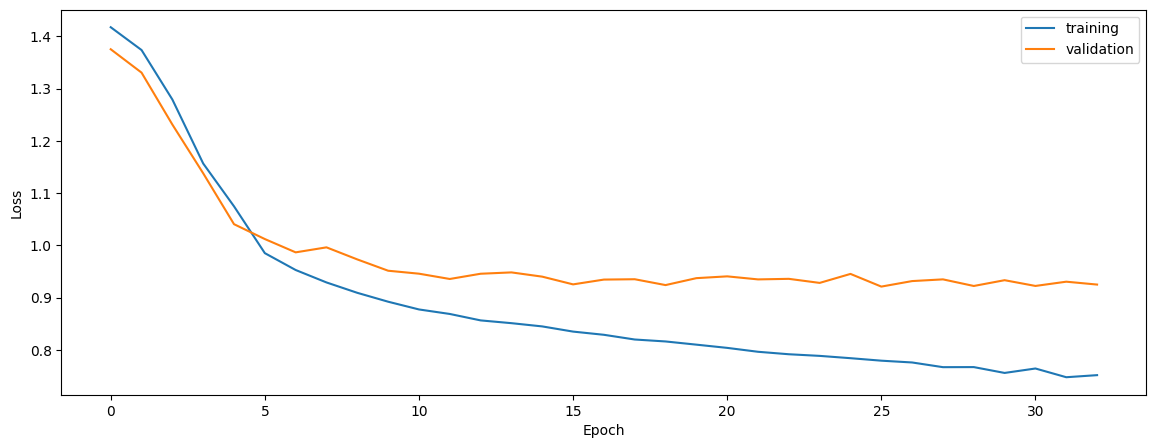

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


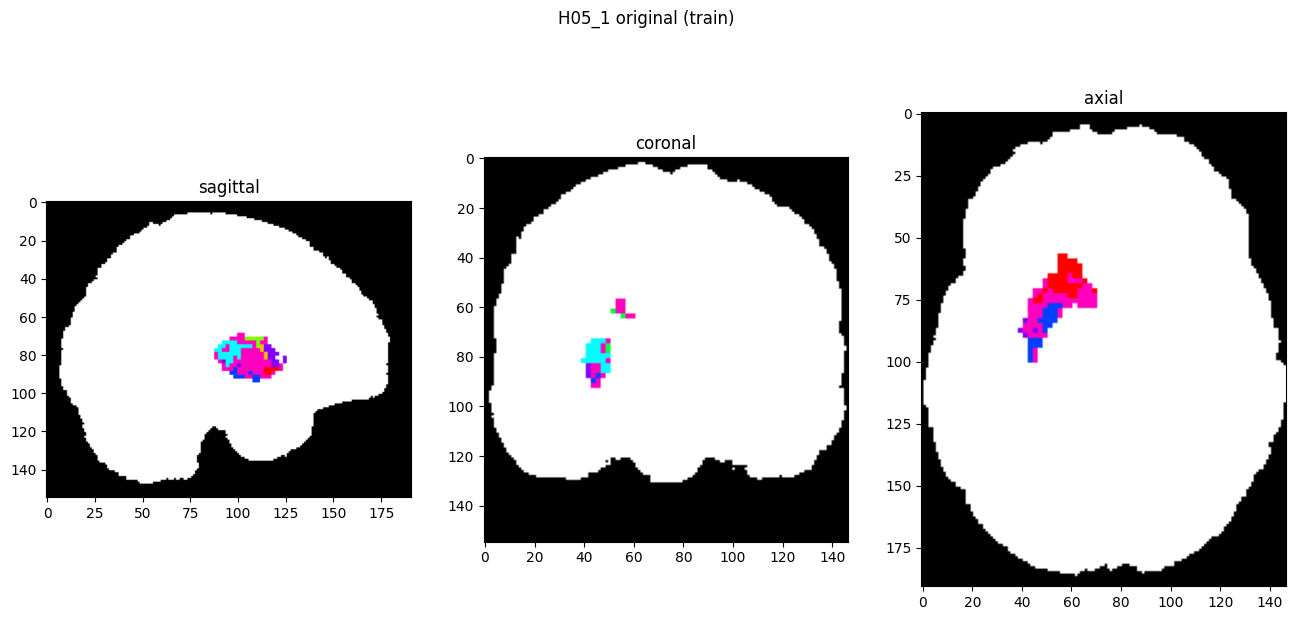

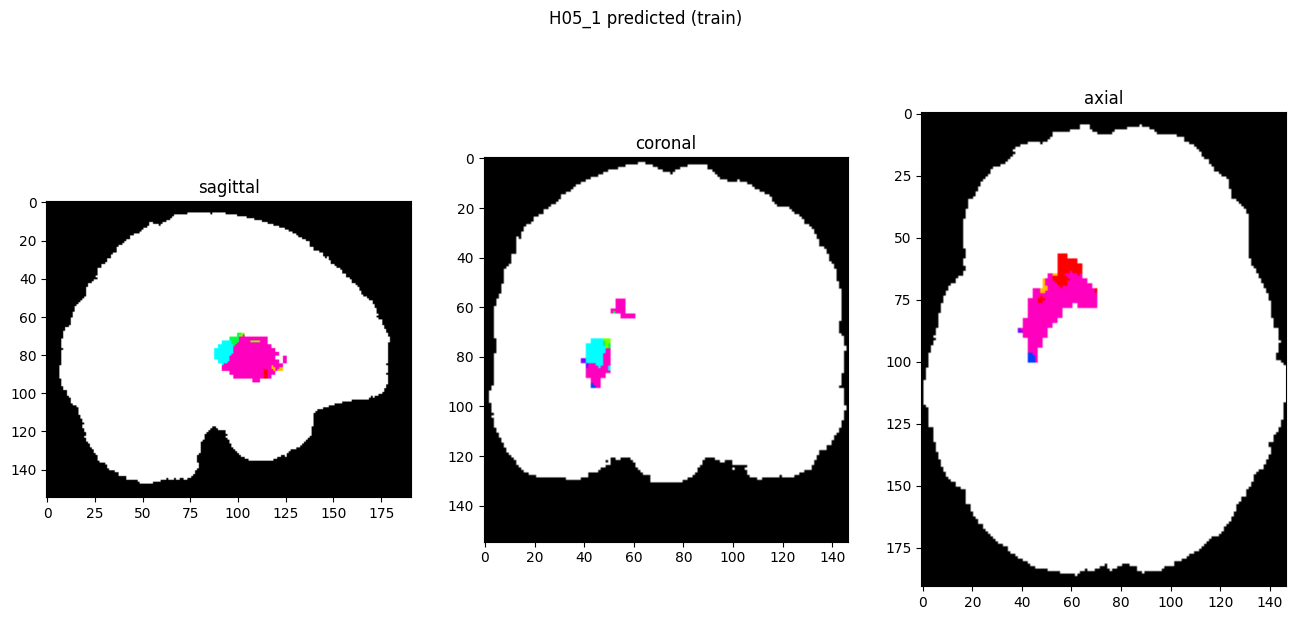

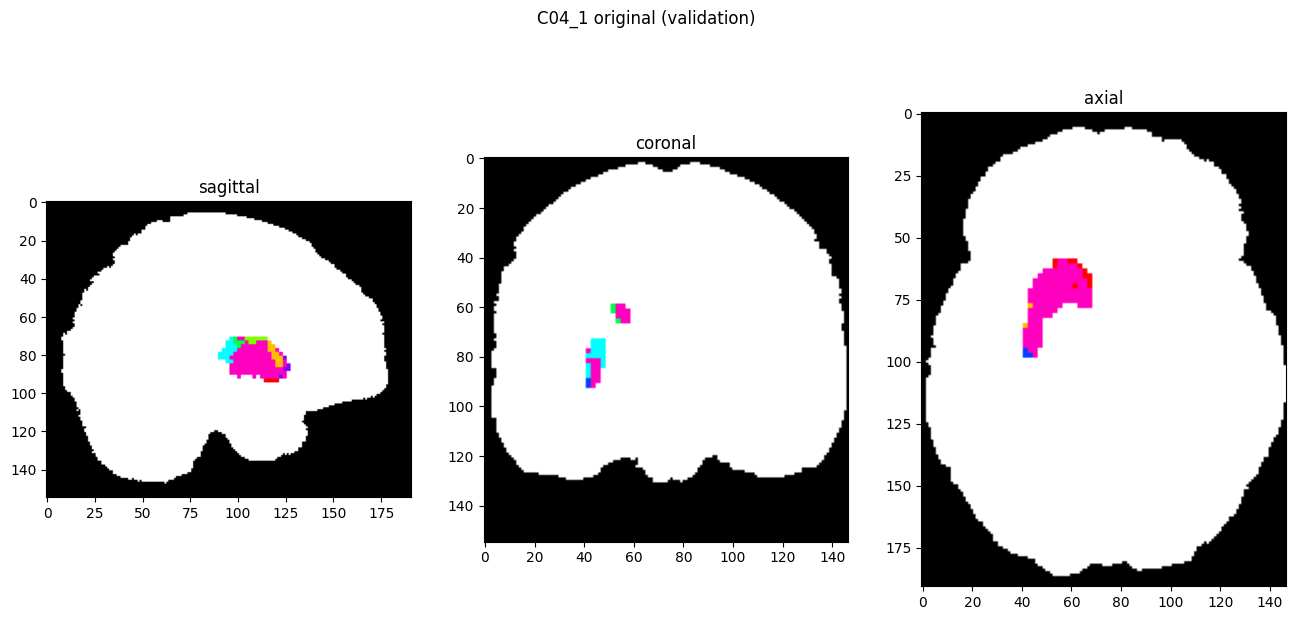

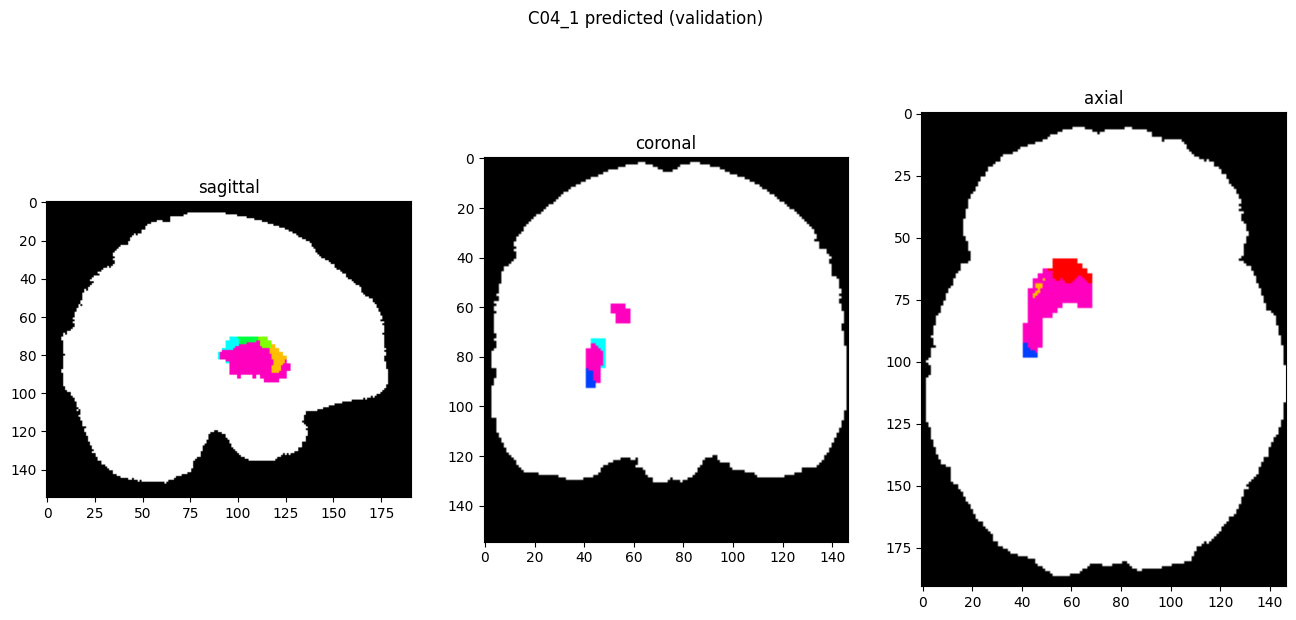

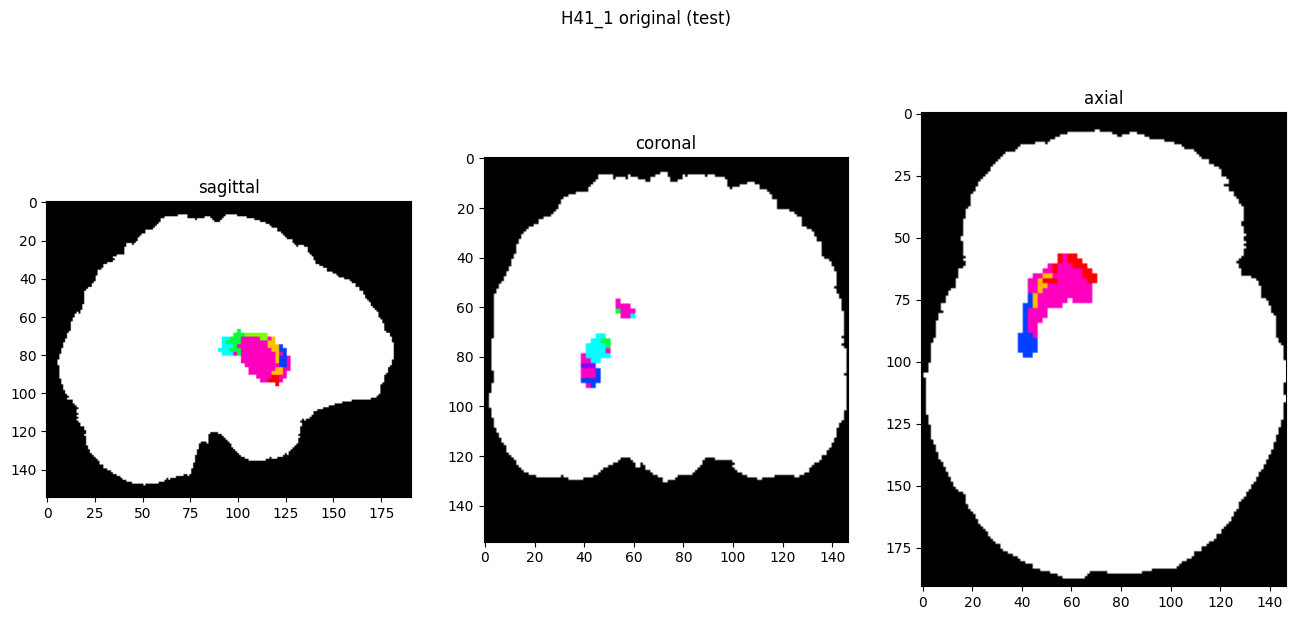

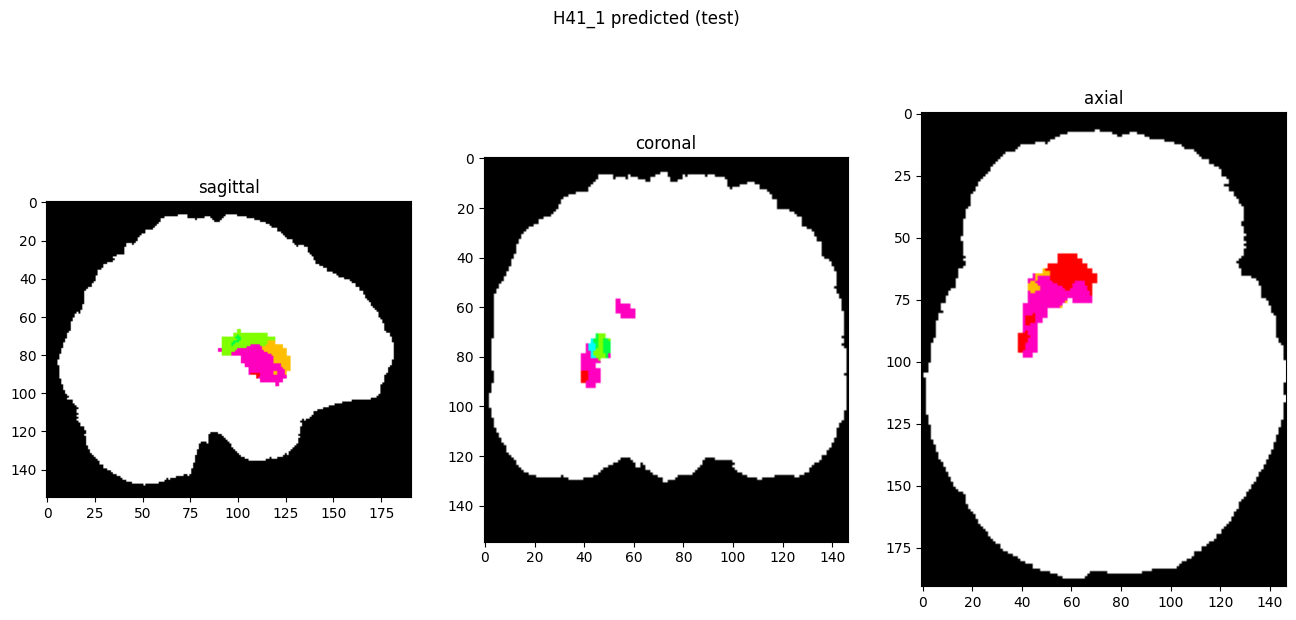

In [10]:
showResults(model, gen, threshold=0)